In [1]:
# Import packages 

import pandas as pd
import glob
import numpy as np
import re
import regex
import time
import random
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import requests
import cloudscraper
from bs4 import BeautifulSoup
import urllib.parse
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Project Aims and Hypothesis

The primary aim of this project is to generate a predictive model for used car prices based on the predictors which are gathered on AutoTrader. The final model should be interpretable.


Based on a small amount of domain knowledge, the secondary hypothesis is that of the car makes studied within this project, a Dacia car owns the smallest brand-price-factor, while a Volvo car own the largest brand-price-factor. This hypothesis will be evaluated on used cars only.

# Web Scrape - AutoTrader

In [2]:
# Sample Autotrader used car scraping function, not to be run here! 

def get_used_cars(
    postcode="KT12 2HG",
    radius=1500,
    min_year=1995,
    max_year=1995,
    include_writeoff="include",
    max_attempts_per_page=5,
    verbose=False):

    # To bypass Cloudflare protection
    scraper = cloudscraper.create_scraper()

    # Basic variables
    results = []
    n_this_year_results = 0
    # If a search returns > 1000 results then only the first 1000 are made available.
    # These such searches are recorded in the extra_make_list for later attention 
    extra_make_list = []
    url = "https://www.autotrader.co.uk/results-car-search"

    # Keywords commonly used on Autotrader in each of the fields being scraped
    keywords = {}
    keywords["mileage"] = ["miles"]
    keywords["BHP"] = ["BHP","PS"]
    keywords["transmission"] = ["Automatic", "Manual"]
    keywords["fuel"] = ["Petrol", "Diesel", "Electric", "Hybrid – Diesel/Electric Plug-in", 
                        "Hybrid – Petrol/Electric", "Hybrid – Petrol/Electric Plug-in", "Bi Fuel",
                        "Diesel Hybrid","Diesel Plug-in Hybrid","Hydrogen","Natural Gas","Petrol Hybrid"
                        "Petrol Plug-in Hybrid"]
    keywords["owners"] = ["owners", "owner","own"]
    keywords["body"] = ["Coupe", "Convertible", "Estate", "Hatchback", "MPV", "Pickup", "SUV", "Saloon"]
    keywords["ULEZ"] = ["ULEZ"]
    keywords["year"] = [" reg)","new"]
    keywords["engine"] = ["engine"]

    # Set up parameters for query to autotrader.co.uk
    mpgall = ['OVER_60','OVER_50','OVER_40','OVER_30']
    drivetrainall = ['Four Wheel Drive','Front Wheel Drive','Rear Wheel Drive']
    makeall = ['AC','Abarth','Aixam','Alfa Romeo','Alpine','Ariel','Aston Martin','Audi','Austin',
        'BAC','BMW','Beauford','Bentley','Bowler','Bugatti','Buick',
        'CUPRA','Cadillac','Carbodies','Caterham','Chesil','Chevrolet','Chrysler','Citroen','Corvette',
        'DAF','DFSK','DS Automobiles','Dacia','Daewoo','Daihatsu','Daimler','Datsun','Delorean','Dodge',
        'Ferrari','Fiat','Ford','GMC','Great Wall',
        'Hillman','Honda','Hummer','Hyundai','Infiniti','Isuzu','Iveco','Jaguar','Jeep','Jensen','KIA',
        'LEVC','Lada','Lamborghini','Lancia','Land Rover','Lexus','Lincoln','London Taxis International','Lotus',
        'MG','MINI','Mahindra','Maserati','Maybach','Mazda','McLaren','Mercedes-Benz','Microcar','Mitsubishi',
        'Mitsuoka','Morgan','Morris','Nissan','Noble','Opel','Packard','Perodua','Peugeot','Pilgrim','Polestar',
        'Pontiac','Porsche','Proton','REO','Radical','Rage','Raptor','Reliant','Renault','Replica','Reva','Riley',
        'Rolls-Royce','Rover','SEAT','SKODA','Saab','Sebring','Singer','Smart','Spyker','Ssangyong','Subaru',
        'Sunbeam','Suzuki','TVR','Tesla','Tiger','Toyota','Triumph','Ultima','Vauxhall','Venturi','Volkswagen',
        'Volvo','Westfield','Wolseley','Yamaha','Zenos']
    body = ["Coupe", "Convertible", "Estate", "Hatchback", "MPV", "Pickup", "SUV", "Saloon"]
    trans = ["Automatic", "Manual"]
    sort = ["price-asc","price-desc"]
    
    # Iterate over combinations of the search key words. We make such specific searches in an aim
    # to return <1000 results per search
    for divide in tqdm(list(itertools.product(mpgall, drivetrainall, submake, body, trans, sort))):  
        params = {
            "sort": divide[5],
            "postcode": postcode,
            "radius": radius,
            "make": divide[2],
            "search-results-price-type": "total-price",
            "search-results-year": "select-year",
            "exclude-writeoff-categories":"on",
            "fuel-consumption":divide[0],
            "drivetrain":divide[1],
            "body-type":divide[3],
            "transmission":divide[4]
             }    
    
        # Set up writeoff parameters for query. Included by default args. 
        if (include_writeoff == "include"):
            params["writeoff-categories"] = "on"
        elif (include_writeoff == "exclude"):
            params["exclude-writeoff-categories"] = "on"
        elif (include_writeoff == "writeoff-only"):
            params["only-writeoff-categories"] = "on"

        # Set up year parameters for query. Start at year_min and grow to year_max  
        year = min_year
        page = 1
        attempt = 1

        try:
            while year <= max_year:
                params["year-from"] = year
                params["year-to"] = year
                params["page"] = page

                #Sleep timer was not required with VPN cloudscraper combination.
                #time.sleep(random.randint(1,9))
                r = scraper.get(url, params=params)
                
                if verbose:
                    print("Year:     ", year,"\t Page:     ", page,"\t Response: ", r)

                try:
                    if r.status_code != 200: # if not successful (e.g. due to bot protection), log as an attempt
                        attempt = attempt + 1
                        if attempt <= max_attempts_per_page: # break if max_attempts reached
                            if verbose:
                                print("Exception. Starting attempt #", attempt, "and keeping at page #", page)
                        if r.status_code == 500: # break if internal website error
                            break
                        else:
                            page = page + 1
                            attempt = 1
                            if verbose:
                                print("Exception. All attempts exhausted for this page. Skipping to next page #", page)
                            if page > 100: # Autotrader does not return sensible results beyond 100 pages
                                break
                    else:

                        j = r.json()
                        s = BeautifulSoup(j["html"], features="html.parser")

                        # Use beautifulsoup to generate list of cars on each page - called articles 
                        articles = s.find_all("article", attrs={"data-standout-type":""})

                        # if no results or reached end of results, report this then increment for next search
                        if len(articles) == 0 or r.url[r.url.find("page=")+5:] != str(page):
                            if verbose:
                                print("Found total", n_this_year_results, "results for year", year, "and brand", divide, "across", page-1, "pages")
                                # If search returnd > 1000 cars, add car band to the list.
                                if n_this_year_results == 1000:
                                    extra_make_list.append(params["make"])
                                if year+1 <= max_year:
                                    print("Moving on to year", year + 1)
                                    print("---------------------------------")

                            # Increment year and reset relevant variables
                            year = year + 1
                            page = 1
                            attempt = 1
                            n_this_year_results = 0
                        else:
                            # For each car, build a dictionary. Some from seach parameters, some from produced article
                            for article in articles:
                                car = {}
                                seller_href=[]
                                car["name"] = article.find("h3", {"class": "product-card-details__title"}).text.strip()
                                car["name_subtitle"] = article.find("h3", {"class": "product-card-details__title"}).findNext('p').text.strip()                       
                                car["link"] = "https://www.autotrader.co.uk" + article.find("a", {"class": "tracking-standard-link"})["href"][: article.find("a", {"class": "tracking-standard-link"})["href"].find("?")]
                                car["price"] = article.find("div", {"class": "product-card-pricing__price"}).text.strip()
                                car["mpg"] = divide[0]
                                car["drivertrain"] = divide[1]
                                car["make"] = divide[2]
                                seller = article.find_all("span", {"class": "product-card-seller-info__spec-item-copy"})#.text.strip()
                                seller=reversed(seller)
                                for count,sel in enumerate(seller):
                                    car["seller"+str(count)] = sel.text.strip()
                                for a in article.find_all("a", {"class": "product-card-seller-info__review-count dealer-profile-link", "href":True}):
                                    seller_href.append(a["href"])
                                for count,ref in enumerate(seller_href):
                                    car["href"+str(count)] = ref

                                # The key specs are in a bulleted list
                                key_specs_bs_list = article.find("ul", {"class": "listing-key-specs"}).find_all("li")

                                for key_spec_bs_li in key_specs_bs_list:

                                    key_spec_bs = key_spec_bs_li.text                              

                                    if any(keyword in key_spec_bs for keyword in keywords["mileage"]):
                                        car["mileage"] = int(key_spec_bs[:key_spec_bs.find(" miles")].replace(",",""))
                                    elif any(keyword in key_spec_bs for keyword in keywords["BHP"]):
                                        car["BHP"] = key_spec_bs
                                    elif any(keyword in key_spec_bs for keyword in keywords["transmission"]):
                                        car["transmission"] = key_spec_bs
                                    elif any(keyword in key_spec_bs for keyword in keywords["fuel"]):
                                        car["fuel"] = key_spec_bs
                                    elif any(keyword in key_spec_bs for keyword in keywords["owners"]):
                                        car["owners"] = int(key_spec_bs[:key_spec_bs.find(" own")])
                                    elif any(keyword in key_spec_bs for keyword in keywords["body"]):
                                        car["body"] = key_spec_bs
                                    elif any(keyword in key_spec_bs for keyword in keywords["ULEZ"]):
                                        car["ULEZ"] = key_spec_bs
                                    elif any(keyword in key_spec_bs for keyword in keywords["year"]):
                                        car["year"] = key_spec_bs
                                    elif key_spec_bs[1] == "." and key_spec_bs[3] == "L":
                                        car["engine"] = key_spec_bs
                                
                                # Set any missing dictionary keys to NA for complete car details.
                                for key in keywords.keys():
                                    if key in car.keys():
                                        pass
                                    else:
                                        car[key]='NA'
                                # Add complete car dictionary to results list.
                                results.append(car)
                                n_this_year_results = n_this_year_results + 1

                            page = page + 1
                            attempt = 1

                            if verbose:
                                print("Car count: ", len(results))
                                print("---------------------------------")

                except KeyboardInterrupt:
                    break

                except:
                    traceback.print_exc()
                    attempt = attempt + 1
                    if attempt <= max_attempts_per_page:
                        if verbose:
                            print("Exception. Starting attempt #", attempt, "and keeping at page #", page)
                    else:
                        page = page + 1
                        attempt = 1
                        if verbose:
                            print("Exception. All attempts exhausted for this page. Skipping to next page #", page)

        except KeyboardInterrupt:
            pass
    
    # Make df of results and output to csv
    results = pd.DataFrame(results)
    now = (datetime.datetime.now().strftime("%d%B_%I%M%p"))
    filepathdf=f'/Users/robertdavies/Desktop/DSI/GA_P2/DSI21-lessons/projects/project-capstone/df_detailed/{now}_{min_year}-{max_year}_used.csv'
    results.to_csv(filepathdf, index=False, header=results.columns )

    return results, list(set(extra_make_list))

# Import and clean cars

## Used cars - not electric

In [3]:
# Import all detailed files and make cars df, including year 

path = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/raw/df_detailed'

li=[]
for year in range(1990,2022):
    year_files = glob.glob(path + f"/*{year}*used.csv")
    #print(len(year_files),'file(s) to load from', year)
    for filename in year_files:
        df = pd.read_csv(filename, index_col=None, header=0 )
        df['YR'] = year
        df.drop_duplicates(subset=['link'], keep='first', inplace=True)
        li.append(df)

ucars = pd.concat(li, axis=0, ignore_index=True)
ucars.drop_duplicates(subset=['link'], keep='first', inplace=True)
ucars.shape

(374854, 20)

In [4]:
# Clean cars.body 

#Create df of cars will null body
nabody = ucars[ucars['body'].isnull()].copy()

#Encode body column but don't overwrite
to_encode = ['body']
cars_e = ucars.copy()
for col in to_encode:
    le = LabelEncoder()
    cars_e[col] = le.fit_transform(cars_e[col]) 

#Iterate through null-body cars and replace with corresponding modal body value based on name column grouping
for index, car in nabody.iterrows():
    carname=nabody.loc[index,'name']
    body=nabody.loc[index,'body']
    nabody.loc[index,'body'] = cars_e[cars_e['name']==carname].body.mode()[0]
    cars_e.loc[index,'body'] = cars_e[cars_e['name']==carname].body.mode()[0]     

#Reverse the encoding    
for col in to_encode:
    ucars[col] = le.inverse_transform(cars_e[col]) 

#After checking the remaining cars without a body, it is clear that they are all vans!    
ucars.body = ['Van' if pd.Series(x).isnull()[0]==True else x for x in ucars.body]        

ucars.shape

(374854, 20)

In [5]:
# Clean cars.BHP, taking values from cars.engine where necessary. Drop remaining NaN. 

# Unmerge some of the BHP entries which have engine size in there too.
for index, car in ucars[ucars['BHP'].str.contains('L', regex=True, na=False)].iterrows():
    ucars.loc[index, 'engine'] = str(ucars.loc[index, 'BHP']).split(' ')[0]
    ucars.loc[index, 'BHP'] = str(ucars.loc[index, 'BHP']).split(' ')[1].strip('()') 

# Drop NaN BHP
ucars.dropna(subset=['BHP'],inplace=True)

def standardise_bhp(x):
    lenbhp = len(str(x).split(' '))
    bhp=x
    if lenbhp == 1:
        if 'BHP' in x:
            bhp=float(re.findall('[0-9]+', x)[0])       
        elif 'PS' in x:
            ps=float(re.findall('[0-9]+', x)[0])
            bhp = ps/1.014        
    elif lenbhp == 2:
        x=str(x.split(' ')[-1])
        if 'BHP' in x:
            bhp=float(re.findall('[0-9]+', x)[0])      
        elif 'PS' in x:
            ps=float(re.findall('[0-9]+', x)[0])
            bhp = ps/1.014
    else:
        bhp=np.nan   
    return bhp    

#Standardise remaining BHP (convert from PS)
ucars.BHP = ucars.BHP.apply(lambda x: standardise_bhp(x))

ucars.shape

(374590, 20)

In [6]:
# Compile the best location variable. Retain dealer_city and dealer_area. Don't drop remaining NaN. 

#split href0 into city and area
ucars['dealer_city_temp'] = [x.split('/')[3] if type(x)==str and len(x.split('/'))>3 else x for x in ucars.href0]
ucars['dealer_area'] = [x.split('/')[2] if type(x)==str and len(x.split('/'))>3 else x for x in ucars.href0]

#If there are some seller ratings in seller0, move them to seller1
ucars[ucars['seller0'].str.contains('[+-]?([0-9]*[.])?[0-9]+', regex=True, na=False)].seller1 = ucars[ucars['seller0'].str.contains('[+-]?([0-9]*[.])?[0-9]+', regex=True, na=False)].seller0

#Make seller ratings in seller0 np.nan
ucars.seller0 =[np.nan if '4' in str(x) or '5' in str(x) else x for x in ucars.seller0]

#If the seller0 column is np.nan, use the dealer_city 
for index, car in ucars.iterrows():
    if pd.isnull(ucars.loc[index,'seller0']):
        ucars.loc[index,'seller0']=ucars.loc[index,'dealer_city_temp']
        
ucars['dealer_city'] = ucars['seller0']
ucars.drop(['seller0','dealer_city_temp'],inplace=True, axis=1)

ucars.shape

/var/folders/1h/l422441d07d4l2q1nfyrjk740000gn/T/ipykernel_18360/1685540951.py:8: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  ucars[ucars['seller0'].str.contains('[+-]?([0-9]*[.])?[0-9]+', regex=True, na=False)].seller1 = ucars[ucars['seller0'].str.contains('[+-]?([0-9]*[.])?[0-9]+', regex=True, na=False)].seller0
/Users/robertdavies/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


(374590, 21)

In [7]:
# Iterate over missing engine rows and use RegEx on name_subtitle to extract engine size where possible. 

for index, car in ucars[ucars['engine'].isnull()].iterrows():
    car_subname = ucars.loc[index, 'name_subtitle']
    try:
        enginesize = re.findall('([0-9][.][0-9]+)',car_subname)[0]
    except: 
        enginesize = np.nan
    ucars.loc[index,'engine'] = float(enginesize)

# Remove L from each engine size.
ucars.engine= ucars.engine.apply(lambda x: float(str(x).replace('L','')))

# Drop remaining 105 used cars without engine size.
ucars.dropna(subset=['engine'],inplace=True)

ucars.shape

(374485, 21)

In [8]:
# Make cars.doors 

def extract_drs(x):
    drs = re.findall('( [1-8]d[Rr]?)',x, re.I)
    if len(drs) > 0:
        drs = str(drs[0]).lower()
    else:
        drs = re.findall('([1-8][ ]?door)',x, re.I)
        if len(drs) > 0:
            drs = str(drs[0])[0]+'dr'
        else:
            drs = re.findall('([1-8]dr)',x, re.I)
            if len(drs) > 0:
                drs = str(drs[0])[0]+'dr'
            else:
                drs = re.findall('(D-4D)',x, re.I)
                if len(drs) > 0:
                    drs = '4dr'
                else:
                    drs='0dr'
                
    if ('r' or 'R') not in drs:
        drs = drs.replace('d','dr')
    return drs.strip()
     
ucars['doors'] = ucars.name_subtitle.apply(lambda x: extract_drs(x))

#Create df of cars with 0 doors
zerodoors = ucars[ucars['doors']=='0dr'].copy()

#Encode doors column but don't overwrite
to_encode = ['doors']
cars_e = ucars.copy()
for col in to_encode:
    le = LabelEncoder()
    cars_e[col] = le.fit_transform(cars_e[col]) 

#Iterate through zero door cars and replace with corresponding num doors based on name column grouping
for index, car in zerodoors.iterrows():
    carname=zerodoors.loc[index,'name']
    cars_e.loc[index,'doors'] = cars_e[cars_e['name']==carname].doors.mode()[0]     

#Reverse the encoding    
for col in to_encode:
    ucars[col] = le.inverse_transform(cars_e[col]) 

#Drop the remaining 226 cars without door information    
ucars=ucars[ucars.doors!='0dr'].copy()
ucars.dropna(subset=['doors'],inplace=True)
    
ucars.shape

(374231, 22)

In [9]:
# Clean cars.mileage 

#Drop them - only 283
ucars.dropna(subset=['mileage'],inplace=True)

ucars.shape

(373936, 22)

In [10]:
# Clean cars.fuel 

#Drop them - only 12
ucars.dropna(subset=['fuel'],inplace=True)

ucars.shape

(373916, 22)

In [11]:
# Clean cars.price, make cars.ID, clean cars.year 

to_dummy=['mpg','drivetrain','make','body','transmission','fuel']

ucars.price=ucars.price.apply(lambda x: x.replace('£',''))
ucars.price=ucars.price.apply(lambda x: float(x.replace(',','')))
ucars['id'] =[x.split('/')[-1] for x in ucars.link]
ucars['year_reg']=ucars.year
ucars['year']=ucars.YR
ucars.drop('YR',inplace=True, axis=1)

ucars.shape

(373916, 23)

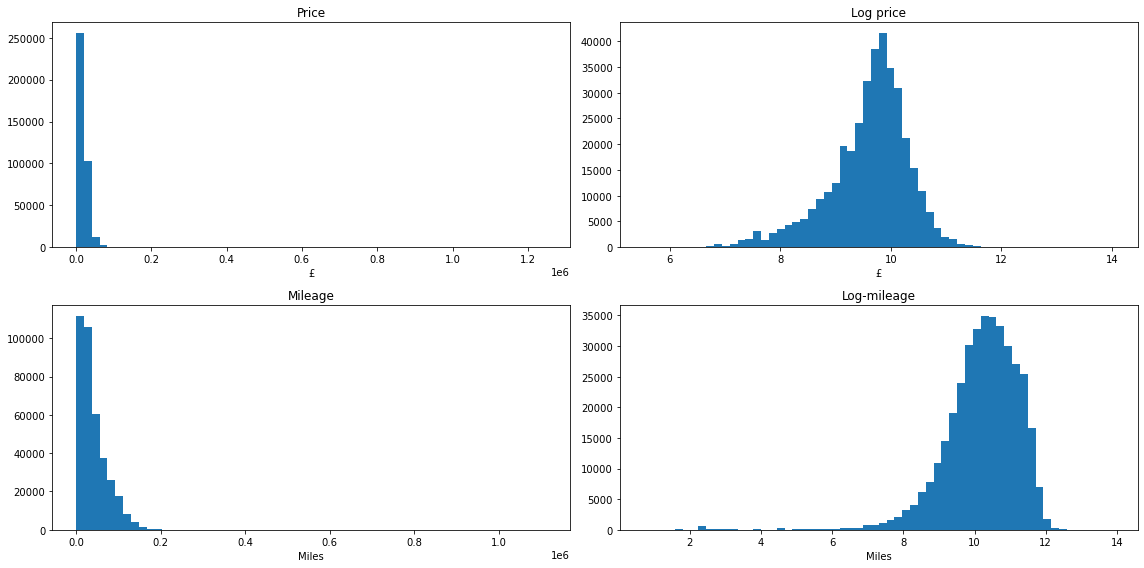

In [12]:
# Have a nosey at the price and mileage distribution

ucars['log_price']=ucars.price.apply(lambda x: np.log(x))
ucars['log_mileage']=ucars.mileage.apply(lambda x: np.log(x))

#mask = np.abs((ucars.price - ucars.price.mean(0)) / ucars.price.std(0)) > 3
#ucars= ucars[~mask]
#ucars.price.plot(kind='hist', bins=50, title='Car Price after outlier removal', xlabel='£');

#mask = np.abs((ucars.mileage - ucars.mileage.mean(0)) / ucars.mileage.std(0)) > 3
#ucars= ucars[~mask]
#ucars.mileage.plot(kind='hist', bins=50, title='Car Mileage');

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,8))
ax[0,0].hist(ucars.price, bins=60)
ax[0,1].hist(ucars.log_price, bins=60)
ax[1,0].hist(ucars.mileage, bins=60)
ax[1,1].hist(ucars.log_mileage, bins=60)
ax[0,0].set_xlabel('£')
ax[0,1].set_xlabel('£')
ax[1,0].set_xlabel('Miles')
ax[1,1].set_xlabel('Miles')
ax[0,0].set_title('Price')
ax[0,1].set_title('Log price')
ax[1,0].set_title('Mileage')
ax[1,1].set_title('Log-mileage')
plt.tight_layout()
plt.show()

In [13]:
# Simplify the cars.name column. Probably not perfect 

ucars['orig_name'] = ucars.name
ucars['lname']=ucars.name.apply(lambda x: x.lower())

body =["coupe", "convertible", "estate", "hatchback", "MPV", "pickup", 
       "SUV", "saloon","cabriolet","sedan"]
name_list_from_carsized = ['abarth 500', 'acura nsx', 'alfa-romeo 147', 'alfa-romeo 156',
       'alfa-romeo 159', 'alfa-romeo 164', 'alfa-romeo 4c',
       'alfa-romeo giulia', 'alfa-romeo giulietta', 'alfa-romeo mito',
       'alfa-romeo sprint', 'alfa-romeo stelvio', 'alvis tc 108',
       'aston-martin db11', 'aston-martin dbx', 'aston-martin rapide',
       'aston-martin vantage', 'audi 100', 'audi a1', 'audi a2',
       'audi a3', 'audi a4', 'audi a5', 'audi a6', 'audi a7', 'audi a8',
       'audi e tron', 'audi e tron gt', 'audi q2', 'audi q3',
       'audi q4 e tron', 'audi q5', 'audi q7', 'audi q8', 'audi r8',
       'audi tt', 'austin 7', 'austin healey 3000', 'bentley 3 5 litre',
       'bentley bentayga', 'bentley continental flying spur',
       'bentley continental gt', 'bentley flying spur', 'bmw 1 series', 'bmw 2 series',
       'bmw 3 series', 'bmw 4 series', 'bmw 5 series', 'bmw 6 series', 'bmw 7 series', 'bmw 8 series',
       'bmw i3', 'bmw i8', 'bmw isetta', 'bmw ix', 'bmw x1', 'bmw x2',
       'bmw x3', 'bmw x4', 'bmw x5', 'bmw x6', 'bmw x7', 'bmw z4',
       'buick skylark', 'cadillac ats', 'cadillac bls', 'cadillac cts',
       'cadillac eldorado', 'cadillac escalade', 'cadillac seville',
       'cadillac srx', 'cadillac xt5', 'chevrolet aveo',
       'chevrolet bel air', 'chevrolet camaro', 'chevrolet caprice',
       'chevrolet captiva', 'chevrolet corvette', 'chevrolet cruze',
       'chevrolet epica', 'chevrolet equinox', 'chevrolet impala',
       'chevrolet malibu', 'chevrolet matiz', 'chevrolet spark',
       'chevrolet tahoe', 'chrysler 300', 'chrysler pt cruiser',
       'chrysler sebring', 'chrysler voyager', 'citroen b14',
       'citroen berlingo', 'citroen c crosser', 'citroen c elysee',
       'citroen c1', 'citroen c3', 'citroen c3 aircross', 'citroen c4',
       'citroen c4 cactus', 'citroen c4 picasso', 'citroen c5',
       'citroen c5 aircross', 'citroen c8', 'citroen ds', 'citroen ds5',
       'citroen jumpy', 'citroen space tourer', 'cupra ateca',
       'cupra born', 'cupra formentor', 'cupra leon', 'dacia dokker',
       'dacia duster', 'dacia lodgy', 'dacia logan', 'dacia sandero',
       'daewoo lacetti', 'daihatsu sirion', 'daihatsu terios',
       'daimler 250 v8', 'daimler six', 'dodge 880', 'dodge caliber',
       'dodge challenger', 'dodge charger', 'dodge durango',
       'dodge journey', 'dodge nitro', 'dodge ram', 'dodge viper', 'ds 3',
       'ds 3 crossback', 'ds 4', 'ds 7 crossback', 'excalibur series ii',
       'ferrari 458', 'ferrari 488', 'ferrari 512', 'ferrari california',
       'ferrari california t', 'ferrari ff', 'ferrari gtc4lusso',
       'ferrari sf90', 'ferrari testarossa', 'fiat 1100', 'fiat 500',
       'fiat 500l', 'fiat 500x', 'fiat 600', 'fiat bravo', 'fiat croma',
       'fiat freemont', 'fiat fullback', 'fiat panda', 'fiat punto',
       'fiat qubo', 'fiat tipo', 'fisker karma', 'ford b max','fiat ducato'
       'ford c max', 'ford cougar', 'ford ecosport', 'ford edge',
       'ford escape', 'ford explorer', 'ford f150',
       'ford fairlane 500 skyliner', 'ford fiesta', 'ford focus',
       'ford galaxy', 'ford ka', 'ford kuga', 'ford model 48',
       'ford model t', 'ford mondeo', 'ford mustang',
       'ford mustang mach e', 'ford puma', 'ford ranger', 'ford s max',
       'ford scorpio', 'ford taurus', 'ford tourneo',
       'ford tourneo connect', 'ford tourneo courier', 'genesis g70',
       'genesis g80', 'genesis gv70', 'genesis gv80', 'gmc sierra',
       'gmc terrain', 'gmc yukon xl', 'honda accord', 'honda city',
       'honda civic', 'honda cr v', 'honda e', 'honda hr v',
       'honda jazz fit', 'honda nsx', 'honda odyssey', 'honda s',
       'hummer h2', 'hyundai getz', 'hyundai i10', 'hyundai i20',
       'hyundai i30', 'hyundai i40', 'hyundai ioniq', 'hyundai ioniq 5',
       'hyundai ix20', 'hyundai kona', 'hyundai nexo', 'hyundai santa fe',
       'hyundai tiburon', 'hyundai tucson', 'hyundai veloster',
       'infinity fx', 'infinity q30', 'infiniti q50 sedan',
       'infinity qx80', 'isuzu d max', 'jac refine e s2', 'jaguar e pace',
       'jaguar e type', 'jaguar f pace', 'jaguar f type', 'jaguar i pace',
       'jaguar x type', 'jaguar xe', 'jaguar xf', 'jaguar xj',
       'jaguar xk', 'jaguar xk120', 'jeep cherokee', 'jeep compass',
       'jeep wrangler', 'jeep grand cherokee', 'jeep renegade',
       'kia carens', 'kia ceed', 'kia ev6', 'kia magentis', 'kia niro',
       'kia picanto', 'kia rio', 'kia sorento', 'kia soul',
       'kia sportage', 'kia stinger', 'kia stonic', 'kia venga',
       'lada 2102', 'lada 4x4', 'lamborghini aventador',
       'lamborghini huracan', 'lamborghini urus', 'lancia delta',
       'lancia phedra', 'lancia ypsilon', 'land rover defender',
       'land rover discovery', 'land rover discovery sport',
       'land rover freelander', 'land rover range rover',
       'land rover range rover evoque', 'land rover range rover sport',
       'land rover range rover velar', 'lexus ct', 'lexus gs', 'lexus is',
       'lexus ls', 'lexus lx', 'lexus nx', 'lexus rx', 'lexus sc',
       'lexus ux', 'lincoln mkx', 'lincoln navigator', 'lincoln town car',
       'lotus elan', 'lotus elise', 'maserati ghibli',
       'maserati granturismo', 'maserati levante',
       'maserati quattroporte', 'maybach 57', 'mazda 2', 'mazda 3',
       'mazda 5', 'mazda 6', 'mazda cx 3', 'mazda cx 30', 'mazda cx 5',
       'mazda cx 7', 'mazda cx 9', 'mazda mx 30', 'mazda mx 5',
       'mclaren 12c', 'mclaren 650s', 'mclaren 720s', 'mercedes-benz 123',
       'mercedes-benz 170 s', 'mercedes-benz 220', 'mercedes-benz 220 s',
       'mercedes-benz a class', 'mercedes-benz amg gt', 'mercedes-benz b class',
       'mercedes-benz c class', 'mercedes-benz citan', 'mercedes-benz cl class',
       'mercedes-benz cla class', 'mercedes-benz clk class', 'mercedes-benz cls class',
       'mercedes-benz e class', 'mercedes-benz 3', 'mercedes-benz eqa',
       'mercedes-benz eqc class', 'mercedes-benz eqs class', 'mercedes-benz g class',
       'mercedes-benz gl class', 'mercedes-benz gla class', 'mercedes-benz glb class',
       'mercedes-benz glc class', 'mercedes-benz gle class', 'mercedes-benz glk class',
       'mercedes-benz gls class', 'mercedes-benz m class', 'mercedes-benz r class',
       'mercedes-benz s class', 'mercedes-benz sl', 'mercedes-benz slk',
       'mercedes-benz v class', 'mercedes-benz vito', 'mercedes-benz w114',
       'mercedes-benz x class', 'mercury cougar', 'mg f', 'mg mgb', 'mg tf',
       'mini clubman', 'mini cooper', 'mini countryman', 'mini paceman',
       'mitsubishi asx', 'mitsubishi colt', 'mitsubishi i miev',
       'mitsubishi l200', 'mitsubishi lancer', 'mitsubishi mirage',
       'mitsubishi outlander', 'mitsubishi pajero', 'moskvitch 400',
       'nissan 370z', 'nissan altima', 'nissan juke', 'nissan leaf',
       'nissan micra', 'nissan murano', 'nissan navara', 'nissan note',
       'nissan nv200', 'nissan pathfinder', 'nissan pixo',
       'nissan qashqai', 'nissan x trail', 'oldsmobile 88',
       'oldsmobile cutlass supreme', 'vauxhall adam', 'vauxhall agila',
       'vauxhall ampera', 'vauxhall astra', 'vauxhall calibra', 'vauxhall cascada',
       'vauxhall corsa', 'vauxhall crossland x', 'vauxhall grandland',
       'vauxhall insignia', 'vauxhall karl', 'vauxhall meriva', 'vauxhall mokka',
       'vauxhall tigra', 'vauxhall vectra', 'vauxhall zafira', 'peugeot 1007',
       'peugeot 108', 'peugeot 206', 'peugeot 207', 'peugeot 208', 'peugeot 2008'
       'peugeot 3008', 'peugeot 306', 'peugeot 307', 'peugeot 308',
       'peugeot 4007', 'peugeot 4008', 'peugeot 406', 'peugeot 407',
       'peugeot 5008', 'peugeot 508', 'peugeot 807', 'peugeot expert',
       'peugeot partner', 'peugeot traveller', 'plymouth volare',
       'polestar 2', 'pontiac firebird', 'pontiac gto', 'porsche 356',
       'porsche 718', 'porsche 718 cayman', 'porsche 911', 'porsche 928',
       'porsche cayenne 5 door coupe suv', 'porsche cayenne',
       'porsche macan', 'porsche panamera', 'porsche taycan',
       'renault captur', 'renault clio', 'renault espace',
       'renault fluence', 'renault fuego', 'renault kadjar',
       'renault kangoo', 'renault koleos', 'renault laguna',
       'renault megane', 'renault modus', 'renault scenic',
       'renault talisman', 'renault twingo', 'renault twizy',
       'renault zoe', 'rolls-royce corniche', 'rolls-royce cullinan',
       'rolls-royce ghost', 'rolls-royce phantom',
       'rolls-royce silver shadow', 'rolls-royce silver spirit',
       'rolls-royce wraith', 'rover sd1', 'saab 9 3', 'saab 9 5',
       'seat alhambra', 'seat altea', 'seat arona', 'seat ateca',
       'seat exeo', 'seat ibiza', 'seat leon', 'seat mii', 'seat tarraco',
       'skoda citigo', 'skoda enyaq iv', 'skoda fabia', 'skoda kamiq',
       'skoda karoq', 'skoda kodiaq', 'skoda octavia', 'skoda rapid',
       'skoda scala', 'skoda superb', 'skoda yeti', 'smart forfour',
       'smart fortwo', 'smart roadster', 'ssang yong korando',
       'ssang yong kyron', 'ssang yong rexton', 'ssang yong tivoli',
       'subaru forester', 'subaru impreza', 'subaru justy',
       'subaru legacy', 'subaru levorg', 'subaru outback',
       'subaru xv crosstrek', 'suzuki across', 'suzuki ignis',
       'suzuki jimny', 'suzuki liana', 'suzuki swift', 'suzuki sx4',
       'suzuki vitara', 'tatra 603', 'tesla model 3', 'tesla model s',
       'tesla model x', 'tesla model y', 'toyota auris', 'toyota avensis',
       'toyota aygo', 'toyota c hr', 'toyota celica', 'toyota corolla',
       'toyota corolla verso', 'toyota gt 86', 'toyota highlander',
       'toyota hilux', 'toyota iq', 'toyota land cruiser prado',
       'toyota landcruiser', 'toyota previa', 'toyota prius',
       'toyota prius plus', 'toyota proace verso', 'toyota rav4',
       'toyota sienna', 'toyota supra', 'toyota tundra',
       'toyota urban cruiser', 'toyota verso', 'toyota yaris',
       'toyota yaris cross', 'triumph spitfire', 'triumph tr7',
       'tvr cerbera', 'volkswagen 1600', 'volkswagen amarok',
       'volkswagen arteon', 'volkswagen beetle', 'volkswagen bora',
       'volkswagen caddy', 'volkswagen california',
       'volkswagen caravelle', 'volkswagen eos', 'volkswagen fox',
       'volkswagen golf', 'volkswagen id3', 'volkswagen id4',
       'volkswagen jetta', 'volkswagen passat', 'volkswagen passat cc',
       'volkswagen phaeton', 'volkswagen polo', 'volkswagen scirocco',
       'volkswagen sharan', 'volkswagen t cross', 'volkswagen t roc',
       'volkswagen tiguan', 'volkswagen touareg', 'volkswagen touran',
       'volkswagen up', 'volvo 780', 'volvo 900', 'volvo c30',
       'volvo s60', 'volvo s80', 'volvo s90', 'volvo v40', 'volvo v50',
       'volvo v60', 'volvo v70', 'volvo v90', 'volvo xc40', 'volvo xc60',
       'volvo xc70', 'volvo xc90', 'wartburg 353']

results = []
for index, car in ucars.iterrows():
    lname = car[-1]
    dummy = lname
    for cname in name_list_from_carsized:
        if cname in lname:
            dummy = cname
    for bod in body:
        if bod in dummy:
            dummy = re.sub(' '+bod,'',dummy)
    results.append(dummy)
results

ucars['name']=results
ucars=ucars.drop('lname', axis=1)

ucars.shape

(373916, 26)

In [14]:
# Add cars.used and cars.e_engine_kWh columns to be compatible with other datasets 

ucars['used']=1
ucars['e_engine_kWh']= np.nan

ucars.shape

(373916, 28)

In [15]:
# Remove SKODA 911 which stands as an aggressive outlier - data entry error

ucars[ucars.make=='SKODA'].sort_values(by='price',ascending=False).head(1)
dropindex = ucars[ucars.make=='SKODA'].sort_values(by='price',ascending=False).head(1).index.tolist()
ucars.drop(index=dropindex, inplace=True)

In [16]:
# Remove Mercedes missing a decimal which stands as an aggressive outlier - data entry error

ucars[ucars.make=='Mercedes-Benz'].sort_values(by='price',ascending=False).head(1)
dropindex = ucars[ucars.make=='Mercedes-Benz'].sort_values(by='price',ascending=False).head(1).index.tolist()
ucars.drop(index=dropindex, inplace=True)

In [17]:
# Output clean used cars data 
ucars=ucars[['name','name_subtitle','year','price','body','mileage','BHP','doors'
            ,'transmission','make','fuel','mpg','drivertrain','engine','owners'
            ,'ULEZ','dealer_area','dealer_city','seller1','used', 'e_engine_kWh'
            ,'log_price','log_mileage','orig_name','id','year_reg','link','href0']]
ucars_abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/00_clean_used_cars.csv'
ucars.to_csv(ucars_abspath, index=False, header=ucars.columns )

In [18]:
ucars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 373914 entries, 0 to 594731
Data columns (total 28 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   name           373914 non-null  object 
 1   name_subtitle  373914 non-null  object 
 2   year           373914 non-null  int64  
 3   price          373914 non-null  float64
 4   body           373914 non-null  object 
 5   mileage        373914 non-null  float64
 6   BHP            373914 non-null  float64
 7   doors          373914 non-null  object 
 8   transmission   373914 non-null  object 
 9   make           373914 non-null  object 
 10  fuel           373914 non-null  object 
 11  mpg            373914 non-null  object 
 12  drivertrain    373914 non-null  object 
 13  engine         373914 non-null  float64
 14  owners         191966 non-null  float64
 15  ULEZ           325817 non-null  object 
 16  dealer_area    318102 non-null  object 
 17  dealer_city    373642 non-nul

## Used cars - electric

In [19]:
# Import all detailed files and make cars df, including year 

path = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/raw/df_detailed_ev/'

li=[]
year_files = glob.glob(path + f"/*electric_used.csv")
for filename in year_files:
    df = pd.read_csv(filename, index_col=None, header=0 )
    df.drop_duplicates(subset=['link'], keep='first', inplace=True)
    li.append(df)

uecars = pd.concat(li, axis=0, ignore_index=True)
uecars.drop_duplicates(subset=['link'], keep='first', inplace=True)
uecars.shape    

(4887, 20)

In [20]:
uecars.body.isnull().sum()

0

In [21]:
# Body is fine. No cleaning needed.

uecars.shape

(4887, 20)

In [22]:
# Clean BHP.

# Drop NaN BHP
uecars.dropna(subset=['BHP'],inplace=True)

def standardise_bhp(x):
    lenbhp = len(str(x).split(' '))
    bhp=x
    if lenbhp == 1:
        if 'BHP' in x:
            bhp=float(re.findall('[0-9]+', x)[0])       
        elif 'PS' in x:
            ps=float(re.findall('[0-9]+', x)[0])
            bhp = ps/1.014        
    elif lenbhp == 2:
        x=str(x.split(' ')[-1])
        if 'BHP' in x:
            bhp=float(re.findall('[0-9]+', x)[0])      
        elif 'PS' in x:
            ps=float(re.findall('[0-9]+', x)[0])
            bhp = ps/1.014
    else:
        bhp=np.nan   
    return bhp    

#Standardise remaining BHP (convert from PS)
uecars.BHP = uecars.BHP.apply(lambda x: standardise_bhp(x))

uecars.shape

(4823, 20)

In [23]:
# Compile the best location variable. Retain dealer_city and dealer_area. Don't drop remaining NaN.

#split href0 into city and area
uecars['dealer_city_temp'] = [x.split('/')[3] if type(x)==str and len(x.split('/'))>3 else x for x in uecars.href0]
uecars['dealer_area'] = [x.split('/')[2] if type(x)==str and len(x.split('/'))>3 else x for x in uecars.href0]

#If there are some seller ratings in seller0, move them to seller1
uecars[uecars['seller0'].str.contains('[+-]?([0-9]*[.])?[0-9]+', regex=True, na=False)].seller1 = uecars[uecars['seller0'].str.contains('[+-]?([0-9]*[.])?[0-9]+', regex=True, na=False)].seller0

#Make seller ratings in seller0 np.nan
uecars.seller0 =[np.nan if '4' in str(x) or '5' in str(x) else x for x in uecars.seller0]

#If the seller0 column is np.nan, use the dealer_city 
for index, car in uecars.iterrows():
    if pd.isnull(uecars.loc[index,'seller0']):
        uecars.loc[index,'seller0']=uecars.loc[index,'dealer_city_temp']
    #Tiny number of cars don't have a location, and they're all from one dealer in Oldbury.    
    if pd.isnull(uecars.loc[index,'seller0']):
        uecars.loc[index,'seller0']= 'Oldbury'
        
uecars['dealer_city'] = uecars['seller0']
uecars.drop(['seller0','dealer_city_temp'],inplace=True, axis=1)

uecars.shape

/var/folders/1h/l422441d07d4l2q1nfyrjk740000gn/T/ipykernel_18360/350232228.py:8: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  uecars[uecars['seller0'].str.contains('[+-]?([0-9]*[.])?[0-9]+', regex=True, na=False)].seller1 = uecars[uecars['seller0'].str.contains('[+-]?([0-9]*[.])?[0-9]+', regex=True, na=False)].seller0


(4823, 21)

In [24]:
# Populate uecars.e_engine_kWh from name_subtitle ~20% NaN. Not great but BHP supersedes it.

uecars['e_engine_kWh']=''
uecars['engine']=np.nan

for index, car in uecars.iterrows():
    car_subname = uecars.loc[index, 'name_subtitle']
    try:
        eenginesize = re.findall('[\d]+[.]?[\d]+[ ]?kwh',car_subname, flags=re.I)[0]
    except: 
        eenginesize = np.nan
    uecars.loc[index,'e_engine_kWh'] = eenginesize
    
uecars.e_engine_kWh= uecars.e_engine_kWh.apply(lambda x: float(str(x).lower().replace('kwh','')))
#uecars.dropna(subset=['engine'],inplace=True)

uecars.shape

(4823, 22)

In [25]:
# Make doors column. Drop 53 without info. 
     
uecars['doors'] = uecars.name_subtitle.apply(lambda x: extract_drs(x))

# Drop the remaining 53 uecars without door information    
uecars.drop(uecars[uecars.doors=='0dr'].index, inplace=True)

uecars.shape

(4770, 23)

In [26]:
uecars.sample(5)

,name,name_subtitle,link,price,mpg,drivertrain,make,YR,seller1,href0,...,BHP,transmission,fuel,owners,ULEZ,engine,dealer_area,dealer_city,e_engine_kWh,doors
2171,MG ZS,ZS 5Dr HAT Excite EV AU,https://www.autotrader.co.uk/car-details/20210...,"£26,790",Electric,Front Wheel Drive,MG,2020,NaN,NaN,...,141.025641,Automatic,Electric,NaN,NaN,NaN,NaN,bradford,NaN,5dr
4551,Volkswagen ID.3,Electric Pro Performance 58kWh Business Auto 5dr,https://www.autotrader.co.uk/car-details/20211...,"£36,439",Electric,Rear Wheel Drive,Volkswagen,2020,4.7,/dealers/northamptonshire/northampton/parkway-...,...,201.000000,Automatic,Electric,NaN,NaN,NaN,northamptonshire,northampton,58.0,5dr
3863,Vauxhall Corsa,0.0 ELITE NAV 5dr,https://www.autotrader.co.uk/car-details/20220...,"£23,824",Electric,Front Wheel Drive,Vauxhall,2020,5.0,/dealers/kent/tunbridge-wells/slm-vauxhall-tun...,...,134.122288,Automatic,Electric,NaN,NaN,NaN,kent,tunbridge wells,NaN,5dr
4637,Volkswagen Id.3,150kW Life Pro Performance 58kWh 5dr Auto,https://www.autotrader.co.uk/car-details/20220...,"£45,000",Electric,Rear Wheel Drive,Volkswagen,2022,4.6,/dealers/essex/loughton/marshall-volkswagen-lo...,...,201.183432,Automatic,Electric,1.0,NaN,NaN,essex,loughton,58.0,5dr
2643,Nissan Leaf,30kWh Tekna Auto 5dr,https://www.autotrader.co.uk/car-details/20211...,"£14,795",Electric,Front Wheel Drive,Nissan,2017,4.9,/dealers/somerset/radstock/drive-green-1001124...,...,107.000000,Automatic,Electric,2.0,NaN,NaN,somerset,radstock,30.0,5dr


In [27]:
# Clean uecars.price, make uecars.ID, clean uecars.year. Fix uecars.ULEZ 
to_dummy=['mpg','drivetrain','make','body','transmission','fuel']

uecars.price=uecars.price.apply(lambda x: x.replace('£',''))
uecars.price=uecars.price.apply(lambda x: float(x.replace(',','')))
uecars['id'] =[x.split('/')[-1] for x in uecars.link]
uecars['year_reg']=uecars['year']
uecars['year']=uecars['YR']
uecars.drop('YR',inplace=True, axis=1)
uecars.owners=int(0)
uecars.ULEZ='ULEZ'


uecars.shape

(4770, 24)

In [28]:
# Set uecars.used = 1.

uecars['used']=1


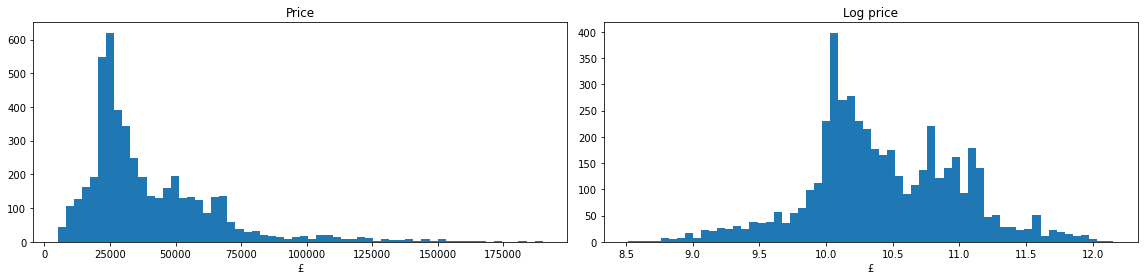

In [29]:
# Have a nosey at the price and mileage distribution

uecars.drop(uecars[uecars.mileage.isnull()].index, inplace=True)
uecars['log_price']=uecars.price.apply(lambda x: np.log(x))
uecars['mileage']=uecars.mileage.apply(lambda x: float(x))
uecars['log_mileage']=uecars.mileage.apply(lambda x: np.log(x))

#mask = np.abs((ncars.price - ncars.price.mean(0)) / ncars.price.std(0)) > 3
#ncars= ncars[~mask]
#ncars.price.plot(kind='hist', bins=50, title='Car Price after outlier removal', xlabel='£');

fig, ax = plt.subplots(ncols=2, figsize=(16,4))
ax[0].hist(uecars.price, bins=60)
ax[1].hist(uecars.log_price, bins=60)
ax[0].set_xlabel('£')
ax[1].set_xlabel('£')
ax[0].set_title('Price')
ax[1].set_title('Log price')
plt.tight_layout()
plt.show()

In [30]:
# Simplify the name column a little. Probably not perfect 

uecars['orig_name'] = uecars.name
uecars['lname']=uecars.name.apply(lambda x: x.lower())

body =["coupe", "convertible", "estate", "hatchback", "MPV", "pickup", 
        "SUV", "saloon","cabriolet","sedan"]
name_list_from_carsized = ['abarth 500', 'acura nsx', 'alfa-romeo 147', 'alfa-romeo 156',
       'alfa-romeo 159', 'alfa-romeo 164', 'alfa-romeo 4c',
       'alfa-romeo giulia', 'alfa-romeo giulietta', 'alfa-romeo mito',
       'alfa-romeo sprint', 'alfa-romeo stelvio', 'alvis tc 108',
       'aston-martin db11', 'aston-martin dbx', 'aston-martin rapide',
       'aston-martin vantage', 'audi 100', 'audi a1', 'audi a2',
       'audi a3', 'audi a4', 'audi a5', 'audi a6', 'audi a7', 'audi a8',
       'audi e tron', 'audi e tron gt', 'audi q2', 'audi q3',
       'audi q4 e tron', 'audi q5', 'audi q7', 'audi q8', 'audi r8',
       'audi tt', 'austin 7', 'austin healey 3000', 'bentley 3 5 litre',
       'bentley bentayga', 'bentley continental flying spur',
       'bentley continental gt', 'bentley flying spur', 'bmw 1 series', 'bmw 2 series',
       'bmw 3 series', 'bmw 4 series', 'bmw 5 series', 'bmw 6 series', 'bmw 7 series', 'bmw 8 series',
       'bmw i3', 'bmw i8', 'bmw isetta', 'bmw ix', 'bmw x1', 'bmw x2',
       'bmw x3', 'bmw x4', 'bmw x5', 'bmw x6', 'bmw x7', 'bmw z4',
       'buick skylark', 'cadillac ats', 'cadillac bls', 'cadillac cts',
       'cadillac eldorado', 'cadillac escalade', 'cadillac seville',
       'cadillac srx', 'cadillac xt5', 'chevrolet aveo',
       'chevrolet bel air', 'chevrolet camaro', 'chevrolet caprice',
       'chevrolet captiva', 'chevrolet corvette', 'chevrolet cruze',
       'chevrolet epica', 'chevrolet equinox', 'chevrolet impala',
       'chevrolet malibu', 'chevrolet matiz', 'chevrolet spark',
       'chevrolet tahoe', 'chrysler 300', 'chrysler pt cruiser',
       'chrysler sebring', 'chrysler voyager', 'citroen b14',
       'citroen berlingo', 'citroen c crosser', 'citroen c elysee',
       'citroen c1', 'citroen c3', 'citroen c3 aircross', 'citroen c4',
       'citroen c4 cactus', 'citroen c4 picasso', 'citroen c5',
       'citroen c5 aircross', 'citroen c8', 'citroen ds', 'citroen ds5',
       'citroen jumpy', 'citroen space tourer', 'cupra ateca',
       'cupra born', 'cupra formentor', 'cupra leon', 'dacia dokker',
       'dacia duster', 'dacia lodgy', 'dacia logan', 'dacia sandero',
       'daewoo lacetti', 'daihatsu sirion', 'daihatsu terios',
       'daimler 250 v8', 'daimler six', 'dodge 880', 'dodge caliber',
       'dodge challenger', 'dodge charger', 'dodge durango',
       'dodge journey', 'dodge nitro', 'dodge ram', 'dodge viper', 'ds 3',
       'ds 3 crossback', 'ds 4', 'ds 7 crossback', 'excalibur series ii',
       'ferrari 458', 'ferrari 488', 'ferrari 512', 'ferrari california',
       'ferrari california t', 'ferrari ff', 'ferrari gtc4lusso',
       'ferrari sf90', 'ferrari testarossa', 'fiat 1100', 'fiat 500',
       'fiat 500l', 'fiat 500x', 'fiat 600', 'fiat bravo', 'fiat croma',
       'fiat freemont', 'fiat fullback', 'fiat panda', 'fiat punto',
       'fiat qubo', 'fiat tipo', 'fisker karma', 'ford b max','fiat ducato'
       'ford c max', 'ford cougar', 'ford ecosport', 'ford edge',
       'ford escape', 'ford explorer', 'ford f150',
       'ford fairlane 500 skyliner', 'ford fiesta', 'ford focus',
       'ford galaxy', 'ford ka', 'ford kuga', 'ford model 48',
       'ford model t', 'ford mondeo', 'ford mustang',
       'ford mustang mach e', 'ford puma', 'ford ranger', 'ford s max',
       'ford scorpio', 'ford taurus', 'ford tourneo',
       'ford tourneo connect', 'ford tourneo courier', 'genesis g70',
       'genesis g80', 'genesis gv70', 'genesis gv80', 'gmc sierra',
       'gmc terrain', 'gmc yukon xl', 'honda accord', 'honda city',
       'honda civic', 'honda cr v', 'honda e', 'honda hr v',
       'honda jazz fit', 'honda nsx', 'honda odyssey', 'honda s',
       'hummer h2', 'hyundai getz', 'hyundai i10', 'hyundai i20',
       'hyundai i30', 'hyundai i40', 'hyundai ioniq', 'hyundai ioniq 5',
       'hyundai ix20', 'hyundai kona', 'hyundai nexo', 'hyundai santa fe',
       'hyundai tiburon', 'hyundai tucson', 'hyundai veloster',
       'infinity fx', 'infinity q30', 'infiniti q50 sedan',
       'infinity qx80', 'isuzu d max', 'jac refine e s2', 'jaguar e pace',
       'jaguar e type', 'jaguar f pace', 'jaguar f type', 'jaguar i pace',
       'jaguar x type', 'jaguar xe', 'jaguar xf', 'jaguar xj',
       'jaguar xk', 'jaguar xk120', 'jeep cherokee', 'jeep compass',
       'jeep wrangler', 'jeep grand cherokee', 'jeep renegade',
       'kia carens', 'kia ceed', 'kia ev6', 'kia magentis', 'kia niro',
       'kia picanto', 'kia rio', 'kia sorento', 'kia soul',
       'kia sportage', 'kia stinger', 'kia stonic', 'kia venga',
       'lada 2102', 'lada 4x4', 'lamborghini aventador',
       'lamborghini huracan', 'lamborghini urus', 'lancia delta',
       'lancia phedra', 'lancia ypsilon', 'land rover defender',
       'land rover discovery', 'land rover discovery sport',
       'land rover freelander', 'land rover range rover',
       'land rover range rover evoque', 'land rover range rover sport',
       'land rover range rover velar', 'lexus ct', 'lexus gs', 'lexus is',
       'lexus ls', 'lexus lx', 'lexus nx', 'lexus rx', 'lexus sc',
       'lexus ux', 'lincoln mkx', 'lincoln navigator', 'lincoln town car',
       'lotus elan', 'lotus elise', 'maserati ghibli',
       'maserati granturismo', 'maserati levante',
       'maserati quattroporte', 'maybach 57', 'mazda 2', 'mazda 3',
       'mazda 5', 'mazda 6', 'mazda cx 3', 'mazda cx 30', 'mazda cx 5',
       'mazda cx 7', 'mazda cx 9', 'mazda mx 30', 'mazda mx 5',
       'mclaren 12c', 'mclaren 650s', 'mclaren 720s', 'mercedes-benz 123',
       'mercedes-benz 170 s', 'mercedes-benz 220', 'mercedes-benz 220 s',
       'mercedes-benz a class', 'mercedes-benz amg gt', 'mercedes-benz b class',
       'mercedes-benz c class', 'mercedes-benz citan', 'mercedes-benz cl class',
       'mercedes-benz cla class', 'mercedes-benz clk class', 'mercedes-benz cls class',
       'mercedes-benz e class', 'mercedes-benz 3', 'mercedes-benz eqa',
       'mercedes-benz eqc class', 'mercedes-benz eqs class', 'mercedes-benz g class',
       'mercedes-benz gl class', 'mercedes-benz gla class', 'mercedes-benz glb class',
       'mercedes-benz glc class', 'mercedes-benz gle class', 'mercedes-benz glk class',
       'mercedes-benz gls class', 'mercedes-benz m class', 'mercedes-benz r class',
       'mercedes-benz s class', 'mercedes-benz sl', 'mercedes-benz slk',
       'mercedes-benz v class', 'mercedes-benz vito', 'mercedes-benz w114',
       'mercedes-benz x class', 'mercury cougar', 'mg f', 'mg mgb', 'mg tf',
       'mini clubman', 'mini cooper', 'mini countryman', 'mini paceman',
       'mitsubishi asx', 'mitsubishi colt', 'mitsubishi i miev',
       'mitsubishi l200', 'mitsubishi lancer', 'mitsubishi mirage',
       'mitsubishi outlander', 'mitsubishi pajero', 'moskvitch 400',
       'nissan 370z', 'nissan altima', 'nissan juke', 'nissan leaf',
       'nissan micra', 'nissan murano', 'nissan navara', 'nissan note',
       'nissan nv200', 'nissan pathfinder', 'nissan pixo',
       'nissan qashqai', 'nissan x trail', 'oldsmobile 88',
       'oldsmobile cutlass supreme', 'vauxhall adam', 'vauxhall agila',
       'vauxhall ampera', 'vauxhall astra', 'vauxhall calibra', 'vauxhall cascada',
       'vauxhall corsa', 'vauxhall crossland x', 'vauxhall grandland',
       'vauxhall insignia', 'vauxhall karl', 'vauxhall meriva', 'vauxhall mokka',
       'vauxhall tigra', 'vauxhall vectra', 'vauxhall zafira', 'peugeot 1007',
       'peugeot 108', 'peugeot 206', 'peugeot 207', 'peugeot 208', 'peugeot 2008'
       'peugeot 3008', 'peugeot 306', 'peugeot 307', 'peugeot 308',
       'peugeot 4007', 'peugeot 4008', 'peugeot 406', 'peugeot 407',
       'peugeot 5008', 'peugeot 508', 'peugeot 807', 'peugeot expert',
       'peugeot partner', 'peugeot traveller', 'plymouth volare',
       'polestar 2', 'pontiac firebird', 'pontiac gto', 'porsche 356',
       'porsche 718', 'porsche 718 cayman', 'porsche 911', 'porsche 928',
       'porsche cayenne 5 door coupe suv', 'porsche cayenne',
       'porsche macan', 'porsche panamera', 'porsche taycan',
       'renault captur', 'renault clio', 'renault espace',
       'renault fluence', 'renault fuego', 'renault kadjar',
       'renault kangoo', 'renault koleos', 'renault laguna',
       'renault megane', 'renault modus', 'renault scenic',
       'renault talisman', 'renault twingo', 'renault twizy',
       'renault zoe', 'rolls-royce corniche', 'rolls-royce cullinan',
       'rolls-royce ghost', 'rolls-royce phantom',
       'rolls-royce silver shadow', 'rolls-royce silver spirit',
       'rolls-royce wraith', 'rover sd1', 'saab 9 3', 'saab 9 5',
       'seat alhambra', 'seat altea', 'seat arona', 'seat ateca',
       'seat exeo', 'seat ibiza', 'seat leon', 'seat mii', 'seat tarraco',
       'skoda citigo', 'skoda enyaq iv', 'skoda fabia', 'skoda kamiq',
       'skoda karoq', 'skoda kodiaq', 'skoda octavia', 'skoda rapid',
       'skoda scala', 'skoda superb', 'skoda yeti', 'smart forfour',
       'smart fortwo', 'smart roadster', 'ssang yong korando',
       'ssang yong kyron', 'ssang yong rexton', 'ssang yong tivoli',
       'subaru forester', 'subaru impreza', 'subaru justy',
       'subaru legacy', 'subaru levorg', 'subaru outback',
       'subaru xv crosstrek', 'suzuki across', 'suzuki ignis',
       'suzuki jimny', 'suzuki liana', 'suzuki swift', 'suzuki sx4',
       'suzuki vitara', 'tatra 603', 'tesla model 3', 'tesla model s',
       'tesla model x', 'tesla model y', 'toyota auris', 'toyota avensis',
       'toyota aygo', 'toyota c hr', 'toyota celica', 'toyota corolla',
       'toyota corolla verso', 'toyota gt 86', 'toyota highlander',
       'toyota hilux', 'toyota iq', 'toyota land cruiser prado',
       'toyota landcruiser', 'toyota previa', 'toyota prius',
       'toyota prius plus', 'toyota proace verso', 'toyota rav4',
       'toyota sienna', 'toyota supra', 'toyota tundra',
       'toyota urban cruiser', 'toyota verso', 'toyota yaris',
       'toyota yaris cross', 'triumph spitfire', 'triumph tr7',
       'tvr cerbera', 'volkswagen 1600', 'volkswagen amarok',
       'volkswagen arteon', 'volkswagen beetle', 'volkswagen bora',
       'volkswagen caddy', 'volkswagen california',
       'volkswagen caravelle', 'volkswagen eos', 'volkswagen fox',
       'volkswagen golf', 'volkswagen id3', 'volkswagen id4',
       'volkswagen jetta', 'volkswagen passat', 'volkswagen passat cc',
       'volkswagen phaeton', 'volkswagen polo', 'volkswagen scirocco',
       'volkswagen sharan', 'volkswagen t cross', 'volkswagen t roc',
       'volkswagen tiguan', 'volkswagen touareg', 'volkswagen touran',
       'volkswagen up', 'volvo 780', 'volvo 900', 'volvo c30',
       'volvo s60', 'volvo s80', 'volvo s90', 'volvo v40', 'volvo v50',
       'volvo v60', 'volvo v70', 'volvo v90', 'volvo xc40', 'volvo xc60',
       'volvo xc70', 'volvo xc90', 'wartburg 353']

results = []
for index, car in uecars.iterrows():
    lname = car[-1]
    dummy = lname
    for cname in name_list_from_carsized:
        if cname in lname:
            dummy = cname
    for bod in body:
        if bod in dummy:
            dummy = re.sub(' '+bod,'',dummy)
    results.append(dummy)

uecars['name']=results
uecars=uecars.drop('lname', axis=1)

uecars.shape

(4740, 28)

In [31]:
# Output clean used cars data 
uecars=uecars[['name','name_subtitle','year','price','body','mileage','BHP','doors'
            ,'transmission','make','fuel','mpg','drivertrain','engine','owners'
            ,'ULEZ','dealer_area','dealer_city','seller1','used', 'e_engine_kWh'
            ,'log_price','log_mileage','orig_name','id','year_reg','link','href0']]
uecars_abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/00_clean_used_electric_cars.csv'
uecars.to_csv(uecars_abspath, index=False, header=uecars.columns )

In [32]:
uecars.mpg.value_counts()

Electric    4740
Name: mpg, dtype: int64

In [33]:
uecars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4740 entries, 0 to 4886
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           4740 non-null   object 
 1   name_subtitle  4740 non-null   object 
 2   year           4740 non-null   int64  
 3   price          4740 non-null   float64
 4   body           4740 non-null   object 
 5   mileage        4740 non-null   float64
 6   BHP            4740 non-null   float64
 7   doors          4740 non-null   object 
 8   transmission   4740 non-null   object 
 9   make           4740 non-null   object 
 10  fuel           4740 non-null   object 
 11  mpg            4740 non-null   object 
 12  drivertrain    4740 non-null   object 
 13  engine         0 non-null      float64
 14  owners         4740 non-null   int64  
 15  ULEZ           4740 non-null   object 
 16  dealer_area    3880 non-null   object 
 17  dealer_city    4740 non-null   object 
 18  seller1 

## New cars - not electric

In [34]:
# Import all detailed files and make new ncars df, including year

path = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/raw/df_detailed/'

li=[]
year_files = glob.glob(path + f"/*2023_new.csv")
#print(len(year_files),'file(s) to load from', year)
for filename in year_files:
    df = pd.read_csv(filename, index_col=None, header=0 )
    df['YR'] = '2022 new'
    df.drop_duplicates(subset=['link'], keep='first', inplace=True)
    li.append(df)

ncars = pd.concat(li, axis=0, ignore_index=True)
ncars.drop_duplicates(subset=['link'], keep='first', inplace=True)
ncars.shape  

(18906, 20)

In [35]:
#Clean ncars.body

#Create df of ncars will null body
nabody = ncars[ncars['body'].isnull()].copy()

#Encode body column but don't overwrite
to_encode = ['body']
ncars_e = ncars.copy()
for col in to_encode:
    le = LabelEncoder()
    ncars_e[col] = le.fit_transform(ncars_e[col]) 

#Iterate through null-body ncars and replace with corresponding modal body value based on name column grouping
for index, car in nabody.iterrows():
    carname=nabody.loc[index,'name']
    body=nabody.loc[index,'body']
    nabody.loc[index,'body'] = ncars_e[ncars_e['name']==carname].body.mode()[0]
    ncars_e.loc[index,'body'] = ncars_e[ncars_e['name']==carname].body.mode()[0]     

#Reverse the encoding    
for col in to_encode:
    ncars[col] = le.inverse_transform(ncars_e[col]) 

#After checking the remaining ncars without a body, it is clear that they are all vans!    
ncars.body = ['Van' if pd.Series(x).isnull()[0]==True else x for x in ncars.body]        

ncars.shape

(18906, 20)

In [36]:
#Clean ncars.BHP, taking values from ncars.engine where necessary. Drop remaining NaN.

# Unmerge some of the BHP entries which have engine size in there too.
for index, car in ncars[ncars['BHP'].str.contains('L', regex=True, na=False)].iterrows():
    ncars.loc[index, 'engine'] = str(ncars.loc[index, 'BHP']).split(' ')[0]
    ncars.loc[index, 'BHP'] = str(ncars.loc[index, 'BHP']).split(' ')[1].strip('()') 

# Drop NaN BHP
ncars.dropna(subset=['BHP'],inplace=True)

def standardise_bhp(x):
    lenbhp = len(str(x).split(' '))
    bhp=x
    if lenbhp == 1:
        if 'BHP' in x:
            bhp=float(re.findall('[0-9]+', x)[0])       
        elif 'PS' in x:
            ps=float(re.findall('[0-9]+', x)[0])
            bhp = ps/1.014        
    elif lenbhp == 2:
        x=str(x.split(' ')[-1])
        if 'BHP' in x:
            bhp=float(re.findall('[0-9]+', x)[0])      
        elif 'PS' in x:
            ps=float(re.findall('[0-9]+', x)[0])
            bhp = ps/1.014
    else:
        bhp=np.nan   
    return bhp    

#Standardise remaining BHP (convert from PS)
ncars.BHP = ncars.BHP.apply(lambda x: standardise_bhp(x))

ncars.shape

(18890, 20)

In [37]:
#Compile the best location variable. Retain dealer_city and dealer_area. Don't drop remaining NaN.

#split href0 into city and area
ncars['dealer_city_temp'] = [x.split('/')[3] if type(x)==str and len(x.split('/'))>3 else x for x in ncars.href0]
ncars['dealer_area'] = [x.split('/')[2] if type(x)==str and len(x.split('/'))>3 else x for x in ncars.href0]

#If there are some seller ratings in seller0, move them to seller1
ncars[ncars['seller0'].str.contains('[+-]?([0-9]*[.])?[0-9]+', regex=True, na=False)].seller1 = ncars[ncars['seller0'].str.contains('[+-]?([0-9]*[.])?[0-9]+', regex=True, na=False)].seller0

#Make seller ratings in seller0 np.nan
ncars.seller0 =[np.nan if '4' in str(x) or '5' in str(x) else x for x in ncars.seller0]

#If the seller0 column is np.nan, use the dealer_city 
for index, car in ncars.iterrows():
    if pd.isnull(ncars.loc[index,'seller0']):
        ncars.loc[index,'seller0']=ncars.loc[index,'dealer_city_temp']
        
ncars['dealer_city'] = ncars['seller0']
ncars.drop(['seller0','dealer_city_temp'],inplace=True, axis=1)

ncars.shape

/var/folders/1h/l422441d07d4l2q1nfyrjk740000gn/T/ipykernel_18360/1268207855.py:8: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  ncars[ncars['seller0'].str.contains('[+-]?([0-9]*[.])?[0-9]+', regex=True, na=False)].seller1 = ncars[ncars['seller0'].str.contains('[+-]?([0-9]*[.])?[0-9]+', regex=True, na=False)].seller0


(18890, 21)

In [38]:
# Iterate over missing engine rows and use regex name_subtitle to extract engine size where possible. Convert to float

for index, car in ncars[ncars['engine'].isnull()].iterrows():
    car_subname = ncars.loc[index, 'name_subtitle']
    try:
        enginesize = re.findall('([0-9][.][0-9]+)',car_subname)[0]
    except: 
        enginesize = np.nan
    ncars.loc[index,'engine'] = float(enginesize)
    
ncars.engine= ncars.engine.apply(lambda x: float(str(x).replace('L','')))
ncars.dropna(subset=['engine'],inplace=True)

ncars.shape

(18890, 21)

In [39]:
# Make doors column

def extract_drs(x):
    drs = re.findall('( [1-8]d[Rr]?)',x, re.I)
    if len(drs) > 0:
        drs = str(drs[0]).lower()
    else:
        drs = re.findall('([1-8][ ]?door)',x, re.I)
        if len(drs) > 0:
            drs = str(drs[0])[0]+'dr'
        else:
            drs = re.findall('([1-8]dr)',x, re.I)
            if len(drs) > 0:
                drs = str(drs[0])[0]+'dr'
            else:
                drs = re.findall('(D-4D)',x, re.I)
                if len(drs) > 0:
                    drs = '4dr'
                else:
                    drs='0dr'
                
    if ('r' or 'R') not in drs:
        drs = drs.replace('d','dr')
    return drs.strip()
     
ncars['doors'] = ncars.name_subtitle.apply(lambda x: extract_drs(x))

#Create df of ncars with 0 doors
zerodoors = ncars[ncars['doors']=='0dr'].copy()

#Encode doors column but don't overwrite
to_encode = ['doors']
ncars_e = ncars.copy()
for col in to_encode:
    le = LabelEncoder()
    ncars_e[col] = le.fit_transform(ncars_e[col]) 

#Iterate through zero door ncars and replace with corresponding num doors based on name column grouping
for index, car in zerodoors.iterrows():
    carname=zerodoors.loc[index,'name']
    ncars_e.loc[index,'doors'] = ncars_e[ncars_e['name']==carname].doors.mode()[0]     

#Reverse the encoding    
for col in to_encode:
    ncars[col] = le.inverse_transform(ncars_e[col]) 

#Drop the remaining 226 ncars without door information    
ncars.dropna(subset=['doors'],inplace=True)
    
ncars.shape

(18890, 22)

In [40]:
# Clean ncars.mileage

#Drop them - only 283
ncars.mileage = '0'

ncars.shape

(18890, 22)

In [41]:
# Clean ncars.fuel

#Drop them - only 12
ncars.dropna(subset=['fuel'],inplace=True)

ncars.shape

(18890, 22)

In [42]:
# Clean ncars.price, make ncars.ID, clean ncars.year 

to_dummy=['mpg','drivetrain','make','body','transmission','fuel']

ncars.price=ncars.price.apply(lambda x: x.replace('£',''))
ncars.price=ncars.price.apply(lambda x: float(x.replace(',','')))
ncars['id'] =[x.split('/')[-1] for x in ncars.link]
ncars['year_reg']=ncars.year
ncars['year']= 2022
ncars.drop('YR',inplace=True, axis=1)

ncars.shape

(18890, 23)

In [43]:
#Obtain ncars.ll_search <-- Doesn't actually work with nominatim openstreetmap. Probably not needed.

# ncars['ll_search']=''
# ll_search_series = []
# for index, car in tqdm(ncars.iterrows()):
#     dc = str(car[19])
#     da = str(car[18])
#     if dc == 'nan':
#         dc = ''
#     if da == 'nan':
#         da = ''
#     car[23] = dc+' '+da
#     ll_search_series.append(car[23])
# ncars['ll_search'] = ll_search_series


In [44]:
#Iterate over ncars to convert dealer_city to lat/lon. 2s per car makes this a 2+day cell. Running in other workbook. 

# lat_series = []
# lon_series = []

# for index, car in tqdm(ncars.iterrows()):
#     address = car[19] + ' UK'
#     url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address) +'?format=json'
#     response = requests.get(url).json()
#     lat_series.append(response[0]["lat"])
#     lon_series.append(response[0]["lon"])
    
# ncars['seller_lat']=lat_series
# ncars['seller_lon']=lon_series
    

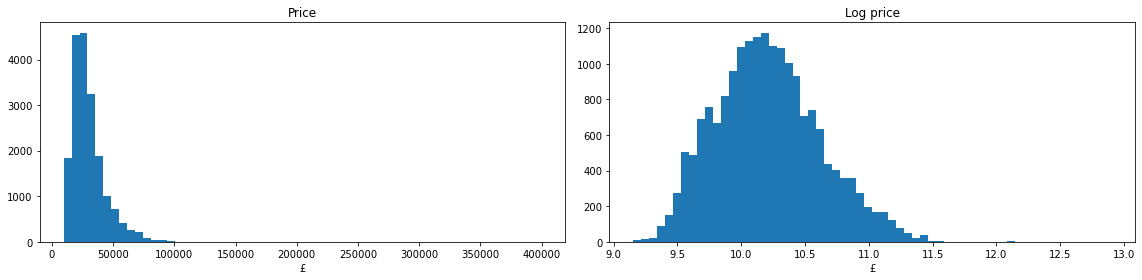

In [45]:
# Have a nosey at the price and mileage distribution

ncars['log_price']=ncars.price.apply(lambda x: np.log(x))
ncars['mileage']=ncars.mileage.apply(lambda x: float(x))
ncars['log_mileage']=ncars.mileage.apply(lambda x: np.log(x))

#mask = np.abs((ncars.price - ncars.price.mean(0)) / ncars.price.std(0)) > 3
#ncars= ncars[~mask]
#ncars.price.plot(kind='hist', bins=50, title='Car Price after outlier removal', xlabel='£');

fig, ax = plt.subplots(ncols=2, figsize=(16,4))
ax[0].hist(ncars.price, bins=60)
ax[1].hist(ncars.log_price, bins=60)
ax[0].set_xlabel('£')
ax[1].set_xlabel('£')
ax[0].set_title('Price')
ax[1].set_title('Log price')
plt.tight_layout()
plt.show()

In [46]:
# Simplify the name column a little. Probably not perfect 

ncars['orig_name'] = ncars.name
ncars['lname']=ncars.name.apply(lambda x: x.lower())

body =["coupe", "convertible", "estate", "hatchback", "MPV", "pickup", 
       "SUV", "saloon","cabriolet","sedan"]
name_list_from_carsized = ['abarth 500', 'acura nsx', 'alfa-romeo 147', 'alfa-romeo 156',
       'alfa-romeo 159', 'alfa-romeo 164', 'alfa-romeo 4c',
       'alfa-romeo giulia', 'alfa-romeo giulietta', 'alfa-romeo mito',
       'alfa-romeo sprint', 'alfa-romeo stelvio', 'alvis tc 108',
       'aston-martin db11', 'aston-martin dbx', 'aston-martin rapide',
       'aston-martin vantage', 'audi 100', 'audi a1', 'audi a2',
       'audi a3', 'audi a4', 'audi a5', 'audi a6', 'audi a7', 'audi a8',
       'audi e tron', 'audi e tron gt', 'audi q2', 'audi q3',
       'audi q4 e tron', 'audi q5', 'audi q7', 'audi q8', 'audi r8',
       'audi tt', 'austin 7', 'austin healey 3000', 'bentley 3 5 litre',
       'bentley bentayga', 'bentley continental flying spur',
       'bentley continental gt', 'bentley flying spur', 'bmw 1 series', 'bmw 2 series',
       'bmw 3 series', 'bmw 4 series', 'bmw 5 series', 'bmw 6 series', 'bmw 7 series', 'bmw 8 series',
       'bmw i3', 'bmw i8', 'bmw isetta', 'bmw ix', 'bmw x1', 'bmw x2',
       'bmw x3', 'bmw x4', 'bmw x5', 'bmw x6', 'bmw x7', 'bmw z4',
       'buick skylark', 'cadillac ats', 'cadillac bls', 'cadillac cts',
       'cadillac eldorado', 'cadillac escalade', 'cadillac seville',
       'cadillac srx', 'cadillac xt5', 'chevrolet aveo',
       'chevrolet bel air', 'chevrolet camaro', 'chevrolet caprice',
       'chevrolet captiva', 'chevrolet corvette', 'chevrolet cruze',
       'chevrolet epica', 'chevrolet equinox', 'chevrolet impala',
       'chevrolet malibu', 'chevrolet matiz', 'chevrolet spark',
       'chevrolet tahoe', 'chrysler 300', 'chrysler pt cruiser',
       'chrysler sebring', 'chrysler voyager', 'citroen b14',
       'citroen berlingo', 'citroen c crosser', 'citroen c elysee',
       'citroen c1', 'citroen c3', 'citroen c3 aircross', 'citroen c4',
       'citroen c4 cactus', 'citroen c4 picasso', 'citroen c5',
       'citroen c5 aircross', 'citroen c8', 'citroen ds', 'citroen ds5',
       'citroen jumpy', 'citroen space tourer', 'cupra ateca',
       'cupra born', 'cupra formentor', 'cupra leon', 'dacia dokker',
       'dacia duster', 'dacia lodgy', 'dacia logan', 'dacia sandero',
       'daewoo lacetti', 'daihatsu sirion', 'daihatsu terios',
       'daimler 250 v8', 'daimler six', 'dodge 880', 'dodge caliber',
       'dodge challenger', 'dodge charger', 'dodge durango',
       'dodge journey', 'dodge nitro', 'dodge ram', 'dodge viper', 'ds 3',
       'ds 3 crossback', 'ds 4', 'ds 7 crossback', 'excalibur series ii',
       'ferrari 458', 'ferrari 488', 'ferrari 512', 'ferrari california',
       'ferrari california t', 'ferrari ff', 'ferrari gtc4lusso',
       'ferrari sf90', 'ferrari testarossa', 'fiat 1100', 'fiat 500',
       'fiat 500l', 'fiat 500x', 'fiat 600', 'fiat bravo', 'fiat croma',
       'fiat freemont', 'fiat fullback', 'fiat panda', 'fiat punto',
       'fiat qubo', 'fiat tipo', 'fisker karma', 'ford b max','fiat ducato'
       'ford c max', 'ford cougar', 'ford ecosport', 'ford edge',
       'ford escape', 'ford explorer', 'ford f150',
       'ford fairlane 500 skyliner', 'ford fiesta', 'ford focus',
       'ford galaxy', 'ford ka', 'ford kuga', 'ford model 48',
       'ford model t', 'ford mondeo', 'ford mustang',
       'ford mustang mach e', 'ford puma', 'ford ranger', 'ford s max',
       'ford scorpio', 'ford taurus', 'ford tourneo',
       'ford tourneo connect', 'ford tourneo courier', 'genesis g70',
       'genesis g80', 'genesis gv70', 'genesis gv80', 'gmc sierra',
       'gmc terrain', 'gmc yukon xl', 'honda accord', 'honda city',
       'honda civic', 'honda cr v', 'honda e', 'honda hr v',
       'honda jazz fit', 'honda nsx', 'honda odyssey', 'honda s',
       'hummer h2', 'hyundai getz', 'hyundai i10', 'hyundai i20',
       'hyundai i30', 'hyundai i40', 'hyundai ioniq', 'hyundai ioniq 5',
       'hyundai ix20', 'hyundai kona', 'hyundai nexo', 'hyundai santa fe',
       'hyundai tiburon', 'hyundai tucson', 'hyundai veloster',
       'infinity fx', 'infinity q30', 'infiniti q50 sedan',
       'infinity qx80', 'isuzu d max', 'jac refine e s2', 'jaguar e pace',
       'jaguar e type', 'jaguar f pace', 'jaguar f type', 'jaguar i pace',
       'jaguar x type', 'jaguar xe', 'jaguar xf', 'jaguar xj',
       'jaguar xk', 'jaguar xk120', 'jeep cherokee', 'jeep compass',
       'jeep wrangler', 'jeep grand cherokee', 'jeep renegade',
       'kia carens', 'kia ceed', 'kia ev6', 'kia magentis', 'kia niro',
       'kia picanto', 'kia rio', 'kia sorento', 'kia soul',
       'kia sportage', 'kia stinger', 'kia stonic', 'kia venga',
       'lada 2102', 'lada 4x4', 'lamborghini aventador',
       'lamborghini huracan', 'lamborghini urus', 'lancia delta',
       'lancia phedra', 'lancia ypsilon', 'land rover defender',
       'land rover discovery', 'land rover discovery sport',
       'land rover freelander', 'land rover range rover',
       'land rover range rover evoque', 'land rover range rover sport',
       'land rover range rover velar', 'lexus ct', 'lexus gs', 'lexus is',
       'lexus ls', 'lexus lx', 'lexus nx', 'lexus rx', 'lexus sc',
       'lexus ux', 'lincoln mkx', 'lincoln navigator', 'lincoln town car',
       'lotus elan', 'lotus elise', 'maserati ghibli',
       'maserati granturismo', 'maserati levante',
       'maserati quattroporte', 'maybach 57', 'mazda 2', 'mazda 3',
       'mazda 5', 'mazda 6', 'mazda cx 3', 'mazda cx 30', 'mazda cx 5',
       'mazda cx 7', 'mazda cx 9', 'mazda mx 30', 'mazda mx 5',
       'mclaren 12c', 'mclaren 650s', 'mclaren 720s', 'mercedes-benz 123',
       'mercedes-benz 170 s', 'mercedes-benz 220', 'mercedes-benz 220 s',
       'mercedes-benz a class', 'mercedes-benz amg gt', 'mercedes-benz b class',
       'mercedes-benz c class', 'mercedes-benz citan', 'mercedes-benz cl class',
       'mercedes-benz cla class', 'mercedes-benz clk class', 'mercedes-benz cls class',
       'mercedes-benz e class', 'mercedes-benz 3', 'mercedes-benz eqa',
       'mercedes-benz eqc class', 'mercedes-benz eqs class', 'mercedes-benz g class',
       'mercedes-benz gl class', 'mercedes-benz gla class', 'mercedes-benz glb class',
       'mercedes-benz glc class', 'mercedes-benz gle class', 'mercedes-benz glk class',
       'mercedes-benz gls class', 'mercedes-benz m class', 'mercedes-benz r class',
       'mercedes-benz s class', 'mercedes-benz sl', 'mercedes-benz slk',
       'mercedes-benz v class', 'mercedes-benz vito', 'mercedes-benz w114',
       'mercedes-benz x class', 'mercury cougar', 'mg f', 'mg mgb', 'mg tf',
       'mini clubman', 'mini cooper', 'mini countryman', 'mini paceman',
       'mitsubishi asx', 'mitsubishi colt', 'mitsubishi i miev',
       'mitsubishi l200', 'mitsubishi lancer', 'mitsubishi mirage',
       'mitsubishi outlander', 'mitsubishi pajero', 'moskvitch 400',
       'nissan 370z', 'nissan altima', 'nissan juke', 'nissan leaf',
       'nissan micra', 'nissan murano', 'nissan navara', 'nissan note',
       'nissan nv200', 'nissan pathfinder', 'nissan pixo',
       'nissan qashqai', 'nissan x trail', 'oldsmobile 88',
       'oldsmobile cutlass supreme', 'vauxhall adam', 'vauxhall agila',
       'vauxhall ampera', 'vauxhall astra', 'vauxhall calibra', 'vauxhall cascada',
       'vauxhall corsa', 'vauxhall crossland x', 'vauxhall grandland',
       'vauxhall insignia', 'vauxhall karl', 'vauxhall meriva', 'vauxhall mokka',
       'vauxhall tigra', 'vauxhall vectra', 'vauxhall zafira', 'peugeot 1007',
       'peugeot 108', 'peugeot 206', 'peugeot 207', 'peugeot 208', 'peugeot 2008'
       'peugeot 3008', 'peugeot 306', 'peugeot 307', 'peugeot 308',
       'peugeot 4007', 'peugeot 4008', 'peugeot 406', 'peugeot 407',
       'peugeot 5008', 'peugeot 508', 'peugeot 807', 'peugeot expert',
       'peugeot partner', 'peugeot traveller', 'plymouth volare',
       'polestar 2', 'pontiac firebird', 'pontiac gto', 'porsche 356',
       'porsche 718', 'porsche 718 cayman', 'porsche 911', 'porsche 928',
       'porsche cayenne 5 door coupe suv', 'porsche cayenne',
       'porsche macan', 'porsche panamera', 'porsche taycan',
       'renault captur', 'renault clio', 'renault espace',
       'renault fluence', 'renault fuego', 'renault kadjar',
       'renault kangoo', 'renault koleos', 'renault laguna',
       'renault megane', 'renault modus', 'renault scenic',
       'renault talisman', 'renault twingo', 'renault twizy',
       'renault zoe', 'rolls-royce corniche', 'rolls-royce cullinan',
       'rolls-royce ghost', 'rolls-royce phantom',
       'rolls-royce silver shadow', 'rolls-royce silver spirit',
       'rolls-royce wraith', 'rover sd1', 'saab 9 3', 'saab 9 5',
       'seat alhambra', 'seat altea', 'seat arona', 'seat ateca',
       'seat exeo', 'seat ibiza', 'seat leon', 'seat mii', 'seat tarraco',
       'skoda citigo', 'skoda enyaq iv', 'skoda fabia', 'skoda kamiq',
       'skoda karoq', 'skoda kodiaq', 'skoda octavia', 'skoda rapid',
       'skoda scala', 'skoda superb', 'skoda yeti', 'smart forfour',
       'smart fortwo', 'smart roadster', 'ssang yong korando',
       'ssang yong kyron', 'ssang yong rexton', 'ssang yong tivoli',
       'subaru forester', 'subaru impreza', 'subaru justy',
       'subaru legacy', 'subaru levorg', 'subaru outback',
       'subaru xv crosstrek', 'suzuki across', 'suzuki ignis',
       'suzuki jimny', 'suzuki liana', 'suzuki swift', 'suzuki sx4',
       'suzuki vitara', 'tatra 603', 'tesla model 3', 'tesla model s',
       'tesla model x', 'tesla model y', 'toyota auris', 'toyota avensis',
       'toyota aygo', 'toyota c hr', 'toyota celica', 'toyota corolla',
       'toyota corolla verso', 'toyota gt 86', 'toyota highlander',
       'toyota hilux', 'toyota iq', 'toyota land cruiser prado',
       'toyota landcruiser', 'toyota previa', 'toyota prius',
       'toyota prius plus', 'toyota proace verso', 'toyota rav4',
       'toyota sienna', 'toyota supra', 'toyota tundra',
       'toyota urban cruiser', 'toyota verso', 'toyota yaris',
       'toyota yaris cross', 'triumph spitfire', 'triumph tr7',
       'tvr cerbera', 'volkswagen 1600', 'volkswagen amarok',
       'volkswagen arteon', 'volkswagen beetle', 'volkswagen bora',
       'volkswagen caddy', 'volkswagen california',
       'volkswagen caravelle', 'volkswagen eos', 'volkswagen fox',
       'volkswagen golf', 'volkswagen id3', 'volkswagen id4',
       'volkswagen jetta', 'volkswagen passat', 'volkswagen passat cc',
       'volkswagen phaeton', 'volkswagen polo', 'volkswagen scirocco',
       'volkswagen sharan', 'volkswagen t cross', 'volkswagen t roc',
       'volkswagen tiguan', 'volkswagen touareg', 'volkswagen touran',
       'volkswagen up', 'volvo 780', 'volvo 900', 'volvo c30',
       'volvo s60', 'volvo s80', 'volvo s90', 'volvo v40', 'volvo v50',
       'volvo v60', 'volvo v70', 'volvo v90', 'volvo xc40', 'volvo xc60',
       'volvo xc70', 'volvo xc90', 'wartburg 353']

results = []
for index, car in ncars.iterrows():
    lname = car[-1]
    dummy = lname
    for cname in name_list_from_carsized:
        if cname in lname:
            dummy = cname
    for bod in body:
        if bod in dummy:
            dummy = re.sub(' '+bod,'',dummy)
    results.append(dummy)
results

ncars['name']=results
ncars=ncars.drop('lname', axis=1)

ncars.shape

(18890, 26)

In [47]:
# Add ncars.used and ncars.e_engine_kWh columns to be compatible with other datasets 

ncars['used']=0
ncars['e_engine_kWh']= np.nan

ncars.shape

(18890, 28)

In [48]:
# Output clean used cars data 
ncars=ncars[['name','name_subtitle','year','price','body','mileage','BHP','doors'
            ,'transmission','make','fuel','mpg','drivertrain','engine','owners'
            ,'ULEZ','dealer_area','dealer_city','seller1','used', 'e_engine_kWh'
            ,'log_price','log_mileage','orig_name','id','year_reg','link','href0']]
ncars_abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/00_clean_new_cars.csv'
ncars.to_csv(ncars_abspath, index=False, header=ncars.columns )

In [49]:
ncars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18890 entries, 0 to 50386
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           18890 non-null  object 
 1   name_subtitle  18890 non-null  object 
 2   year           18890 non-null  int64  
 3   price          18890 non-null  float64
 4   body           18890 non-null  object 
 5   mileage        18890 non-null  float64
 6   BHP            18890 non-null  float64
 7   doors          18890 non-null  object 
 8   transmission   18890 non-null  object 
 9   make           18890 non-null  object 
 10  fuel           18890 non-null  object 
 11  mpg            18890 non-null  object 
 12  drivertrain    18890 non-null  object 
 13  engine         18890 non-null  float64
 14  owners         0 non-null      float64
 15  ULEZ           18780 non-null  object 
 16  dealer_area    16203 non-null  object 
 17  dealer_city    18686 non-null  object 
 18  seller

## New cars - electric

In [50]:
# Import all detailed files and make new ncars df, including year

path = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/raw/df_detailed_ev/'

li=[]
year_files = glob.glob(path + f"/*2023_electric_new.csv")
#print(len(year_files),'file(s) to load from', year)
for filename in year_files:
    df = pd.read_csv(filename, index_col=None, header=0 )
    df['YR'] = '2022 new'
    df.drop_duplicates(subset=['link'], keep='first', inplace=True)
    li.append(df)

necars = pd.concat(li, axis=0, ignore_index=True)
necars.drop_duplicates(subset=['link'], keep='first', inplace=True)
necars.shape  

(2816, 20)

In [51]:
# Body is fine. No cleaning needed.

necars.shape

(2816, 20)

In [52]:
# Clean BHP.

# Drop NaN BHP
necars.dropna(subset=['BHP'],inplace=True)

def standardise_bhp(x):
    lenbhp = len(str(x).split(' '))
    bhp=x
    if lenbhp == 1:
        if 'BHP' in x:
            bhp=float(re.findall('[0-9]+', x)[0])       
        elif 'PS' in x:
            ps=float(re.findall('[0-9]+', x)[0])
            bhp = ps/1.014        
    elif lenbhp == 2:
        x=str(x.split(' ')[-1])
        if 'BHP' in x:
            bhp=float(re.findall('[0-9]+', x)[0])      
        elif 'PS' in x:
            ps=float(re.findall('[0-9]+', x)[0])
            bhp = ps/1.014
    else:
        bhp=np.nan   
    return bhp    

#Standardise remaining BHP (convert from PS)
necars.BHP = necars.BHP.apply(lambda x: standardise_bhp(x))

necars.shape

(2768, 20)

In [53]:
#Compile the best location variable. Retain dealer_city and dealer_area. Don't drop remaining NaN.

#split href0 into city and area
necars['dealer_city_temp'] = [x.split('/')[3] if type(x)==str and len(x.split('/'))>3 else x for x in necars.href0]
necars['dealer_area'] = [x.split('/')[2] if type(x)==str and len(x.split('/'))>3 else x for x in necars.href0]

#If there are some seller ratings in seller0, move them to seller1
necars[necars['seller0'].str.contains('[+-]?([0-9]*[.])?[0-9]+', regex=True, na=False)].seller1 = necars[necars['seller0'].str.contains('[+-]?([0-9]*[.])?[0-9]+', regex=True, na=False)].seller0

#Make seller ratings in seller0 np.nan
necars.seller0 =[np.nan if '4' in str(x) or '5' in str(x) else x for x in necars.seller0]

#If the seller0 column is np.nan, use the dealer_city 
for index, car in necars.iterrows():
    if pd.isnull(necars.loc[index,'seller0']):
        necars.loc[index,'seller0']=necars.loc[index,'dealer_city_temp']
    #Tiny number of cars don't have a location, and they're all from one dealer in Oldbury.    
    if pd.isnull(necars.loc[index,'seller0']):
        necars.loc[index,'seller0']= 'Oldbury'
        
necars['dealer_city'] = necars['seller0']
necars.drop(['seller0','dealer_city_temp'],inplace=True, axis=1)

necars.shape

/var/folders/1h/l422441d07d4l2q1nfyrjk740000gn/T/ipykernel_18360/3195580599.py:8: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  necars[necars['seller0'].str.contains('[+-]?([0-9]*[.])?[0-9]+', regex=True, na=False)].seller1 = necars[necars['seller0'].str.contains('[+-]?([0-9]*[.])?[0-9]+', regex=True, na=False)].seller0


(2768, 21)

In [54]:
# Populate necars.e_engine_kWh from name_subtitle ~20% NaN. Not great but BHP supersedes it.

necars['e_engine_kWh']=''
necars['engine']=np.nan

for index, car in necars.iterrows():
    car_subname = necars.loc[index, 'name_subtitle']
    try:
        eenginesize = re.findall('[\d]+[.]?[\d]+[ ]?kwh',car_subname, flags=re.I)[0]
    except: 
        eenginesize = np.nan
    necars.loc[index,'e_engine_kWh'] = eenginesize
    
necars.e_engine_kWh= necars.e_engine_kWh.apply(lambda x: float(str(x).lower().replace('kwh','')))
#necars.dropna(subset=['engine'],inplace=True)

necars.shape

(2768, 22)

In [55]:
# Make doors column. Drop 4 without info. 
     
necars['doors'] = necars.name_subtitle.apply(lambda x: extract_drs(x))

# Drop the remaining 4 necars without door information    
necars.drop(necars[necars.doors=='0dr'].index, inplace=True)

necars.shape

(2764, 23)

In [56]:
# Clean necars.price, make necars.ID, clean necars.year 
to_dummy=['mpg','drivetrain','make','body','transmission','fuel']

necars.price=necars.price.apply(lambda x: x.replace('£',''))
necars.price=necars.price.apply(lambda x: float(x.replace(',','')))
necars['id'] =[x.split('/')[-1] for x in necars.link]
necars['year_reg']=necars.YR
necars['year']=2022
necars.drop('YR',inplace=True, axis=1)
necars.owners=int(0)
necars.ULEZ='ULEZ'


necars.shape

(2764, 24)

In [57]:
# Set necars.mileage = 0. Set necars.used = 0.

necars['mileage']= 0
necars['used']=0


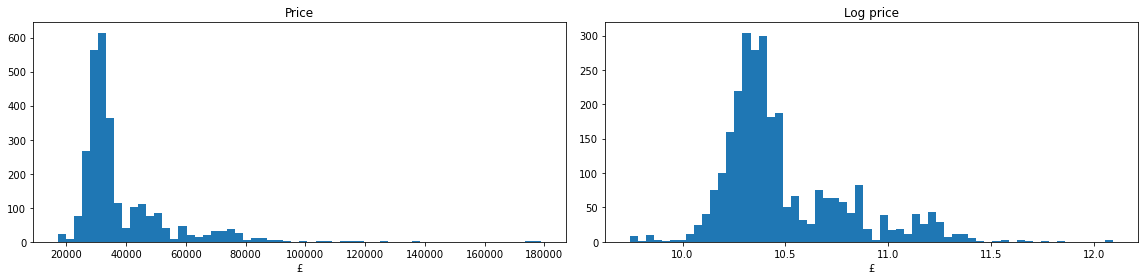

In [58]:
# Have a nosey at the price and mileage distribution

necars['log_price']=necars.price.apply(lambda x: np.log(x))
necars['mileage']=necars.mileage.apply(lambda x: float(x))
necars['log_mileage']=necars.mileage.apply(lambda x: np.log(x))

#mask = np.abs((ncars.price - ncars.price.mean(0)) / ncars.price.std(0)) > 3
#ncars= ncars[~mask]
#ncars.price.plot(kind='hist', bins=50, title='Car Price after outlier removal', xlabel='£');

fig, ax = plt.subplots(ncols=2, figsize=(16,4))
ax[0].hist(necars.price, bins=60)
ax[1].hist(necars.log_price, bins=60)
ax[0].set_xlabel('£')
ax[1].set_xlabel('£')
ax[0].set_title('Price')
ax[1].set_title('Log price')
plt.tight_layout()
plt.show()

In [59]:
# Simplify the name column a little. Probably some room for improvement here but it will be used when merging 

necars['orig_name'] = necars.name
necars['lname']=necars.name.apply(lambda x: x.lower())

body =["coupe", "convertible", "estate", "hatchback", "MPV", "pickup", 
        "SUV", "saloon","cabriolet","sedan"]
name_list_from_carsized = ['abarth 500', 'acura nsx', 'alfa-romeo 147', 'alfa-romeo 156',
       'alfa-romeo 159', 'alfa-romeo 164', 'alfa-romeo 4c',
       'alfa-romeo giulia', 'alfa-romeo giulietta', 'alfa-romeo mito',
       'alfa-romeo sprint', 'alfa-romeo stelvio', 'alvis tc 108',
       'aston-martin db11', 'aston-martin dbx', 'aston-martin rapide',
       'aston-martin vantage', 'audi 100', 'audi a1', 'audi a2',
       'audi a3', 'audi a4', 'audi a5', 'audi a6', 'audi a7', 'audi a8',
       'audi e tron', 'audi e tron gt', 'audi q2', 'audi q3',
       'audi q4 e tron', 'audi q5', 'audi q7', 'audi q8', 'audi r8',
       'audi tt', 'austin 7', 'austin healey 3000', 'bentley 3 5 litre',
       'bentley bentayga', 'bentley continental flying spur',
       'bentley continental gt', 'bentley flying spur', 'bmw 1 series', 'bmw 2 series',
       'bmw 3 series', 'bmw 4 series', 'bmw 5 series', 'bmw 6 series', 'bmw 7 series', 'bmw 8 series',
       'bmw i3', 'bmw i8', 'bmw isetta', 'bmw ix', 'bmw x1', 'bmw x2',
       'bmw x3', 'bmw x4', 'bmw x5', 'bmw x6', 'bmw x7', 'bmw z4',
       'buick skylark', 'cadillac ats', 'cadillac bls', 'cadillac cts',
       'cadillac eldorado', 'cadillac escalade', 'cadillac seville',
       'cadillac srx', 'cadillac xt5', 'chevrolet aveo',
       'chevrolet bel air', 'chevrolet camaro', 'chevrolet caprice',
       'chevrolet captiva', 'chevrolet corvette', 'chevrolet cruze',
       'chevrolet epica', 'chevrolet equinox', 'chevrolet impala',
       'chevrolet malibu', 'chevrolet matiz', 'chevrolet spark',
       'chevrolet tahoe', 'chrysler 300', 'chrysler pt cruiser',
       'chrysler sebring', 'chrysler voyager', 'citroen b14',
       'citroen berlingo', 'citroen c crosser', 'citroen c elysee',
       'citroen c1', 'citroen c3', 'citroen c3 aircross', 'citroen c4',
       'citroen c4 cactus', 'citroen c4 picasso', 'citroen c5',
       'citroen c5 aircross', 'citroen c8', 'citroen ds', 'citroen ds5',
       'citroen jumpy', 'citroen space tourer', 'cupra ateca',
       'cupra born', 'cupra formentor', 'cupra leon', 'dacia dokker',
       'dacia duster', 'dacia lodgy', 'dacia logan', 'dacia sandero',
       'daewoo lacetti', 'daihatsu sirion', 'daihatsu terios',
       'daimler 250 v8', 'daimler six', 'dodge 880', 'dodge caliber',
       'dodge challenger', 'dodge charger', 'dodge durango',
       'dodge journey', 'dodge nitro', 'dodge ram', 'dodge viper', 'ds 3',
       'ds 3 crossback', 'ds 4', 'ds 7 crossback', 'excalibur series ii',
       'ferrari 458', 'ferrari 488', 'ferrari 512', 'ferrari california',
       'ferrari california t', 'ferrari ff', 'ferrari gtc4lusso',
       'ferrari sf90', 'ferrari testarossa', 'fiat 1100', 'fiat 500',
       'fiat 500l', 'fiat 500x', 'fiat 600', 'fiat bravo', 'fiat croma',
       'fiat freemont', 'fiat fullback', 'fiat panda', 'fiat punto',
       'fiat qubo', 'fiat tipo', 'fisker karma', 'ford b max','fiat ducato'
       'ford c max', 'ford cougar', 'ford ecosport', 'ford edge',
       'ford escape', 'ford explorer', 'ford f150',
       'ford fairlane 500 skyliner', 'ford fiesta', 'ford focus',
       'ford galaxy', 'ford ka', 'ford kuga', 'ford model 48',
       'ford model t', 'ford mondeo', 'ford mustang',
       'ford mustang mach e', 'ford puma', 'ford ranger', 'ford s max',
       'ford scorpio', 'ford taurus', 'ford tourneo',
       'ford tourneo connect', 'ford tourneo courier', 'genesis g70',
       'genesis g80', 'genesis gv70', 'genesis gv80', 'gmc sierra',
       'gmc terrain', 'gmc yukon xl', 'honda accord', 'honda city',
       'honda civic', 'honda cr v', 'honda e', 'honda hr v',
       'honda jazz fit', 'honda nsx', 'honda odyssey', 'honda s',
       'hummer h2', 'hyundai getz', 'hyundai i10', 'hyundai i20',
       'hyundai i30', 'hyundai i40', 'hyundai ioniq', 'hyundai ioniq 5',
       'hyundai ix20', 'hyundai kona', 'hyundai nexo', 'hyundai santa fe',
       'hyundai tiburon', 'hyundai tucson', 'hyundai veloster',
       'infinity fx', 'infinity q30', 'infiniti q50 sedan',
       'infinity qx80', 'isuzu d max', 'jac refine e s2', 'jaguar e pace',
       'jaguar e type', 'jaguar f pace', 'jaguar f type', 'jaguar i pace',
       'jaguar x type', 'jaguar xe', 'jaguar xf', 'jaguar xj',
       'jaguar xk', 'jaguar xk120', 'jeep cherokee', 'jeep compass',
       'jeep wrangler', 'jeep grand cherokee', 'jeep renegade',
       'kia carens', 'kia ceed', 'kia ev6', 'kia magentis', 'kia niro',
       'kia picanto', 'kia rio', 'kia sorento', 'kia soul',
       'kia sportage', 'kia stinger', 'kia stonic', 'kia venga',
       'lada 2102', 'lada 4x4', 'lamborghini aventador',
       'lamborghini huracan', 'lamborghini urus', 'lancia delta',
       'lancia phedra', 'lancia ypsilon', 'land rover defender',
       'land rover discovery', 'land rover discovery sport',
       'land rover freelander', 'land rover range rover',
       'land rover range rover evoque', 'land rover range rover sport',
       'land rover range rover velar', 'lexus ct', 'lexus gs', 'lexus is',
       'lexus ls', 'lexus lx', 'lexus nx', 'lexus rx', 'lexus sc',
       'lexus ux', 'lincoln mkx', 'lincoln navigator', 'lincoln town car',
       'lotus elan', 'lotus elise', 'maserati ghibli',
       'maserati granturismo', 'maserati levante',
       'maserati quattroporte', 'maybach 57', 'mazda 2', 'mazda 3',
       'mazda 5', 'mazda 6', 'mazda cx 3', 'mazda cx 30', 'mazda cx 5',
       'mazda cx 7', 'mazda cx 9', 'mazda mx 30', 'mazda mx 5',
       'mclaren 12c', 'mclaren 650s', 'mclaren 720s', 'mercedes-benz 123',
       'mercedes-benz 170 s', 'mercedes-benz 220', 'mercedes-benz 220 s',
       'mercedes-benz a class', 'mercedes-benz amg gt', 'mercedes-benz b class',
       'mercedes-benz c class', 'mercedes-benz citan', 'mercedes-benz cl class',
       'mercedes-benz cla class', 'mercedes-benz clk class', 'mercedes-benz cls class',
       'mercedes-benz e class', 'mercedes-benz 3', 'mercedes-benz eqa',
       'mercedes-benz eqc class', 'mercedes-benz eqs class', 'mercedes-benz g class',
       'mercedes-benz gl class', 'mercedes-benz gla class', 'mercedes-benz glb class',
       'mercedes-benz glc class', 'mercedes-benz gle class', 'mercedes-benz glk class',
       'mercedes-benz gls class', 'mercedes-benz m class', 'mercedes-benz r class',
       'mercedes-benz s class', 'mercedes-benz sl', 'mercedes-benz slk',
       'mercedes-benz v class', 'mercedes-benz vito', 'mercedes-benz w114',
       'mercedes-benz x class', 'mercury cougar', 'mg f', 'mg mgb', 'mg tf',
       'mini clubman', 'mini cooper', 'mini countryman', 'mini paceman',
       'mitsubishi asx', 'mitsubishi colt', 'mitsubishi i miev',
       'mitsubishi l200', 'mitsubishi lancer', 'mitsubishi mirage',
       'mitsubishi outlander', 'mitsubishi pajero', 'moskvitch 400',
       'nissan 370z', 'nissan altima', 'nissan juke', 'nissan leaf',
       'nissan micra', 'nissan murano', 'nissan navara', 'nissan note',
       'nissan nv200', 'nissan pathfinder', 'nissan pixo',
       'nissan qashqai', 'nissan x trail', 'oldsmobile 88',
       'oldsmobile cutlass supreme', 'vauxhall adam', 'vauxhall agila',
       'vauxhall ampera', 'vauxhall astra', 'vauxhall calibra', 'vauxhall cascada',
       'vauxhall corsa', 'vauxhall crossland x', 'vauxhall grandland',
       'vauxhall insignia', 'vauxhall karl', 'vauxhall meriva', 'vauxhall mokka',
       'vauxhall tigra', 'vauxhall vectra', 'vauxhall zafira', 'peugeot 1007',
       'peugeot 108', 'peugeot 206', 'peugeot 207', 'peugeot 208', 'peugeot 2008'
       'peugeot 3008', 'peugeot 306', 'peugeot 307', 'peugeot 308',
       'peugeot 4007', 'peugeot 4008', 'peugeot 406', 'peugeot 407',
       'peugeot 5008', 'peugeot 508', 'peugeot 807', 'peugeot expert',
       'peugeot partner', 'peugeot traveller', 'plymouth volare',
       'polestar 2', 'pontiac firebird', 'pontiac gto', 'porsche 356',
       'porsche 718', 'porsche 718 cayman', 'porsche 911', 'porsche 928',
       'porsche cayenne 5 door coupe suv', 'porsche cayenne',
       'porsche macan', 'porsche panamera', 'porsche taycan',
       'renault captur', 'renault clio', 'renault espace',
       'renault fluence', 'renault fuego', 'renault kadjar',
       'renault kangoo', 'renault koleos', 'renault laguna',
       'renault megane', 'renault modus', 'renault scenic',
       'renault talisman', 'renault twingo', 'renault twizy',
       'renault zoe', 'rolls-royce corniche', 'rolls-royce cullinan',
       'rolls-royce ghost', 'rolls-royce phantom',
       'rolls-royce silver shadow', 'rolls-royce silver spirit',
       'rolls-royce wraith', 'rover sd1', 'saab 9 3', 'saab 9 5',
       'seat alhambra', 'seat altea', 'seat arona', 'seat ateca',
       'seat exeo', 'seat ibiza', 'seat leon', 'seat mii', 'seat tarraco',
       'skoda citigo', 'skoda enyaq iv', 'skoda fabia', 'skoda kamiq',
       'skoda karoq', 'skoda kodiaq', 'skoda octavia', 'skoda rapid',
       'skoda scala', 'skoda superb', 'skoda yeti', 'smart forfour',
       'smart fortwo', 'smart roadster', 'ssang yong korando',
       'ssang yong kyron', 'ssang yong rexton', 'ssang yong tivoli',
       'subaru forester', 'subaru impreza', 'subaru justy',
       'subaru legacy', 'subaru levorg', 'subaru outback',
       'subaru xv crosstrek', 'suzuki across', 'suzuki ignis',
       'suzuki jimny', 'suzuki liana', 'suzuki swift', 'suzuki sx4',
       'suzuki vitara', 'tatra 603', 'tesla model 3', 'tesla model s',
       'tesla model x', 'tesla model y', 'toyota auris', 'toyota avensis',
       'toyota aygo', 'toyota c hr', 'toyota celica', 'toyota corolla',
       'toyota corolla verso', 'toyota gt 86', 'toyota highlander',
       'toyota hilux', 'toyota iq', 'toyota land cruiser prado',
       'toyota landcruiser', 'toyota previa', 'toyota prius',
       'toyota prius plus', 'toyota proace verso', 'toyota rav4',
       'toyota sienna', 'toyota supra', 'toyota tundra',
       'toyota urban cruiser', 'toyota verso', 'toyota yaris',
       'toyota yaris cross', 'triumph spitfire', 'triumph tr7',
       'tvr cerbera', 'volkswagen 1600', 'volkswagen amarok',
       'volkswagen arteon', 'volkswagen beetle', 'volkswagen bora',
       'volkswagen caddy', 'volkswagen california',
       'volkswagen caravelle', 'volkswagen eos', 'volkswagen fox',
       'volkswagen golf', 'volkswagen id3', 'volkswagen id4',
       'volkswagen jetta', 'volkswagen passat', 'volkswagen passat cc',
       'volkswagen phaeton', 'volkswagen polo', 'volkswagen scirocco',
       'volkswagen sharan', 'volkswagen t cross', 'volkswagen t roc',
       'volkswagen tiguan', 'volkswagen touareg', 'volkswagen touran',
       'volkswagen up', 'volvo 780', 'volvo 900', 'volvo c30',
       'volvo s60', 'volvo s80', 'volvo s90', 'volvo v40', 'volvo v50',
       'volvo v60', 'volvo v70', 'volvo v90', 'volvo xc40', 'volvo xc60',
       'volvo xc70', 'volvo xc90', 'wartburg 353']


results = []
for index, car in necars.iterrows():
    lname = car[-1]
    dummy = lname
    for cname in name_list_from_carsized:
        if cname in lname:
            dummy = cname
    for bod in body:
        if bod in dummy:
            dummy = re.sub(' '+bod,'',dummy)
    results.append(dummy)

necars['name']=results
necars=necars.drop('lname', axis=1)

necars.shape

(2764, 28)

In [60]:
# Output clean used cars data 
necars=necars[['name','name_subtitle','year','price','body','mileage','BHP','doors'
            ,'transmission','make','fuel','mpg','drivertrain','engine','owners'
            ,'ULEZ','dealer_area','dealer_city','seller1','used', 'e_engine_kWh'
            ,'log_price','log_mileage','orig_name','id','year_reg','link','href0']]
necars_abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/00_clean_new_electric_cars.csv'
necars.to_csv(necars_abspath, index=False, header=necars.columns )

In [61]:
necars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2764 entries, 0 to 2815
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           2764 non-null   object 
 1   name_subtitle  2764 non-null   object 
 2   year           2764 non-null   int64  
 3   price          2764 non-null   float64
 4   body           2764 non-null   object 
 5   mileage        2764 non-null   float64
 6   BHP            2764 non-null   float64
 7   doors          2764 non-null   object 
 8   transmission   2764 non-null   object 
 9   make           2764 non-null   object 
 10  fuel           2764 non-null   object 
 11  mpg            2764 non-null   object 
 12  drivertrain    2764 non-null   object 
 13  engine         0 non-null      float64
 14  owners         2764 non-null   int64  
 15  ULEZ           2764 non-null   object 
 16  dealer_area    2415 non-null   object 
 17  dealer_city    2764 non-null   object 
 18  seller1 

# Combine dataframes

## Combine input data

In [62]:
# Read and cat clean cars data 

path = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/'
car_dataframes = [ucars_abspath, ncars_abspath, necars_abspath, uecars_abspath]
li=[]
for filename in car_dataframes:
    df = pd.read_csv(filename, index_col=None, header=0 )
    df.drop_duplicates(subset=['link'], keep='first', inplace=True)
    li.append(df)

cars = pd.concat(li, axis=0, ignore_index=True)
cars.drop_duplicates(subset=['id'], keep='first', inplace=True)
cars.shape

(400247, 28)

In [63]:
car_dataframes

['/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/00_clean_used_cars.csv',
 '/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/00_clean_new_cars.csv',
 '/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/00_clean_new_electric_cars.csv',
 '/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/00_clean_used_electric_cars.csv']

In [64]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400247 entries, 0 to 400307
Data columns (total 28 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   name           400247 non-null  object 
 1   name_subtitle  400247 non-null  object 
 2   year           400247 non-null  int64  
 3   price          400247 non-null  float64
 4   body           400247 non-null  object 
 5   mileage        400247 non-null  float64
 6   BHP            400247 non-null  float64
 7   doors          400247 non-null  object 
 8   transmission   400247 non-null  object 
 9   make           400247 non-null  object 
 10  fuel           400247 non-null  object 
 11  mpg            400247 non-null  object 
 12  drivertrain    400247 non-null  object 
 13  engine         392743 non-null  float64
 14  owners         199447 non-null  float64
 15  ULEZ           352090 non-null  object 
 16  dealer_area    340545 non-null  object 
 17  dealer_city    399771 non-nul

In [65]:
# Output all cars data - still containsa a few NaNs
cars=cars[['name','name_subtitle','year','price','body','mileage','BHP','doors'
            ,'transmission','make','fuel','mpg','drivertrain','engine','owners'
            ,'ULEZ','dealer_area','dealer_city','seller1','used', 'e_engine_kWh'
            ,'log_price','log_mileage','orig_name','id','year_reg','link','href0']]
cars_abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/00_all_cars.csv'
cars.to_csv(cars_abspath, index=False, header=cars.columns )

## Join county, latitude and longitude

In [66]:
# Import all latlon files and make ll dataframe 

path = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/latlon/'

li=[]
files = glob.glob(path + f"/*.csv")
for filename in files:
    df = pd.read_csv(filename, index_col=None, header=0 )
    li.append(df)

ll = pd.concat(li, axis=0, ignore_index=True)
ll.drop_duplicates(subset=['id'], keep='first', inplace=True)
ll = ll[['id','dealer_lat','dealer_lon']]
ll.shape    

(398983, 3)

In [67]:
# Merge cars and ll df on 'id'

cars = pd.merge(
    cars,
    ll,
    how="left",
    on='id',
    sort=False,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate="one_to_one",
)

cars.shape

(400247, 30)

In [68]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400247 entries, 0 to 400246
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   name           400247 non-null  object 
 1   name_subtitle  400247 non-null  object 
 2   year           400247 non-null  int64  
 3   price          400247 non-null  float64
 4   body           400247 non-null  object 
 5   mileage        400247 non-null  float64
 6   BHP            400247 non-null  float64
 7   doors          400247 non-null  object 
 8   transmission   400247 non-null  object 
 9   make           400247 non-null  object 
 10  fuel           400247 non-null  object 
 11  mpg            400247 non-null  object 
 12  drivertrain    400247 non-null  object 
 13  engine         392743 non-null  float64
 14  owners         199447 non-null  float64
 15  ULEZ           352090 non-null  object 
 16  dealer_area    340545 non-null  object 
 17  dealer_city    399771 non-nul

In [69]:
counties = pd.read_csv('/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/04_merge_counties.csv')

In [70]:
counties.columns

Index(['original_ll', 'geocode', 'county', 'postcode', 'postcode_short',
       'dealer_lat', 'dealer_lon', 'dealer_lat_rnd', 'dealer_lon_rnd'],
      dtype='object')

In [71]:
cars.columns

Index(['name', 'name_subtitle', 'year', 'price', 'body', 'mileage', 'BHP',
       'doors', 'transmission', 'make', 'fuel', 'mpg', 'drivertrain', 'engine',
       'owners', 'ULEZ', 'dealer_area', 'dealer_city', 'seller1', 'used',
       'e_engine_kWh', 'log_price', 'log_mileage', 'orig_name', 'id',
       'year_reg', 'link', 'href0', 'dealer_lat', 'dealer_lon'],
      dtype='object')

In [72]:
cars['dealer_lat_rnd']=cars.dealer_lat.apply(lambda x: round(x,5))
cars['dealer_lon_rnd']=cars.dealer_lon.apply(lambda x: round(x,5))

In [73]:
cars = pd.merge(
    cars,
    counties,
    how="left",
    left_on=['dealer_lat_rnd','dealer_lon_rnd'],
    right_on=['dealer_lat_rnd','dealer_lon_rnd'],
    sort=False,
    suffixes=("", "_y"),
    copy=True,
    indicator=False,
)

In [74]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400247 entries, 0 to 400246
Data columns (total 39 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   name            400247 non-null  object 
 1   name_subtitle   400247 non-null  object 
 2   year            400247 non-null  int64  
 3   price           400247 non-null  float64
 4   body            400247 non-null  object 
 5   mileage         400247 non-null  float64
 6   BHP             400247 non-null  float64
 7   doors           400247 non-null  object 
 8   transmission    400247 non-null  object 
 9   make            400247 non-null  object 
 10  fuel            400247 non-null  object 
 11  mpg             400247 non-null  object 
 12  drivertrain     400247 non-null  object 
 13  engine          392743 non-null  float64
 14  owners          199447 non-null  float64
 15  ULEZ            352090 non-null  object 
 16  dealer_area     340545 non-null  object 
 17  dealer_cit

In [75]:
cars.drop(labels=['dealer_lat_rnd', 'dealer_lon_rnd', 'original_ll',
       'dealer_lat_y', 'dealer_lon_y'], axis=1, inplace=True)

In [76]:
# Add shortest postcode column
postcode_shortest = []
for index, car in cars.iterrows():
    try: 
        postcode_shortest.append(re.findall('[A-Z][A-Z]?', car[-3])[0])
    except: 
        postcode_shortest.append('no result')
        
cars['postcode_shortest']=postcode_shortest

In [77]:
cars.columns

Index(['name', 'name_subtitle', 'year', 'price', 'body', 'mileage', 'BHP',
       'doors', 'transmission', 'make', 'fuel', 'mpg', 'drivertrain', 'engine',
       'owners', 'ULEZ', 'dealer_area', 'dealer_city', 'seller1', 'used',
       'e_engine_kWh', 'log_price', 'log_mileage', 'orig_name', 'id',
       'year_reg', 'link', 'href0', 'dealer_lat', 'dealer_lon', 'geocode',
       'county', 'postcode', 'postcode_short', 'postcode_shortest'],
      dtype='object')

In [78]:
cars.county.value_counts()

Greater London             32808
West Midlands              32761
West Yorkshire             18519
Greater Manchester         17016
Surrey                     12955
                           ...  
Argyll and Bute Council       33
Isle of Wight                 26
Na h-Eileanan an Iar           3
Orkney Islands                 1
Shetland Islands               1
Name: county, Length: 136, dtype: int64

In [79]:
# Output all cars data with lat&lon - still containsa a few NaNs
cars=cars[['name','name_subtitle','year','price','body','mileage','BHP','doors'
            ,'transmission','make','fuel','mpg','drivertrain','engine','owners'
            ,'ULEZ','county','dealer_area','dealer_city'
            ,'dealer_lat','dealer_lon','geocode'
            ,'county', 'postcode', 'postcode_short','postcode_shortest','seller1','used', 'e_engine_kWh'
            ,'log_price','log_mileage','orig_name','id','year_reg','link','href0']]
cars_abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/00_all_cars.csv'
cars.to_csv(cars_abspath, index=False, header=cars.columns )

In [80]:
tableaudf= cars.sample(50000, random_state=1)
tableau_abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/06_tableau_50000_cars.csv'
tableaudf.to_csv(tableau_abspath, index=False, header=tableaudf.columns )

In [81]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400247 entries, 0 to 400246
Data columns (total 36 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   name               400247 non-null  object 
 1   name_subtitle      400247 non-null  object 
 2   year               400247 non-null  int64  
 3   price              400247 non-null  float64
 4   body               400247 non-null  object 
 5   mileage            400247 non-null  float64
 6   BHP                400247 non-null  float64
 7   doors              400247 non-null  object 
 8   transmission       400247 non-null  object 
 9   make               400247 non-null  object 
 10  fuel               400247 non-null  object 
 11  mpg                400247 non-null  object 
 12  drivertrain        400247 non-null  object 
 13  engine             392743 non-null  float64
 14  owners             199447 non-null  float64
 15  ULEZ               352090 non-null  object 
 16  co

## Condition the EV charging .csv

In [82]:
#Import big ugly chargepoint file. Trim to relevant columns.

filename = '/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/national-charge-point-registry.csv'
charge_points = pd.read_csv(filename, index_col=None, header=0, lineterminator='\n')

charge_points=charge_points[['town','county','latitude','longitude','postcode']]

/Users/robertdavies/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (5,10,11,17,18,47,54,56,57,58,59,60,61,62,63,64,65,112,115,119,122,123,126,130,133,134,137,141,144,148,152,155) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [83]:
charge_points_abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/00_charge_points.csv'
charge_points.to_csv(charge_points_abspath, index=False, header=charge_points.columns )

## Merging the car size details

In [84]:
# Could review carsized notebook here

In [85]:
# Read all car data 

abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/00_all_cars.csv'
dfcars = pd.read_csv(abspath)

abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/02_carsized_dims_for_merge.csv'
dfsize = pd.read_csv(abspath)


match_name=[]
for index, car in dfcars.iterrows():
    name = car[0]
    name = name.replace('series','')
    name = name.replace('-',' ')
    name = name.replace('class','')
    name = name.replace('hatch','cooper')
    name = name.replace('mini','mini cooper')
    name = name.replace('cooper cooper','cooper')
    name = name.replace('cooper clubman','clubman')
    name = name.replace('cooper countryman','countryman')
    name = name.replace('jazz','jazz fit')
    name = name.strip()
    name = name.replace('mercedes benz','mercedes-benz')
    match_name.append(name)
dfcars['match_name']=match_name

In [86]:
dfcars.columns

Index(['name', 'name_subtitle', 'year', 'price', 'body', 'mileage', 'BHP',
       'doors', 'transmission', 'make', 'fuel', 'mpg', 'drivertrain', 'engine',
       'owners', 'ULEZ', 'county', 'dealer_area', 'dealer_city', 'dealer_lat',
       'dealer_lon', 'geocode', 'county.1', 'postcode', 'postcode_short',
       'postcode_shortest', 'seller1', 'used', 'e_engine_kWh', 'log_price',
       'log_mileage', 'orig_name', 'id', 'year_reg', 'link', 'href0',
       'match_name'],
      dtype='object')

In [87]:
# Merge dfcars with dfsize on 

cars_size = pd.merge(
    dfcars,
    dfsize,
    how="left",
    left_on=['match_name','body','year'],
    right_on=['name','body','year'],
    sort=False,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
)

cars_size.drop_duplicates(subset='id', keep='first',inplace=True)
print('All data size',cars_size.shape)

failed_match = cars_size[cars_size.cargo_volume_L.isnull()].copy()
failed_match.drop_duplicates(subset='id', keep='first',inplace=True)
print('Null cargo data size',failed_match.shape)

All data size (400247, 45)
Null cargo data size (48402, 45)


In [88]:
# There are a few failed matches, but at this stage I have to let it go. If I was being paid I could fix these.
failed_match[failed_match.cargo_volume_L.isnull()].match_name.value_counts(dropna=False).head(50)
failed_match[failed_match.match_name=='bmw 2']

,name_x,name_subtitle,year,price,body,mileage,BHP,doors,transmission,make,...,href0,match_name,name_y,wheelbase_cm,length_cm,width_cm,height_cm,ground_clearance_cm,cargo_volume_L,max_cargo_volume_L
69000,bmw 2 series,2.0 220d M Sport Active Tourer Auto (s/s) 5dr,2014,13995.0,MPV,58196.0,187.376726,5dr,Automatic,BMW,...,/dealers/devon/exeter/carrs-select-10015472?ch...,bmw 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69001,bmw 2 series,2.0 218d Luxury Auto (s/s) 5dr,2014,14500.0,MPV,38600.0,147.928994,5dr,Automatic,BMW,...,/dealers/kent/faversham/elms-automotive-100165...,bmw 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69002,bmw 2 series,2.0 218d Luxury Auto (s/s) 5dr,2014,12990.0,MPV,34950.0,147.928994,5dr,Automatic,BMW,...,NaN,bmw 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69003,bmw 2 series,218D SPORT ACTIVE TOURER with Satellite Naviga...,2014,11100.0,MPV,39509.0,150.000000,5dr,Manual,BMW,...,/dealers/huntingdonshire/peterborough/carzam-1...,bmw 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69004,bmw 2 series,218d Sport Active Tourer 2.0 5dr,2014,13174.0,MPV,61500.0,150.000000,5dr,Manual,BMW,...,NaN,bmw 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391311,bmw 2 series,2.0 223i MHT M Sport DCT (s/s) 5dr,2022,39120.0,MPV,0.0,201.183432,5dr,Automatic,BMW,...,/dealers/lincoln/south-hykeham/soper-bmw-17117...,bmw 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
391320,bmw 2 series,218i [136] M Sport 4dr Petrol Saloon 1.5,2022,33680.0,Saloon,0.0,136.000000,4dr,Automatic,BMW,...,NaN,bmw 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
391321,bmw 2 series,218i [136] M Sport 4dr Petrol Saloon 1.5,2022,30475.0,Saloon,0.0,136.000000,4dr,Automatic,BMW,...,NaN,bmw 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
391322,bmw 2 series,1.5 218i M Sport (s/s) 4dr,2022,29499.0,Saloon,0.0,134.122288,4dr,Manual,BMW,...,/dealers/staffordshire/stoke-on-trent/knights-...,bmw 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
# Failed match value counts
failed_match['name_x'].value_counts(dropna=False).head(10)

bmw 2 series         1876
vauxhall insignia    1419
vauxhall zafira      1324
skoda octavia        1192
ford mondeo           992
ford c-max            871
abarth 595            789
citroen c4 cactus     757
ford s-max            733
audi s3               702
Name: name_x, dtype: int64

In [90]:
# cars_size shape before dropping nans
cars_size.shape

(400247, 45)

In [91]:
# cars_size shape after dropping nans

cars_size.dropna(subset = ['cargo_volume_L'], inplace=True)
cars_size.dropna(subset = ['dealer_lat'], inplace=True)
cars_size.dropna(subset = ['dealer_lon'], inplace=True)
cars_size.dropna(subset = ['county'], inplace=True)

cars_size = cars_size[cars_size.cargo_volume_L!=0.0].copy()
cars_size.shape

(335826, 45)

In [92]:
cars_size.columns

Index(['name_x', 'name_subtitle', 'year', 'price', 'body', 'mileage', 'BHP',
       'doors', 'transmission', 'make', 'fuel', 'mpg', 'drivertrain', 'engine',
       'owners', 'ULEZ', 'county', 'dealer_area', 'dealer_city', 'dealer_lat',
       'dealer_lon', 'geocode', 'county.1', 'postcode', 'postcode_short',
       'postcode_shortest', 'seller1', 'used', 'e_engine_kWh', 'log_price',
       'log_mileage', 'orig_name', 'id', 'year_reg', 'link', 'href0',
       'match_name', 'name_y', 'wheelbase_cm', 'length_cm', 'width_cm',
       'height_cm', 'ground_clearance_cm', 'cargo_volume_L',
       'max_cargo_volume_L'],
      dtype='object')

In [93]:
# Output all cars data with lat&lon and volume stats - still containsa a few NaNs - dealer_area could be better

cars_size.columns = ['name', 'name_subtitle', 'year', 'price', 'body', 'mileage', 'BHP',
       'doors', 'transmission', 'make', 'fuel', 'mpg', 'drivertrain', 'engine',
       'owners', 'ULEZ', 'county', 'dealer_area', 'dealer_city', 'dealer_lat',
       'dealer_lon', 'geocode', 'county', 'postcode', 'postcode_short','postcode_shortest',
       'seller1', 'used', 'e_engine_kWh', 'log_price', 'log_mileage',
       'orig_name', 'id', 'year_reg', 'link', 'href0', 'match_name', 'name_y',
       'wheelbase_cm', 'length_cm', 'width_cm', 'height_cm',
       'ground_clearance_cm', 'cargo_volume_L', 'max_cargo_volume_L']

cars_size=cars_size[['name','name_subtitle','year','price','body','mileage','BHP','doors'
            ,'transmission','make','fuel','mpg','drivertrain','engine','owners'
            ,'ULEZ','dealer_area','dealer_city','geocode', 'county', 'postcode', 'postcode_short','postcode_shortest'
            ,'dealer_lat','dealer_lon','seller1','used', 'e_engine_kWh'
            ,'log_price','log_mileage','orig_name','id','year_reg','link','href0'
            ,'wheelbase_cm', 'length_cm', 'width_cm'
            ,'height_cm', 'ground_clearance_cm', 'cargo_volume_L']]
cars_abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/02_cars_with_location_and_size.csv'
cars_size.to_csv(cars_abspath, index=False, header=cars_size.columns )

In [94]:
cars_size.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335826 entries, 171 to 400245
Data columns (total 42 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   name                 335826 non-null  object 
 1   name_subtitle        335826 non-null  object 
 2   year                 335826 non-null  int64  
 3   price                335826 non-null  float64
 4   body                 335826 non-null  object 
 5   mileage              335826 non-null  float64
 6   BHP                  335826 non-null  float64
 7   doors                335826 non-null  object 
 8   transmission         335826 non-null  object 
 9   make                 335826 non-null  object 
 10  fuel                 335826 non-null  object 
 11  mpg                  335826 non-null  object 
 12  drivertrain          335826 non-null  object 
 13  engine               330409 non-null  float64
 14  owners               165740 non-null  float64
 15  ULEZ           

# EDA on used cars

## Pretty general interest plots

In [95]:
# Read clean used cars data 

abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/00_all_cars.csv'
df = pd.read_csv(abspath)
print('All cars',df.shape)
df = df[df['used']==1]
print('Used cars',df.shape)

All cars (400247, 36)
Used cars (378597, 36)


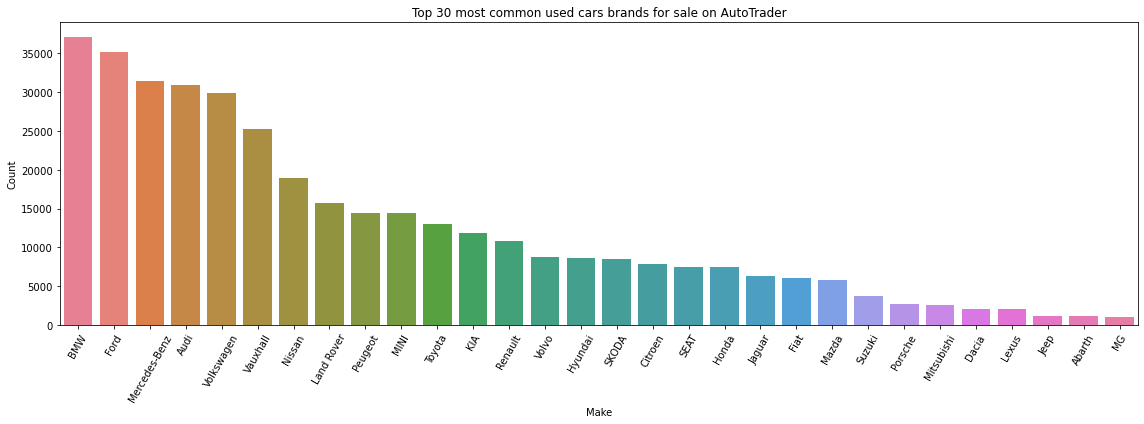

In [96]:
# Plot of make frequency 

df.groupby(by='make')['name'].count().sort_values(ascending=False).head(30).reset_index()

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,6))
sns.barplot(x="make", y="name", data=df.groupby(by='make')['name'].count().sort_values(ascending=False).head(30).reset_index()
            ,palette='husl').set_title('Top 30 most common used cars brands for sale on AutoTrader')
ax.set_xlabel('Make')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=60)
plt.tight_layout()
plt.savefig('carbrandcount.pdf',bbox_inches='tight')
plt.show()


*94% of cars can be described by the top 23 makes - should I drop the other 40? Tbc.*

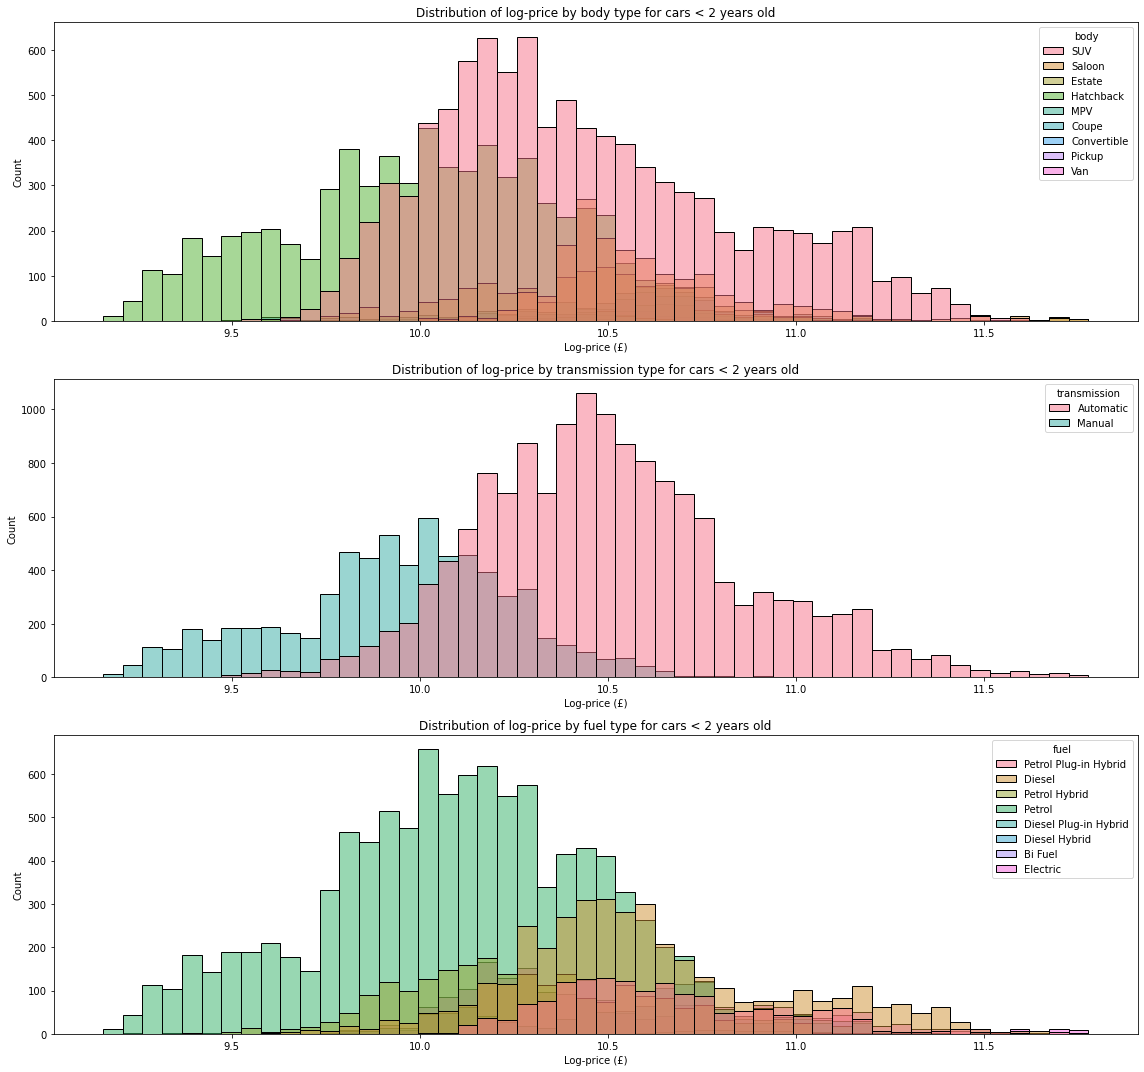

In [97]:
# Plot of pridce distributions by categorical variables - remove outliers first 

dfo=df.copy()
mask = np.abs((dfo.log_price - dfo.log_price.mean(0)) / dfo.log_price.std(0)) > 3
dfo= dfo[~mask]


fig, ax = plt.subplots(nrows=3, figsize=(16,15))
sns.histplot(data=dfo[dfo.year>2020], x="log_price",hue="body",palette='husl',bins=50, legend=True, ax=ax[0]).set_title('Distribution of log-price by body type for cars < 2 years old')
ax[0].set_xlabel('Log-price (£)')
ax[0].set_ylabel('Count')
sns.histplot(data=dfo[dfo.year>2020], x="log_price",hue="transmission",palette='husl',bins=50, legend=True, ax=ax[1]).set_title('Distribution of log-price by transmission type for cars < 2 years old')
ax[1].set_xlabel('Log-price (£)')
ax[1].set_ylabel('Count')
sns.histplot(data=dfo[dfo.year>2020], x="log_price",hue="fuel",palette='husl',bins=50, legend=True, ax=ax[2]).set_title('Distribution of log-price by fuel type for cars < 2 years old')
ax[2].set_xlabel('Log-price (£)')
ax[2].set_ylabel('Count')
plt.tight_layout()
plt.show()

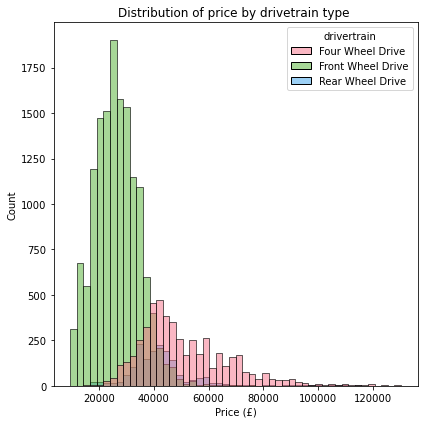

In [98]:
# Plot of pridce distributions by categorical variables - remove outliers first 

dfo=df.copy()
mask = np.abs((dfo.log_price - dfo.log_price.mean(0)) / dfo.log_price.std(0)) > 3
dfo= dfo[~mask]
dfo['drivetrain']=dfo.drivertrain


fig, ax = plt.subplots(figsize=(6,6))
sns.histplot(data=dfo[dfo.year>2020], x="price",hue="drivertrain",palette='husl',bins=50, legend=True, ax=ax).set_title('Distribution of price by drivetrain type ')
ax.set_xlabel('Price (£)')
ax.set_ylabel('Count')

plt.tight_layout()
plt.savefig('drivetraindist.pdf',bbox_inches='tight')

plt.show()

*In these three categorical variables presented it looks like transmission variable provides the best information on car price. Automatic cars are clearly more expensive than manual cars.*

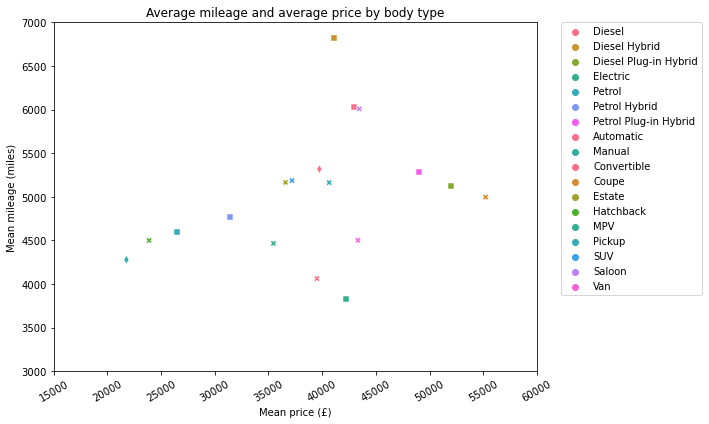

In [99]:
# Plot of avergae price and mileage figures for categorical variables - Failed 

plotdf1 = df[df.year>2020].groupby(by='fuel')[['price','mileage']].mean().reset_index()
plotdf1 = plotdf1[plotdf1.fuel!='Bi Fuel']
plotdf2 = df[df.year>2020].groupby(by='transmission')[['price','mileage']].mean().reset_index()
plotdf3 = df[df.year>2020].groupby(by='body')[['price','mileage']].mean().reset_index()
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(data=plotdf1, x="price", y="mileage", hue="fuel",palette='husl', marker='s').set_title('Average mileage and average price by fuel type')
sns.scatterplot(data=plotdf2, x="price", y="mileage", hue="transmission",palette='husl', marker='d').set_title('Average mileage and average price by transmission type')
sns.scatterplot(data=plotdf3, x="price", y="mileage", hue="body",palette='husl', marker='X').set_title('Average mileage and average price by body type')
ax.set_xlabel('Mean price (£)')
ax.set_ylabel('Mean mileage (miles)')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_ylim(3000,7000)
ax.set_xlim(15000,60000)
ax.tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.show()

*This plot hasn't really worked - I wanted to get the shape of the marker in the legend but no luck. The plots below are broken up and detail it better.*

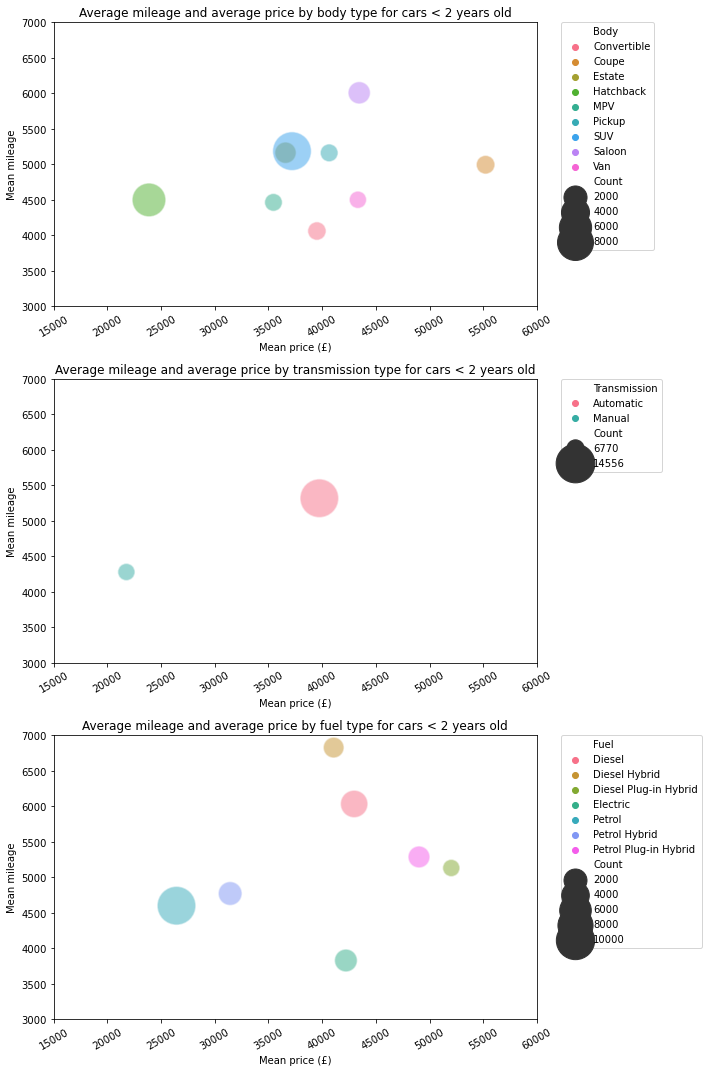

In [100]:
# Plot of avergae price and mileage figures for categorical variables

plotdf1 = df[df.year>2020].groupby(by='fuel')[['price','mileage','doors']].agg({'price':'mean', 'mileage':'mean','doors':'count'}).reset_index()
plotdf1 = plotdf1[plotdf1.fuel!='Bi Fuel']
plotdf1.columns = ['Fuel','price','mileage','Count']
plotdf2 = df[df.year>2020].groupby(by='transmission')[['price','mileage','doors']].agg({'price':'mean', 'mileage':'mean','doors':'count'}).reset_index()
plotdf2.columns = ['Transmission','price','mileage','Count']

plotdf3 = df[df.year>2020].groupby(by='body')[['price','mileage','doors']].agg({'price':'mean', 'mileage':'mean','doors':'count'}).reset_index()
plotdf3.columns = ['Body','price','mileage','Count']

fig, ax = plt.subplots(nrows=3,figsize=(10,15))
sns.scatterplot(data=plotdf1, x="price", y="mileage", hue="Fuel", size='Count',
                sizes=(300, 1500), alpha=.5,palette='husl', ax=ax[2], 
                ).set_title('Average mileage and average price by fuel type for cars < 2 years old')
ax[2].set_xlabel('Mean price (£)')
ax[2].set_ylabel('Mean mileage')
sns.scatterplot(data=plotdf2, x="price", y="mileage", hue="Transmission",
                size='Count',sizes=(300, 1500), alpha=.5,palette='husl', ax=ax[1], 
                ).set_title('Average mileage and average price by transmission type for cars < 2 years old')
ax[1].set_xlabel('Mean price (£)')
ax[1].set_ylabel('Mean mileage')
sns.scatterplot(data=plotdf3, x="price", y="mileage", hue="Body",size='Count',
                sizes=(300, 1500), alpha=.5,palette='husl', ax=ax[0], 
                ).set_title('Average mileage and average price by body type for cars < 2 years old')
ax[0].set_xlabel('Mean price (£)')
ax[0].set_ylabel('Mean mileage')
for i in range(0,3):
    ax[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax[i].set_ylim(3000,7000)
    ax[i].set_xlim(15000,60000)
    ax[i].tick_params(axis='x', rotation=30)   
plt.tight_layout()
plt.show()

*I don't really like these plots much. I was trying to show where the average car in each of these categories lies in terms of price and mileage. I'm not sure if I should filter based on year or not.*

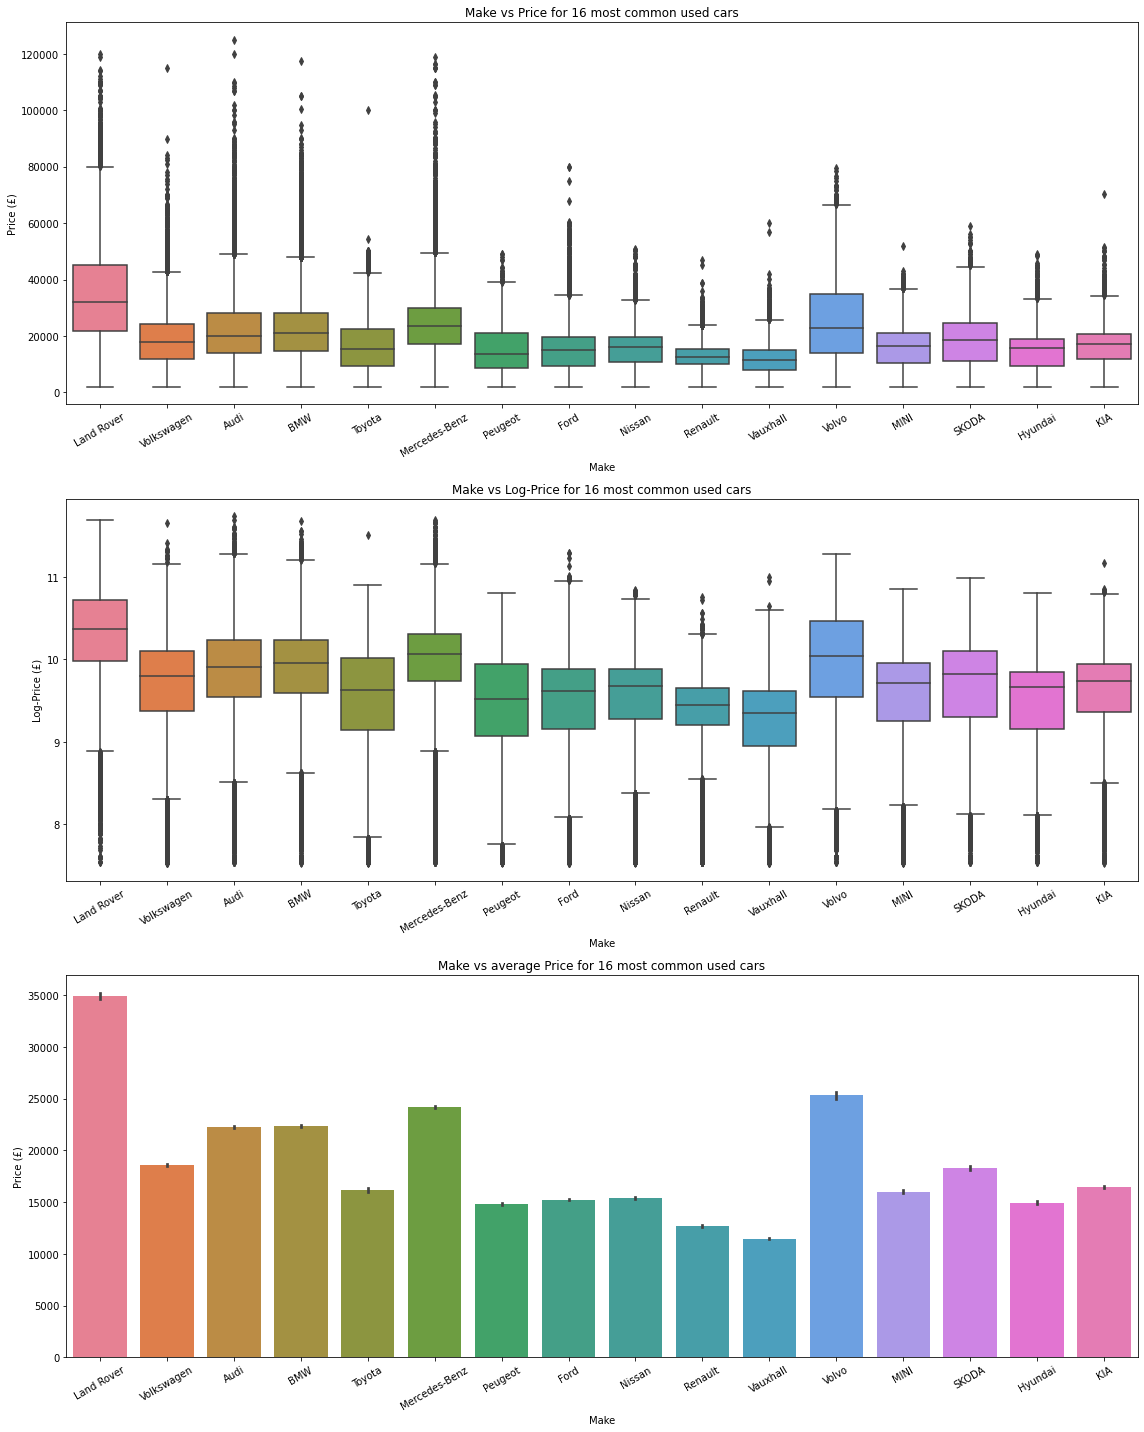

In [101]:
# Plot top 16 car brands - outliers removed in log-space
top15makes = list(df.make.value_counts().head(16).reset_index()['index'])
plotdf1 = df[df.make.isin(top15makes)]
# Remove outliers from log_price data - check this
mask = np.abs((plotdf1.log_price - plotdf1.log_price.mean(0)) / plotdf1.log_price.std(0)) > 3
plotdf1= plotdf1[~mask]

fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize=(16,20))
sns.boxplot(x='make', y='price', data=plotdf1, ax=ax[0],palette='husl').set_title('Make vs Price for 16 most common used cars')
ax[0].set_xlabel('Make')
ax[0].set_ylabel('Price (£)')
sns.boxplot(x='make', y='log_price', data=plotdf1,ax=ax[1],palette='husl').set_title('Make vs Log-Price for 16 most common used cars')
ax[1].set_xlabel('Make')
ax[1].set_ylabel('Log-Price (£)')
sns.barplot(x="make", y="price", data=plotdf1, ax=ax[2],palette='husl').set_title('Make vs average Price for 16 most common used cars')
ax[2].set_xlabel('Make')
ax[2].set_ylabel('Price (£)')
for i in range(0,3):
    ax[i].tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.show()

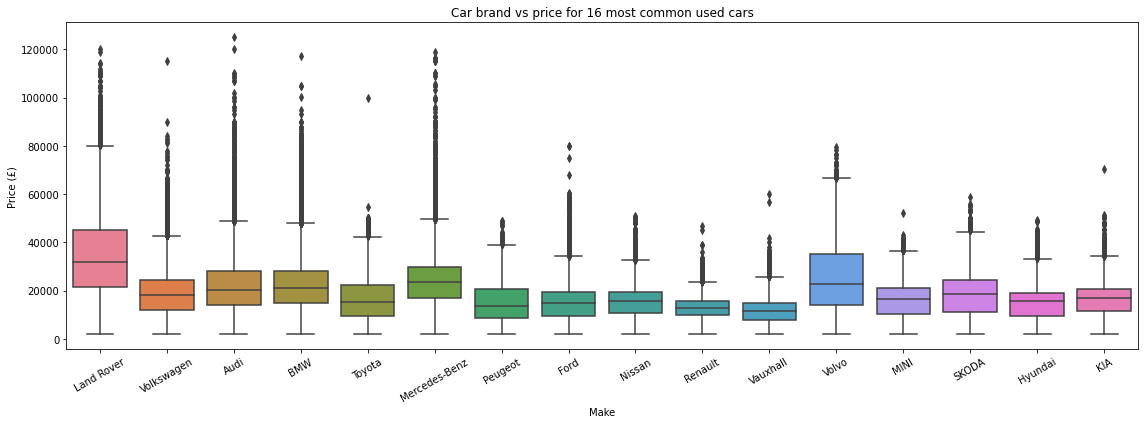

In [102]:
# Plot top 16 car brands - outliers removed in log-space
top15makes = list(df.make.value_counts().head(16).reset_index()['index'])
plotdf1 = df[df.make.isin(top15makes)]
# Remove outliers from log_price data - check this
mask = np.abs((plotdf1.log_price - plotdf1.log_price.mean(0)) / plotdf1.log_price.std(0)) > 3
plotdf1= plotdf1[~mask]

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,6))
sns.boxplot(x='make', y='price', data=plotdf1, ax=ax,palette='husl').set_title('Car brand vs price for 16 most common used cars')
ax.set_xlabel('Make')
ax.set_ylabel('Price (£)')
ax.tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.savefig('branddist.pdf',bbox_inches='tight')

plt.show()

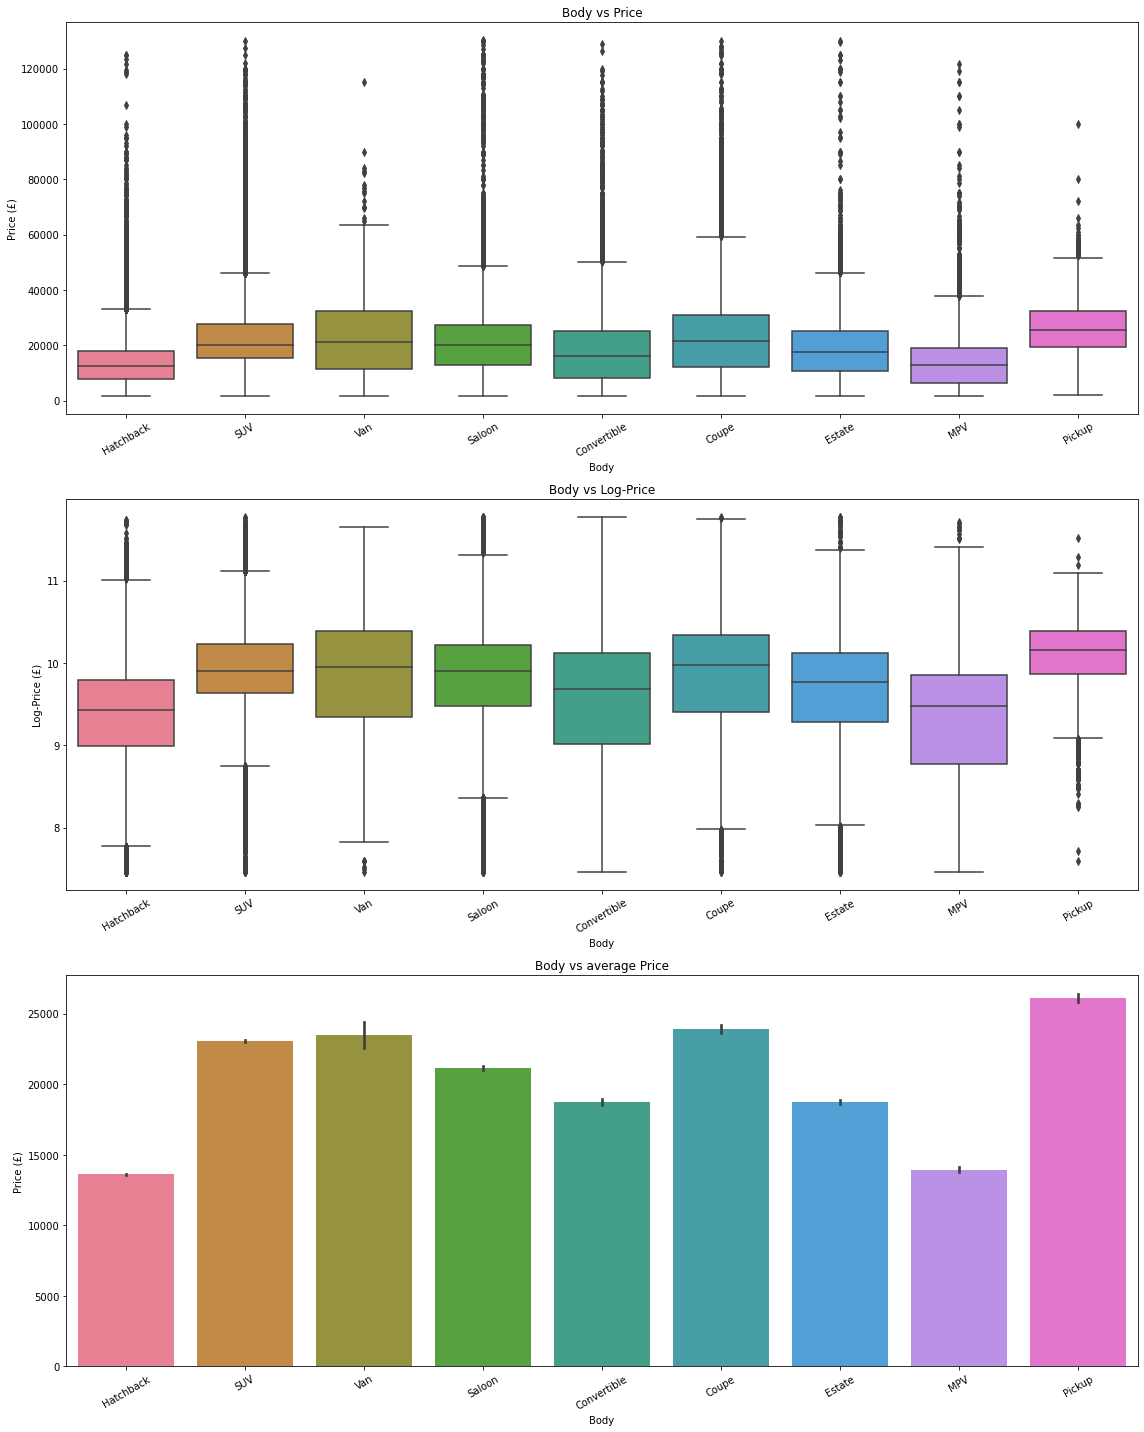

In [103]:
# Plot by body type - outliers removed in log-space

# Remove outliers from log_price data - check this
mask = np.abs((df.log_price - df.log_price.mean(0)) / df.log_price.std(0)) > 3
plotdf2= df[~mask]

fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize=(16,20))
sns.color_palette("husl", 8)
sns.boxplot(x='body', y='price', data=plotdf2, ax=ax[0], palette='husl').set_title('Body vs Price')
ax[0].set_xlabel('Body')
ax[0].set_ylabel('Price (£)')
sns.boxplot(x='body', y='log_price', data=plotdf2,ax=ax[1],palette='husl').set_title('Body vs Log-Price')
ax[1].set_xlabel('Body')
ax[1].set_ylabel('Log-Price (£)')
sns.barplot(x="body", y="price", data=plotdf2, ax=ax[2],palette='husl').set_title('Body vs average Price')
ax[2].set_xlabel('Body')
ax[2].set_ylabel('Price (£)')
for i in range(0,3):
    ax[i].tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.show()

In [104]:
# Checking outlier code
f= df[df.year==2013].sort_values(by='log_price',ascending=False).head(1)
for index, car in f.iterrows():
    print(car)
    print(car[-2])

name                                                       porsche 911
name_subtitle           3.8 991 50th Anniversary Edition PDK (s/s) 2dr
year                                                              2013
price                                                         119500.0
body                                                             Coupe
mileage                                                         9685.0
BHP                                                         394.477318
doors                                                              2dr
transmission                                                 Automatic
make                                                           Porsche
fuel                                                            Petrol
mpg                                                            OVER_30
drivertrain                                           Rear Wheel Drive
engine                                                             3.8
owners

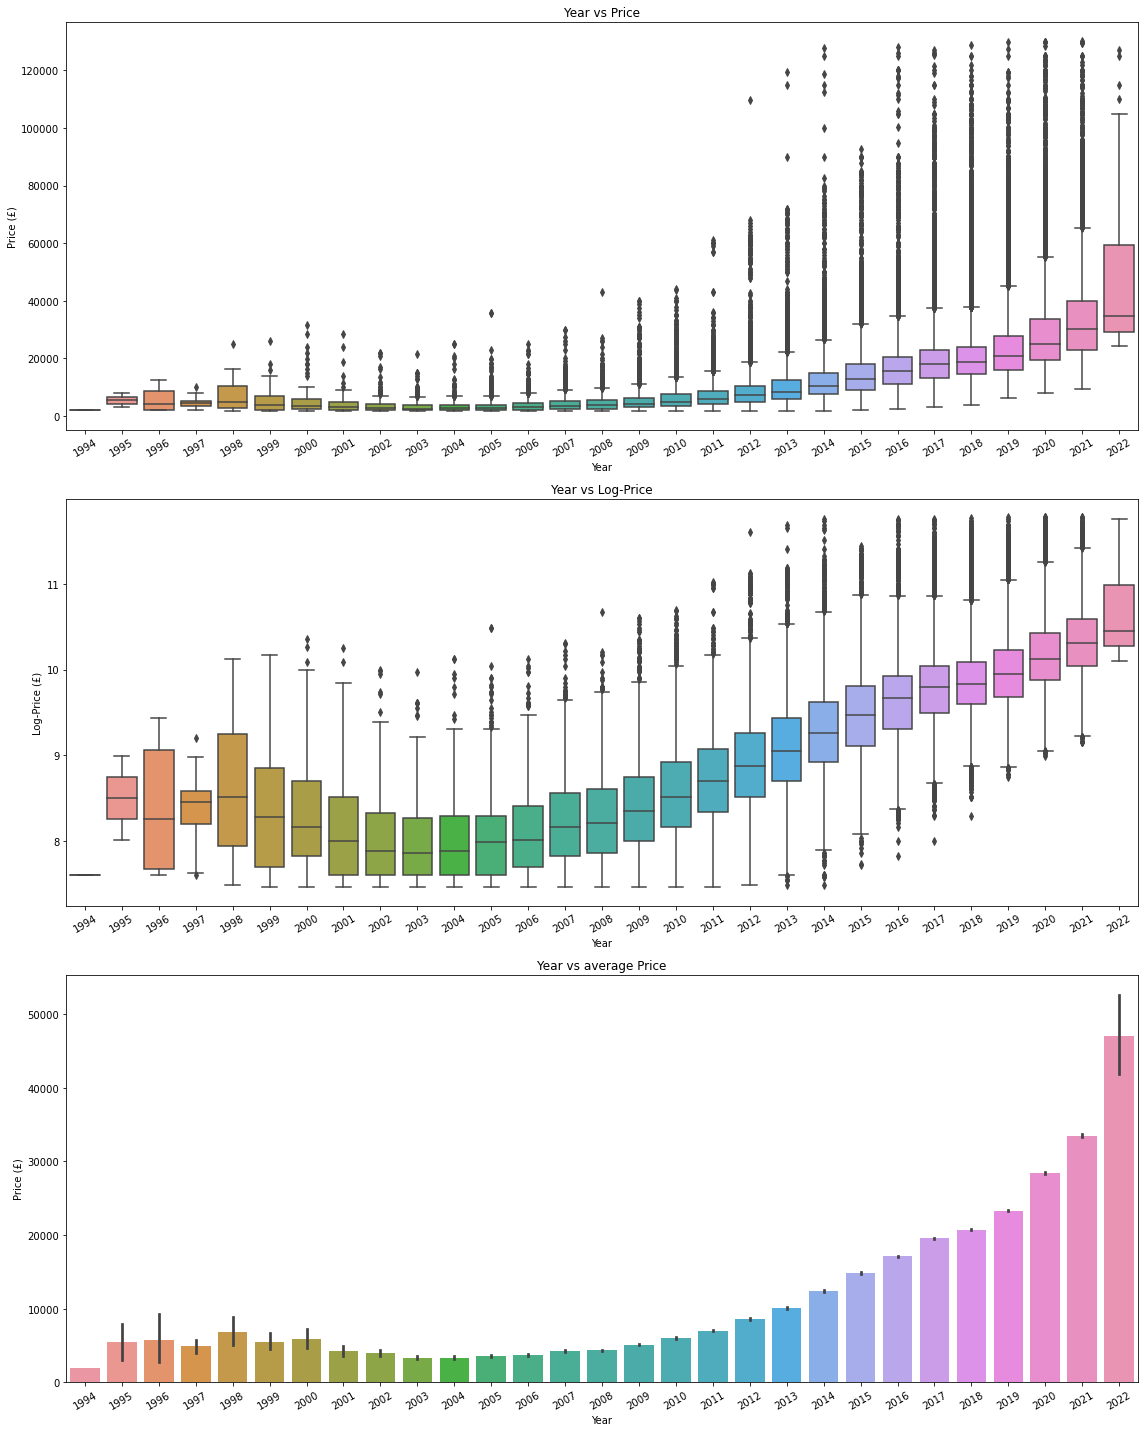

In [105]:
# Plot by year - outliers removed in log-space 

# Remove outliers from log_price data - check this
mask = np.abs((df.log_price - df.log_price.mean(0)) / df.log_price.std(0)) > 3
plotdf2= df[~mask]

fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize=(16,20))
sns.boxplot(x='year', y='price', data=plotdf2, ax=ax[0]).set_title('Year vs Price')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Price (£)')
sns.boxplot(x='year', y='log_price', data=plotdf2,ax=ax[1]).set_title('Year vs Log-Price')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Log-Price (£)')
sns.barplot(x="year", y="price", data=plotdf2, ax=ax[2]).set_title('Year vs average Price')
ax[2].set_xlabel('Year')
ax[2].set_ylabel('Price (£)')
for i in range(0,3):
    ax[i].tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.show()

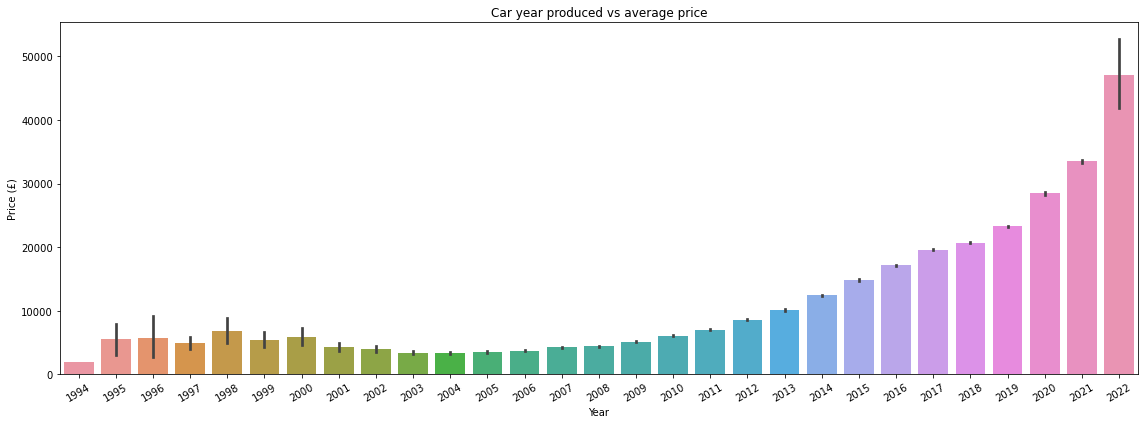

In [106]:
# Plot by year - outliers removed in log-space 

# Remove outliers from log_price data - check this
mask = np.abs((df.log_price - df.log_price.mean(0)) / df.log_price.std(0)) > 3
plotdf2= df[~mask]

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,6))
sns.barplot(x="year", y="price", data=plotdf2, ax=ax).set_title('Car year produced vs average price')
ax.set_xlabel('Year')
ax.set_ylabel('Price (£)')
ax.tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.savefig('yearprice.pdf',bbox_inches='tight')
plt.show()

In [107]:
plotdf2[plotdf2['drivertrain']=='Rear Wheel Drive'].name.value_counts().head(20)

bmw 3 series             6091
bmw 1 series             5676
mercedes-benz c class    5435
bmw 5 series             3131
mercedes-benz e class    3056
bmw 4 series             3023
bmw 2 series             2008
jaguar xf                1635
mazda mx-5               1438
mercedes-benz c-class    1346
jaguar xe                1060
mercedes-benz slk         771
bmw z4                    736
mercedes-benz e-class     686
smart fortwo              631
bmw 6 series              547
mercedes-benz sl          535
mercedes-benz s class     433
jaguar f-type             424
bmw m4                    415
Name: name, dtype: int64

*These plots help describe the relationship between price and age of a car. It can be seen to decease as the car year approaches 2003, before a slight increase in average price. This must be the vintage car factor being introduced. Note that confidence bounds are wider for newer cars and older cars as the sample size within each year is greatly reduced.*

## Distribution and collinearity evaluation

In [108]:
# Import packages 
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

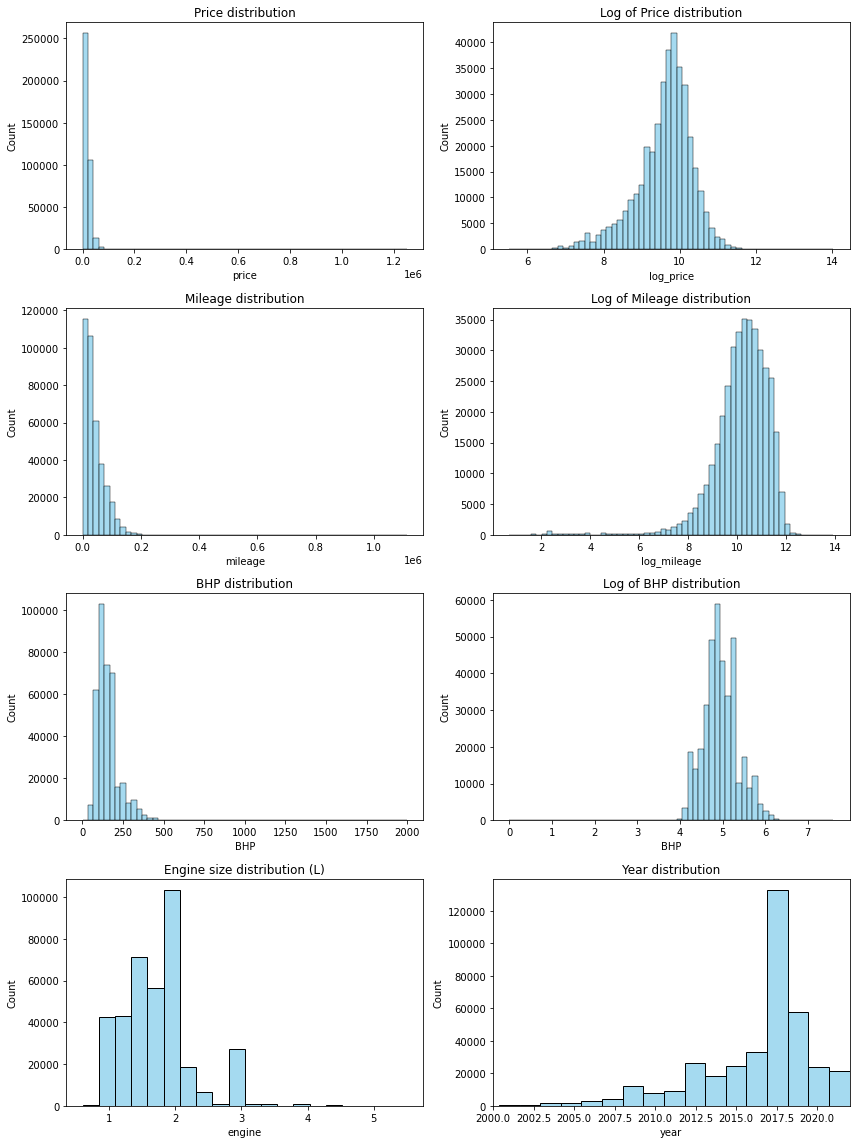

In [109]:
# Seaborn plots of continuous variables

# plt.style.use('ggplot')

# %config InlineBackend.figure_format = 'retina'
# %matplotlib inline



fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12,16))
sns.histplot(data=df.price, bins=60, color='skyblue',ax=ax[0,0]).set_title('Price distribution')
sns.histplot(data=df.log_price, bins=60, color='skyblue',ax=ax[0,1]).set_title('Log of Price distribution')
sns.histplot(data=df.mileage, bins=60, color='skyblue',ax=ax[1,0]).set_title('Mileage distribution')
sns.histplot(data=df.log_mileage, bins=60, color='skyblue',ax=ax[1,1]).set_title('Log of Mileage distribution')
sns.histplot(data=df.BHP, bins=60, color='skyblue',ax=ax[2,0]).set_title('BHP distribution')
sns.histplot(data=df.BHP.apply(lambda x: np.log(x)), bins=60, color='skyblue',ax=ax[2,1]).set_title('Log of BHP distribution')
sns.histplot(data=df.engine, bins=20, color='skyblue',ax=ax[3,0]).set_title('Engine size distribution (L)')
sns.histplot(data=df.year, bins=22, color='skyblue',ax=ax[3,1]).set_title('Year distribution')
ax[3,1].set_xlim(2000,2022)
plt.tight_layout()
plt.show()

/var/folders/1h/l422441d07d4l2q1nfyrjk740000gn/T/ipykernel_18360/2928868623.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfplot= dfplot[~mask]
/var/folders/1h/l422441d07d4l2q1nfyrjk740000gn/T/ipykernel_18360/2928868623.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfplot= dfplot[~mask]


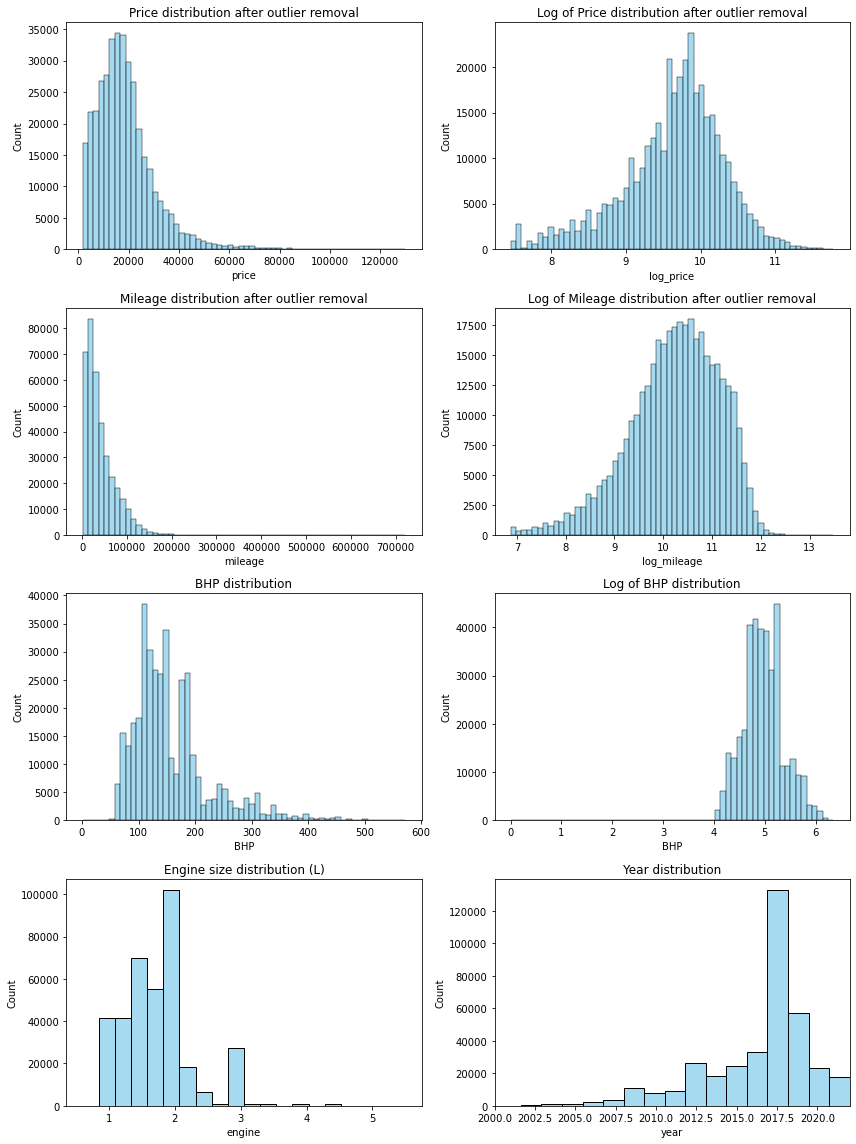

In [110]:
mask = np.abs((df.log_price - df.log_price.mean()) / df.log_price.std()) > 3
dfplot= df[~mask]

mask = np.abs((df.log_mileage - df.log_mileage.mean()) / df.log_mileage.std()) > 3
dfplot= dfplot[~mask]

mask = np.abs((df.BHP - df.BHP.mean()) / df.BHP.std()) > 6
dfplot= dfplot[~mask]

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12,16))
sns.histplot(data=dfplot.price, bins=60, color='skyblue',ax=ax[0,0]).set_title('Price distribution after outlier removal')
sns.histplot(data=dfplot.log_price, bins=60, color='skyblue',ax=ax[0,1]).set_title('Log of Price distribution after outlier removal')
sns.histplot(data=dfplot.mileage, bins=60, color='skyblue',ax=ax[1,0]).set_title('Mileage distribution after outlier removal')
sns.histplot(data=dfplot.log_mileage, bins=60, color='skyblue',ax=ax[1,1]).set_title('Log of Mileage distribution after outlier removal')
sns.histplot(data=dfplot.BHP, bins=60, color='skyblue',ax=ax[2,0]).set_title('BHP distribution')
sns.histplot(data=dfplot.BHP.apply(lambda x: np.log(x)), bins=60, color='skyblue',ax=ax[2,1]).set_title('Log of BHP distribution')
sns.histplot(data=dfplot.engine, bins=20, color='skyblue',ax=ax[3,0]).set_title('Engine size distribution (L)')
sns.histplot(data=dfplot.year, bins=22, color='skyblue',ax=ax[3,1]).set_title('Year distribution')
ax[3,1].set_xlim(2000,2022)
plt.tight_layout()
plt.show()

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378597 entries, 0 to 400246
Data columns (total 36 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   name               378597 non-null  object 
 1   name_subtitle      378597 non-null  object 
 2   year               378597 non-null  int64  
 3   price              378597 non-null  float64
 4   body               378597 non-null  object 
 5   mileage            378597 non-null  float64
 6   BHP                378597 non-null  float64
 7   doors              378597 non-null  object 
 8   transmission       378597 non-null  object 
 9   make               378597 non-null  object 
 10  fuel               378597 non-null  object 
 11  mpg                378597 non-null  object 
 12  drivertrain        378597 non-null  object 
 13  engine             373857 non-null  float64
 14  owners             196683 non-null  float64
 15  ULEZ               330546 non-null  object 
 16  co

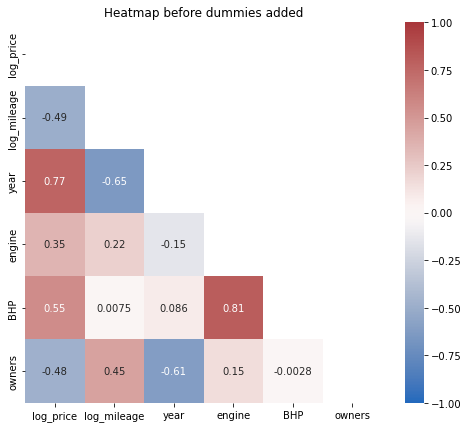

In [112]:
# Heatmap before dummies

tocorr=['log_price','log_mileage','year','engine','BHP','owners']
plt.rcParams["figure.figsize"] = (8,7)
mask =np.zeros_like(df[tocorr].corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df[tocorr].corr(), vmin=-1, vmax=1, cmap='vlag', annot=True, mask=mask)
plt.title('Heatmap before dummies added')
plt.show()

*Looks like there's some significant correlation between engine and BHP. I don't want to use highly correlated predictors so I'm going to have to drop one - Engine. This is fortunate actually because engine units are inconsistent between electric cars and conventional cars. I will drop the engine column.*

In [113]:
#Checking for null values 
df[tocorr].isnull().sum()

log_price           0
log_mileage         0
year                0
engine           4740
BHP                 0
owners         181914
dtype: int64

*As well as dropping the engine column, I'm going to have to drop the owners column. This just wasn't populated enough on AutoTrader and has 45% NaN values.*

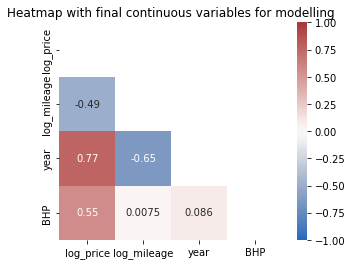

In [114]:
# Heatmap after dropping engine and owners

tocorr=['log_price','log_mileage','year','BHP']
plt.rcParams["figure.figsize"] = (5,4)
mask =np.zeros_like(df[tocorr].corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df[tocorr].corr(), vmin=-1, vmax=1, cmap='vlag', annot=True, mask=mask)
plt.title('Heatmap with final continuous variables for modelling')
plt.show()

In [115]:
# Modelling without dummies  - assess VIF 

# Define X and y
X = df[['log_mileage','year','BHP']]

# Great link on multicollinearity
# https://blog.minitab.com/en/understanding-statistics/handling-multicollinearity-in-regression-analysis

# If VIF=1 then there's no multicollinearity
# If VIF>5 then there's significant multicollinearity and it will be a problem

Xvif = add_constant(X)
VIF = pd.Series([variance_inflation_factor(Xvif.values, i) 
               for i in range(Xvif.shape[1])], 
              index=Xvif.columns)
print('VIF stats: \n',VIF,'\n')

VIF stats: 
 const          585106.407329
log_mileage         1.733253
year                1.745943
BHP                 1.014329
dtype: float64 



*The remaining continuous variables are not overly correlated. This bodes well for model building.*

In [116]:
import scipy.stats as stats
import itertools

In [117]:
# Chi2 stats for categorical variables
results=[]
categoricals = ['mpg','drivertrain','make','body','transmission','fuel','doors']
for x in itertools.combinations(('mpg','drivertrain','make','body','transmission','fuel','doors'), 2):
    categoricalv1 = x[0]
    categoricalv2 = x[1]
    cross_tab = pd.crosstab(df[categoricalv1], df[categoricalv2])
    chi2 = stats.chi2_contingency(cross_tab)
    results.append([x[0],x[1],chi2[0],round(chi2[1],4),chi2[2]])
    chi2df = pd.DataFrame(results, columns = ['categorical1','categorical2','chi2_statistic','p-value','degrees_of_freedom'])

chi2df

,categorical1,categorical2,chi2_statistic,p-value,degrees_of_freedom
0,mpg,drivertrain,59133.052007,0.0,8
1,mpg,make,112047.440184,0.0,244
2,mpg,body,52307.652912,0.0,32
3,mpg,transmission,30496.731096,0.0,4
4,mpg,fuel,437714.790195,0.0,28
5,mpg,doors,10709.258978,0.0,16
6,drivertrain,make,300835.738416,0.0,122
7,drivertrain,body,213637.570940,0.0,16
8,drivertrain,transmission,94247.039532,0.0,2
9,drivertrain,fuel,57479.628980,0.0,14


In [118]:
# I NEED TO FIND A STATISTICAL REASON TO NOT USE THE MPG VARIABLE

In [119]:
df.groupby('mpg')['BHP'].count().reset_index()

,mpg,BHP
0,Electric,4740
1,OVER_30,70561
2,OVER_40,130183
3,OVER_50,98247
4,OVER_60,74866


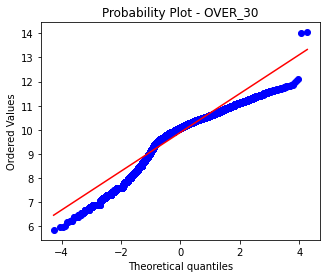

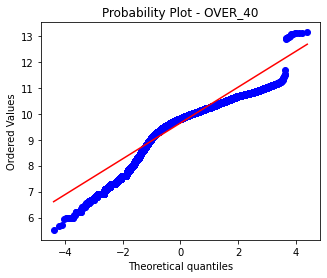

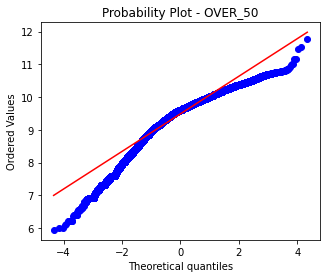

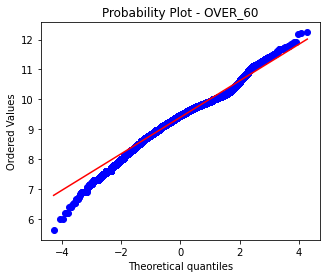

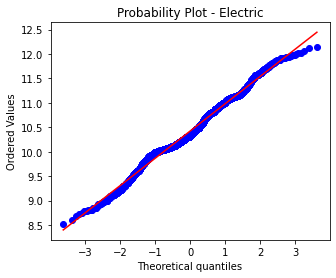

In [120]:
# PLOTS OF DISTRIBUTION FOR MPG variable

import numpy as np 
import scipy.stats as stats
import matplotlib.pyplot as plt

unique_mpg = df['mpg'].unique()
for mpg in unique_mpg:
    stats.probplot(df[df['mpg'] == mpg]['log_price'], dist="norm", plot=plt)
    plt.title("Probability Plot - " +  mpg)
    plt.show()

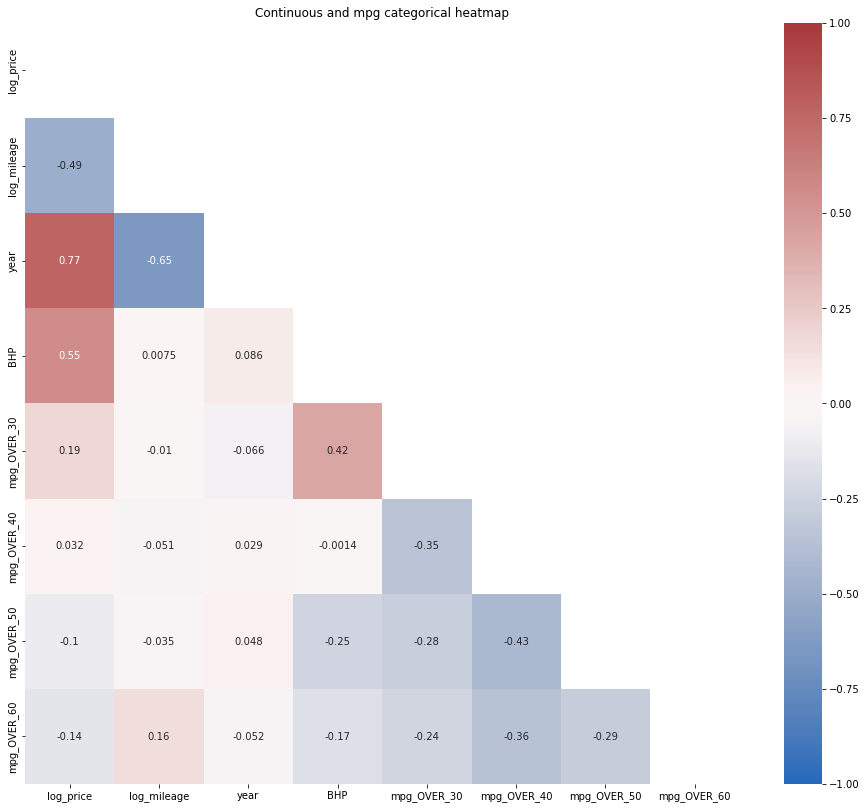

In [121]:
# Heatmap after dummies - choose the categorical  
to_dummy=['mpg','drivertrain','make','body','transmission','fuel','doors']

categorical = 'mpg'

X = df[['log_price','log_mileage','year','BHP',categorical]]
to_dummy=[categorical]
X= pd.get_dummies(X, columns = to_dummy, drop_first=True)

plt.rcParams["figure.figsize"] = (16,14)
mask =np.zeros_like(X.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(X.corr(), vmin=-1, vmax=1, cmap='vlag', mask=mask, annot=True)
plt.title(f'Continuous and {categorical} categorical heatmap')
plt.show()

# Modeling on 50,000 used cars

<b>EXECUTIVE SUMMARY</b>


<b>1. Project Goals</b>
* Generate a predictive model for used car prices which can be interpreted.
* Test the hypothesis that when all other car features are equal, a Dacia branded car is cheaper than a Volvo branded car. Learn what the model can tell us about car brands.
* Investigate how the car sale location affects asking price.


<b>2. Metrics Utilised</b>
* The main metric used will be R2-score, which is the amount of unexplained variance above the baseline which can be explained by the model. 
* Supplementary metrics of Root Mean Squared Error (RMSE) and Mean Squared Error (MSE) will be used to further evaluate models. 

<b>3. Results</b>
* A comprehensive used car dataset was scraped from autoTrader.co.uk, holding 374,000 used cars appropriate for modelling.
* Base versions of 10 different models were evaluated and ranked using a 50,000 row subset of the used car dataset. Two models - LinearRegression() and GradientBoostingRegression() were then selected for further model optimisation on the full dataset and subsequent model evaluation. 
    * Final LinearRegression() R2 score on the price target was 0.881. 
    * <b>Final GradientBoostingRegression() R2 score on the price target was 0.953</b>. 
    * Both models proved to generalise well, with test and train R2 scores within 0.003.
    * Of the top 10 predictors/features for each model, 6 of them were predictors/features in common.
* ELI5 permutation importance feature has been used to explain and interpret granular detail contained within the GradientBoostingRegression() model which is not evident from the standard gini-based feature importance. 
* Dummy cars were fed into the GradientBoostingRegression() model and analysed with ELI5 to confirm that <b>a Dacia branded car is indeed cheaper than a Volvo branded car</b>.
* No strong evidence has been found to suggest that car sale location impacts sale price, although further work is recommended.
    
<b>4. Risks/limitations/assumptions</b>
* All used car data were gathered over two weeks between January and February 2022. At this moment the second hand car market is artificially inflated due to 'ongoing chip shortages'. As such, the accuracy of all conclusions and insights will fall with time as market conditions change. 
* Outlier analysis has revealed some data-entry mistakes on autotrader.co.uk. Data-entry mistakes which can be observed as statistical anomalies have been removed from the dataset however this by no means confirms that others don't remain.
* When buying a new car there are often a number of tiers to choose from in terms of 'car spec'. Although some engine attributes may be incorporated in the 'BHP' statistic, much of this information is not captured at a used car sale and is not accounted for in this project. For example there is no information on whether a used car has a leather interior with rear view cameras and parking sensors.
* Car size variables could be obtained more accurately. At this stage they have been scraped from carsized.com.

In [122]:
# Import modelling libraries

from sklearn.svm import LinearSVR
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score 
from eli5.sklearn import PermutationImportance
from eli5 import show_prediction
import eli5
import xgboost
from xgboost import XGBRegressor
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))



First of all, I evaluate a range of models on a subset of 50,000 rows from the used cars data

* Outliers from the used car dataset are removed from the normally distributed log-price target variable.
* Car makes with < 50 cars within the subset are dropped to ensure robust predictions.
* Columns used for modelling are price/log_price, mileage/log_mileage, BHP, year, drivetrain, make, body, transmission, fuel and doors. 
    * price/log_price, mileage/log_mileage, BHP and year are continuous.
    * drivetrain, make, body, transmission, fuel and doors are one-hot encoded.
    * log_price and log_mileage are used for linear regression models, whilst price and mileage are used for tree-based models.
    * Standard scaling is applied to predictors for the linear regression models whilst no scaling is applied for the tree-based models.
* Models tested are:
    * Linear Regression
    * Linear Regression with L1 regularization
    * Linear Regression with L2 regularization
    * Linear Regression with Elastic Net regularization
    * Decision Tree Regression
    * Random Forest Regression
    * Gradient Boosting Regression
    * Ada Boosting Regression with a Decision Tree base model
    * Extreme Gradient Boosting Regression
* Each model is evaluated by mean R2 score after 5-fold cross validation on the training set as well as R2 score on the test set.
* Residuals are described using Mean Squared Error (MSE).
    

In [123]:
# Read clean used cars data 

abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/00_all_cars.csv'
df = pd.read_csv(abspath)
print('all',df.shape)

df = df[df['used']==1]
print('used',df.shape)

mask = np.abs((df.log_price - df.log_price.mean()) / df.log_price.std()) > 3
df= df[~mask]
print('used_without_outliers',df.shape)

all (400247, 36)
used (378597, 36)
used_without_outliers (374506, 36)


In [124]:
# Drop columns not useful in modelling

df = df.drop(labels=['name','name_subtitle','link','seller1',
                     'href0','dealer_city','dealer_area','year_reg',
                     'orig_name','e_engine_kWh','dealer_lat',
                     'dealer_lon','ULEZ','id','used'], axis=1)

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374506 entries, 0 to 400246
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   year               374506 non-null  int64  
 1   price              374506 non-null  float64
 2   body               374506 non-null  object 
 3   mileage            374506 non-null  float64
 4   BHP                374506 non-null  float64
 5   doors              374506 non-null  object 
 6   transmission       374506 non-null  object 
 7   make               374506 non-null  object 
 8   fuel               374506 non-null  object 
 9   mpg                374506 non-null  object 
 10  drivertrain        374506 non-null  object 
 11  engine             369816 non-null  float64
 12  owners             193983 non-null  float64
 13  county             373193 non-null  object 
 14  geocode            373193 non-null  object 
 15  county.1           373193 non-null  object 
 16  po

In [126]:
# Drop car makes which have less than 50 cars in the model evaluation subset
# This is done to prevent the model interpreting a small number of data points as statistically significant
dfsample = df.sample(50000, random_state=1)
carnums = dfsample.groupby(by='make')['price'].count().sort_values().reset_index()
carmakes = carnums[carnums.price>50].make.to_list()
dfsample = dfsample[dfsample.make.isin(carmakes)]

In [127]:
dfsample.shape

(49704, 21)

## LinearRegression()

*Why might I look to use a linear regression model?*

Having taken a log of the target variable (price) and the mileage predictor there now appears to be a number of linear relationships between the continuous predictors in the dataset. Although it comes loaded with assumptions, linear regression can be one of the most simple ML models to understand and so is a nice place to start. 

Linear regression within Sklearn implements an ordinary least squares regression, which works to minimise the residual sum of squares (RSS) to best fit the data. i.e. RSS is the loss function for linear regression.

In [128]:
# Modelling with dummies - SKLEARN LinearRegression() 

# Dummify necessary columns 
X = dfsample[['log_price','log_mileage','year','BHP','drivertrain',
        'make','body','transmission','fuel','doors']]
y = X.pop('log_price')
to_dummy=['drivertrain','make','body','transmission','fuel','doors']
X= pd.get_dummies(X, columns = to_dummy, drop_first=True)
print('Dummified df shape',X.shape,'\n')

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=y, random_state=42)

scaler = StandardScaler()
lr = LinearRegression()
pipelr = Pipeline(steps=[('scaler',scaler),('model',lr)])
#pipelr.get_params()

params = {'model__copy_X': [True],
          'model__fit_intercept': [True],
          'model__n_jobs': [2],
          'model__normalize': [False],
          'model__positive': [False]}

gridsearchlr = GridSearchCV(pipelr, params, cv=5, verbose=1)
gridsearchlr.fit(X_train, y_train)

# LinearRegression Model
train_preds = gridsearchlr.predict(X_train)
test_preds = gridsearchlr.predict(X_test)
printmd('**LINEAR REGRESSION**')
print('MSE train:',mean_squared_error(np.exp(y_train), np.exp(train_preds)))
print('MSE test:',mean_squared_error(np.exp(y_test), np.exp(test_preds)))
print('RMSE train:',np.sqrt((mean_squared_error(np.exp(y_train), np.exp(train_preds)))))
print('RMSE test:',np.sqrt((mean_squared_error(np.exp(y_test), np.exp(test_preds)))))
print('R2 train on log_price:',gridsearchlr.score(X_train, y_train))
print('R2 test on log_price:',gridsearchlr.score(X_test, y_test))
print('R2 train on price:',r2_score(np.exp(y_train), np.exp(train_preds)))
print('R2 test on price:',r2_score(np.exp(y_test), np.exp(test_preds)))
print('\n')
print(gridsearchlr.best_estimator_)

lrdict = {'Model': 'Linear Regression', 
          'MSE Train': mean_squared_error(np.exp(y_train), np.exp(train_preds)),
          'MSE Test': mean_squared_error(np.exp(y_test), np.exp(test_preds)),
          'RMSE Train': np.sqrt(mean_squared_error(np.exp(y_train), np.exp(train_preds))),
          'RMSE Test': np.sqrt(mean_squared_error(np.exp(y_test), np.exp(test_preds))),
          'R2 Train': r2_score(np.exp(y_train), np.exp(train_preds)),
          'R2 Test': r2_score(np.exp(y_test), np.exp(test_preds)),
          'Params': gridsearchlr.best_estimator_
         }

Dummified df shape (49704, 59) 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


**LINEAR REGRESSION**

MSE train: 18226444.18852435
MSE test: 18153031.052938305
RMSE train: 4269.24398325094
RMSE test: 4260.637399842693
R2 train on log_price: 0.9148265855544033
R2 test on log_price: 0.910917886536771
R2 train on price: 0.8722723397857292
R2 test on price: 0.8765880979178758


Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LinearRegression(n_jobs=2))])


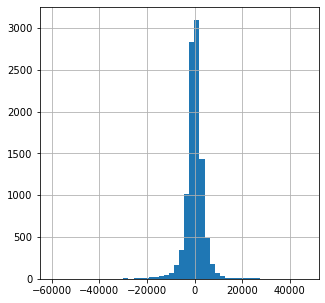

In [129]:
# Plot residuals
lr_resid_50 = np.exp(y_test) - np.exp(test_preds)
lr_resid_50.hist(bins=50, figsize=(5,5));

## Lasso()

Why might I look to use a Lasso regression model? Or a linear regression with L1 penalisation added to the loss function.

This builds on the RSS loss function in ordinary least squares regression by using the the RSS plus the sum of absolute values of all beta coefficients as the Lasso loss function. This form of regularisation can be useful when you have many predictors. 

<b>CHECK</b>

In [130]:
# Modelling with dummies - SKLEARN Lasso()

# Dummify necessary columns 
X = dfsample[['log_price','log_mileage','year','BHP','drivertrain',
        'make','body','transmission','fuel','doors']]
y = X.pop('log_price')
to_dummy=['drivertrain','make','body','transmission','fuel','doors']
X= pd.get_dummies(X, columns = to_dummy, drop_first=True)
print('Dummified df shape',X.shape,'\n')

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=y,random_state=42)

scaler = StandardScaler()
la = Lasso()
pipela = Pipeline(steps=[('scaler',scaler),('model',la)])
pipela.get_params()

params = {'model__alpha': [0.0001],
         'model__max_iter': [2000],
         'model__tol': [0.001]}

gridsearchla= GridSearchCV(pipela, params, cv=5, verbose=1)
gridsearchla.fit(X_train, y_train)

# Lasso Model
train_preds = gridsearchla.predict(X_train)
test_preds = gridsearchla.predict(X_test)
printmd('**LASSO**')
print('MSE train:',mean_squared_error(np.exp(y_train), np.exp(train_preds)))
print('MSE test:',mean_squared_error(np.exp(y_test), np.exp(test_preds)))
print('RMSE train:',np.sqrt((mean_squared_error(np.exp(y_train), np.exp(train_preds)))))
print('RMSE test:',np.sqrt((mean_squared_error(np.exp(y_test), np.exp(test_preds)))))
print('R2 train on log_price:',gridsearchla.score(X_train, y_train))
print('R2 test on log_price:',gridsearchla.score(X_test, y_test))
print('R2 train on price:',r2_score(np.exp(y_train), np.exp(train_preds)))
print('R2 test on price:',r2_score(np.exp(y_test), np.exp(test_preds)))
print('\n')
print(gridsearchla.best_estimator_)

ladict = {'Model': 'Lasso (L1) Regression', 
          'MSE Train': mean_squared_error(np.exp(y_train), np.exp(train_preds)),
          'MSE Test': mean_squared_error(np.exp(y_test), np.exp(test_preds)),
          'RMSE Train': np.sqrt(mean_squared_error(np.exp(y_train), np.exp(train_preds))),
          'RMSE Test': np.sqrt(mean_squared_error(np.exp(y_test), np.exp(test_preds))), 
          'R2 Train': r2_score(np.exp(y_train), np.exp(train_preds)),
          'R2 Test': r2_score(np.exp(y_test), np.exp(test_preds)),
          'Params': gridsearchla.best_estimator_,
         }

Dummified df shape (49704, 59) 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


**LASSO**

MSE train: 18179928.07266254
MSE test: 18124800.37065201
RMSE train: 4263.792686407553
RMSE test: 4257.323146139133
R2 train on log_price: 0.9148200089213092
R2 test on log_price: 0.9108970522620704
R2 train on price: 0.8725983164040882
R2 test on price: 0.8767800219105065


Pipeline(steps=[('scaler', StandardScaler()),
                ('model', Lasso(alpha=0.0001, max_iter=2000, tol=0.001))])


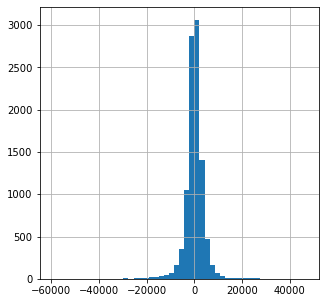

In [131]:
# Plot residuals
la_resid_50 = np.exp(y_test) - np.exp(test_preds)
la_resid_50.hist(bins=50, figsize=(5,5));

## Ridge()

Why might I look to use a Ridge regression model? Or a linear regression with L2 penalisation added to the loss function.

This builds on the RSS loss function in ordinary least squares regression by using the the RSS plus the sum of squares of all beta coefficients as the Ridge loss function. This form of regularisation can be useful when you have multi-collinnearity within the dataset.

<b>CHECK</b>

In [132]:
# Modelling with dummies - SKLEARN Ridge()

# Dummify necessary columns 
X = dfsample[['log_price','log_mileage','year','BHP','drivertrain',
        'make','body','transmission','fuel','doors']]
y = X.pop('log_price')
to_dummy=['drivertrain','make','body','transmission','fuel','doors']
X= pd.get_dummies(X, columns = to_dummy, drop_first=True)
print('Dummified df shape',X.shape,'\n')

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=y,random_state=42)

scaler = StandardScaler()
rr = Ridge()
piperr = Pipeline(steps=[('scaler',scaler),('model',rr)])
piperr.get_params()

params = {'model__alpha': [0.5,1,5,50,5000],
         'model__max_iter': [200],
         'model__solver': ['auto'],
         'model__tol': [0.001]}

gridsearchrr = GridSearchCV(piperr, params, cv=5, verbose=1)
gridsearchrr.fit(X_train, y_train)

# RIDGE Model
train_preds = gridsearchrr.predict(X_train)
test_preds = gridsearchrr.predict(X_test)
print('RIDGE')
print('MSE train:',mean_squared_error(np.exp(y_train), np.exp(train_preds)))
print('MSE test:',mean_squared_error(np.exp(y_test), np.exp(test_preds)))
print('RMSE train:',np.sqrt((mean_squared_error(np.exp(y_train), np.exp(train_preds)))))
print('RMSE test:',np.sqrt((mean_squared_error(np.exp(y_test), np.exp(test_preds)))))
print('R2 train on log_price:',gridsearchrr.score(X_train, y_train))
print('R2 test on log_price:',gridsearchrr.score(X_test, y_test))
print('R2 train on price:',r2_score(np.exp(y_train), np.exp(train_preds)))
print('R2 test on price:',r2_score(np.exp(y_test), np.exp(test_preds)))
print('\n')
print(gridsearchrr.best_estimator_)

rrdict = {'Model': 'Ridge (L2) Regression', 
          'MSE Train': mean_squared_error(np.exp(y_train), np.exp(train_preds)),
          'MSE Test': mean_squared_error(np.exp(y_test), np.exp(test_preds)),
          'RMSE Train': np.sqrt(mean_squared_error(np.exp(y_train), np.exp(train_preds))),
          'RMSE Test': np.sqrt(mean_squared_error(np.exp(y_test), np.exp(test_preds))), 
          'R2 Train': r2_score(np.exp(y_train), np.exp(train_preds)),
          'R2 Test': r2_score(np.exp(y_test), np.exp(test_preds)),
          'Params': gridsearchrr.best_estimator_
         }

Dummified df shape (49704, 59) 

Fitting 5 folds for each of 5 candidates, totalling 25 fits
RIDGE
MSE train: 18220887.465141874
MSE test: 18151544.57105949
RMSE train: 4268.593148233019
RMSE test: 4260.4629526683475
R2 train on log_price: 0.9148259176018989
R2 test on log_price: 0.9109059798963477
R2 train on price: 0.8723112803091115
R2 test on price: 0.8765982036437758


Pipeline(steps=[('scaler', StandardScaler()),
                ('model', Ridge(alpha=5, max_iter=200))])


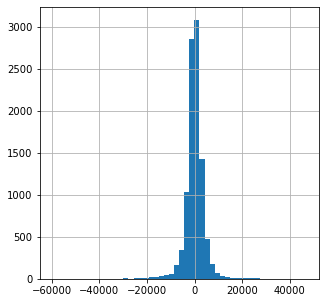

In [133]:
# Plot residuals
rr_resid_50 = np.exp(y_test) - np.exp(test_preds)
rr_resid_50.hist(bins=50, figsize=(5,5));

## ElasticNet() 

Why might I look to use a Elastic Net regression model? Or a linear regression with both L1 and L2 penalisation added to the loss function.

This can combine the best of both worlds. Where the optimum regressor is neither ridge nor lasso, this can blend the two loss functions to find the sweet spot in the middle.  

<b>CHECK - I don't think I really need to go into this detail for all these rapid fire models. Do I?</b>

In [134]:
# Modelling with dummies - SKLEARN ElasticNet()

# Dummify necessary columns 
X = dfsample[['log_price','log_mileage','year','BHP','drivertrain',
        'make','body','transmission','fuel','doors']]
y = X.pop('log_price')
to_dummy=['drivertrain','make','body','transmission','fuel','doors']
X= pd.get_dummies(X, columns = to_dummy, drop_first=True)
print('Dummified df shape',X.shape,'\n')

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=y,random_state=42)

scaler = StandardScaler()
en = ElasticNet()
pipeen = Pipeline(steps=[('scaler',scaler),('model',en)])
pipeen.get_params()

params = {'model__alpha': [0.0001], 
          'model__l1_ratio': [0,0.25,0.5,0.75, 1],#np.linspace(0.001,1,25),
          'model__max_iter': [1000, 2000],#,1000,2000],
          'model__random_state': [1],
          'model__tol': [0.01]}

# params = {'model__alpha': [0.0001], 
#           'model__l1_ratio': [ 1],#np.linspace(0.001,1,25),
#           'model__max_iter': [2000],#,1000,2000],
#           'model__random_state': [1],
#           'model__tol': [0.01]}

gridsearchen = GridSearchCV(pipeen, params, cv=5, verbose=0)
gridsearchen.fit(X_train, y_train)

# ELASTIC NET Model
train_preds = gridsearchen.predict(X_train)
test_preds = gridsearchen.predict(X_test)
print('ELASTIC NET')
print('MSE train:',mean_squared_error(np.exp(y_train), np.exp(train_preds)))
print('MSE test:',mean_squared_error(np.exp(y_test), np.exp(test_preds)))
print('RMSE train:',np.sqrt((mean_squared_error(np.exp(y_train), np.exp(train_preds)))))
print('RMSE test:',np.sqrt((mean_squared_error(np.exp(y_test), np.exp(test_preds)))))
print('R2 train on log_price:',gridsearchen.score(X_train, y_train))
print('R2 test on log_price:',gridsearchen.score(X_test, y_test))
print('R2 train on price:',r2_score(np.exp(y_train), np.exp(train_preds)))
print('R2 test on price:',r2_score(np.exp(y_test), np.exp(test_preds)))
print('\n')
print(gridsearchen.best_estimator_)


eldict = {'Model': 'Elastic Net Regression', 
          'MSE Train': mean_squared_error(np.exp(y_train), np.exp(train_preds)),
          'MSE Test': mean_squared_error(np.exp(y_test), np.exp(test_preds)),
          'RMSE Train': np.sqrt(mean_squared_error(np.exp(y_train), np.exp(train_preds))),
          'RMSE Test': np.sqrt(mean_squared_error(np.exp(y_test), np.exp(test_preds))),
          'R2 Train': r2_score(np.exp(y_train), np.exp(train_preds)),
          'R2 Test': r2_score(np.exp(y_test), np.exp(test_preds)),
          'Params': gridsearchen.best_estimator_
         }

Dummified df shape (49704, 59) 



/Users/robertdavies/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 620.2255741145538, tolerance: 145.43400433285586
  model = cd_fast.enet_coordinate_descent(
/Users/robertdavies/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 613.0612163897978, tolerance: 144.77564552479143
  model = cd_fast.enet_coordinate_descent(
/Users/robertdavies/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 615.1504930288635, tolerance: 145.71896607496225
  model = cd_fast.enet_coordinate_descent(
/Users/robertdavies/opt/anaconda3/lib/python3.9/s

ELASTIC NET
MSE train: 18207665.506493643
MSE test: 18144877.947326843
RMSE train: 4267.044118179896
RMSE test: 4259.68049826825
R2 train on log_price: 0.9148228334905714
R2 test on log_price: 0.9108948013796638
R2 train on price: 0.8724039374299477
R2 test on price: 0.8766435261418707


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 ElasticNet(alpha=0.0001, l1_ratio=0.25, random_state=1,
                            tol=0.01))])


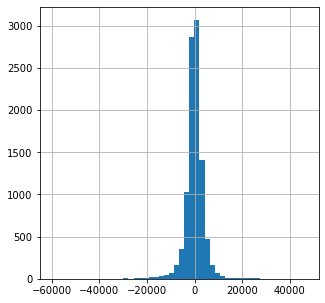

In [135]:
# Plot residuals
en_resid_50 = np.exp(y_test) - np.exp(test_preds)
en_resid_50.hist(bins=50, figsize=(5,5));

## DecisionTreeRegressor()

In [136]:
# Modelling with dummies - SKLEARN DecisionTreeRegressor() 

# Dummify necessary columns 
X = dfsample[['price','mileage','year','BHP','drivertrain',
        'make','body','transmission','fuel','doors']]
y = X.pop('price')
to_dummy=['drivertrain','make','body','transmission','fuel','doors']
X= pd.get_dummies(X, columns = to_dummy, drop_first=True)
print('Dummified df shape',X.shape,'\n')

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=y, random_state=42)

#scaler = StandardScaler()
dt = DecisionTreeRegressor()
#pipedt = Pipeline(steps=[('scaler',scaler),('model',dt)])
pipedt = Pipeline(steps=[('model',dt)])
pipedt.get_params()

params = {'model__criterion': ['mse', 'friedman_mse', 'poisson'],
         'model__max_depth': [15,50,100],
         'model__max_leaf_nodes': [500,1000,2000],
         'model__min_samples_leaf': [25,50,100],
         'model__splitter': ['best']}

gridsearchdt = GridSearchCV(pipedt, params, cv=5, verbose=1)
gridsearchdt.fit(X_train, y_train)

# DECISION TREE
train_preds = gridsearchdt.predict(X_train)
test_preds = gridsearchdt.predict(X_test)
print('DECISION TREE REGRESSOR')
print('MSE train:',mean_squared_error(y_train, train_preds))
print('MSE test:',mean_squared_error(y_test, test_preds))
print('RMSE train:',np.sqrt((mean_squared_error(y_train, train_preds))))
print('RMSE test:',np.sqrt((mean_squared_error(y_test, test_preds))))
print('R2 train:',gridsearchdt.score(X_train, y_train))
print('R2 test:',gridsearchdt.score(X_test, y_test))
print('\n')

print(gridsearchdt.best_estimator_)

dtdict = {'Model': 'Decision Tree Regressor', 
          'MSE Train': mean_squared_error(y_train, train_preds),
          'MSE Test': mean_squared_error(y_test, test_preds),
          'RMSE Train': np.sqrt(mean_squared_error(y_train, train_preds)),
          'RMSE Test': np.sqrt(mean_squared_error(y_test, test_preds)),
          'R2 Train': gridsearchdt.score(X_train, y_train),
          'R2 Test': gridsearchdt.score(X_test, y_test),
          'Params': gridsearchdt.best_estimator_
         }

Dummified df shape (49704, 59) 

Fitting 5 folds for each of 81 candidates, totalling 405 fits
DECISION TREE REGRESSOR
MSE train: 11381980.618193997
MSE test: 14036074.375335593
RMSE train: 3373.719107779128
RMSE test: 3746.474926559044
R2 train: 0.9202371160315829
R2 test: 0.9045768923451522


Pipeline(steps=[('model',
                 DecisionTreeRegressor(criterion='friedman_mse', max_depth=100,
                                       max_leaf_nodes=1000,
                                       min_samples_leaf=25))])


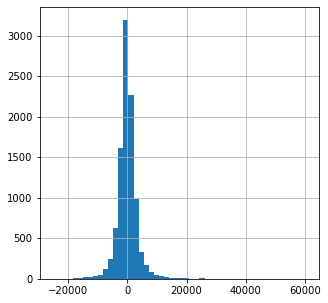

In [137]:
# Plot residuals
dt_resid_50 = y_test - test_preds
dt_resid_50.hist(bins=50, figsize=(5,5));

## RandomForestRegressor()

In [138]:
# Modelling with dummies - SKLEARN RandomForestRegressor()) 

# Dummify necessary columns 
X = dfsample[['price','mileage','year','BHP','drivertrain',
        'make','body','transmission','fuel','doors']]
y = X.pop('price')
to_dummy=['drivertrain','make','body','transmission','fuel','doors']
X= pd.get_dummies(X, columns = to_dummy, drop_first=True)
print('Dummified df shape',X.shape,'\n')

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=y, random_state=42)

scaler = StandardScaler()
rf = RandomForestRegressor()
#piperf = Pipeline(steps=[('scaler',scaler),('model',rf)])
piperf = Pipeline(steps=[('model',rf)])
piperf.get_params()

params = {'model__max_depth': [3,5,8,15],
          'model__n_estimators': [50,100,200],
          'model__n_jobs': [3],
          'model__max_features': [0.3, 0.5, 'auto']}

gridsearchrf = GridSearchCV(piperf, params, cv=5, verbose=1)
gridsearchrf.fit(X_train, y_train)

# SKLEARN Model
train_preds = gridsearchrf.predict(X_train)
test_preds = gridsearchrf.predict(X_test)
print('RANDOM FOREST REGRESSOR')
print('MSE train:',mean_squared_error(y_train, train_preds))
print('MSE test:',mean_squared_error(y_test, test_preds))
print('RMSE train:',np.sqrt(mean_squared_error(y_train, train_preds)))
print('RMSE test:',np.sqrt(mean_squared_error(y_test, test_preds)))
print('R2 train:',gridsearchrf.score(X_train, y_train))
print('R2 test:',gridsearchrf.score(X_test, y_test))
print('\n')
print(gridsearchrf.best_estimator_)

rfdict = {'Model': 'Random Forrest Regressor', 
          'MSE Train': mean_squared_error(y_train, train_preds),
          'MSE Test': mean_squared_error(y_test, test_preds), 
          'RMSE Train': np.sqrt(mean_squared_error(y_train, train_preds)),
          'RMSE Test': np.sqrt(mean_squared_error(y_test, test_preds)), 
          'R2 Train': gridsearchrf.score(X_train, y_train),
          'R2 Test': gridsearchrf.score(X_test, y_test),
          'Params': gridsearchrf.best_estimator_
         }

Dummified df shape (49704, 59) 

Fitting 5 folds for each of 36 candidates, totalling 180 fits
RANDOM FOREST REGRESSOR
MSE train: 2897516.8983793957
MSE test: 7051288.519368579
RMSE train: 1702.2094167226885
RMSE test: 2655.4262406191174
R2 train: 0.9796947199336704
R2 test: 0.9520623897041004


Pipeline(steps=[('model',
                 RandomForestRegressor(max_depth=15, max_features=0.5,
                                       n_estimators=200, n_jobs=3))])


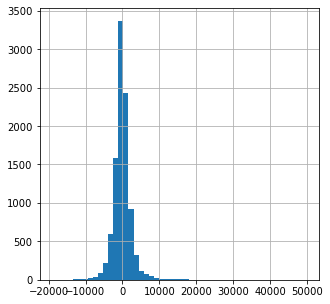

In [139]:
# Plot residuals
rf_resid_50 = y_test - test_preds
rf_resid_50.hist(bins=50, figsize=(5,5));

## OLS() - Achieves same result as LinearRegression()

*Why might I look to use a linear regression model?*

Having taken a log of the target variable (price) and the mileage predictor there now appears to be a number of linear relationships between the continuous predictors in the dataset. Although it comes loaded with assumptions, linear regression can be one of the most simple ML models to understand and so is a nice place to start. 

Linear regression within Sklearn implements an ordinary least squares regression, which works to minimise the residual sum of squares (RSS) to best fit the data. i.e. RSS is the loss function for linear regression.

These sentiments are the same as before  - I used OLS to have a nosey at some p-values

In [140]:
# I don't actually intend to include this - it was just a sanity check for me 

In [141]:
# Modelling with dummies - STATSMODELS LinearRegression() - No pipeline or gridsearch (ASK!) 

# Dummify necessary columns 
X = dfsample[['log_price','log_mileage','year','BHP','drivertrain',
        'make','body','transmission','fuel','doors']]
y = X.pop('log_price')
to_dummy=['drivertrain','make','body','transmission','fuel','doors']
X= pd.get_dummies(X, columns = to_dummy, drop_first=True)
print('Dummified df shape',X.shape,'\n')

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=y,random_state=42)

# scaler = StandardScaler()
# smlr = sm.OLS(y_train, sm.add_constant(X_train))
# pipesmlr = Pipeline(steps=[('scaler',scaler),('model',smlr)])
# pipesmlr.get_params()

# params = {'model__copy_X': True,
#           'model__fit_intercept': True,
#           'model__n_jobs': [2],
#           'model__normalize': False,
#           'model__positive': False}

# gridsearchsmlr = GridSearchCV(pipesmlr, params, cv=5, verbose=1)
# gridsearchsmlr.fit(X_train, y_train)

# Standardise
sc=StandardScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(sc.transform(X_test), columns = X_test.columns)

# STATSMODEL Model
y_train = list(y_train)
y_test = list(y_test)
smlr = sm.OLS(y_train, sm.add_constant(X_train))
results = smlr.fit()
train_predictions = results.predict(sm.add_constant(X_train))
test_predictions = results.predict(sm.add_constant(X_test,has_constant='add'))
print('STATSMODELS OLS')
print("MSE train:", mean_squared_error(y_train, train_predictions))
print("MSE test:", mean_squared_error(y_test, test_predictions))
# print('RMSE train:',np.sqrt((mean_squared_error(np.exp(y_train), np.exp(train_preds)))))
# print('RMSE test:',np.sqrt((mean_squared_error(np.exp(y_test), np.exp(test_preds)))))
print("R2 train: ", r2_score(y_train, train_predictions))
print("R2 test: ", r2_score(y_test, test_predictions))

results.summary( )

Dummified df shape (49704, 59) 

STATSMODELS OLS
MSE train: 0.03890285848721093
MSE test: 0.04067449857237313
R2 train:  0.9148265855544033
R2 test:  0.9109178865367709


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     7228.
Date:                Thu, 03 Mar 2022   Prob (F-statistic):               0.00
Time:                        21:37:22   Log-Likelihood:                 8127.8
No. Observations:               39763   AIC:                        -1.614e+04
Df Residuals:                   39703   BIC:                        -1.562e+04
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             9.6388      0.001   9737.376      0.000       9.637       9.641
log_mileage                      -0.0586      0.001    -42.669      0.000      -0.061      -0.056
year                              0.4384      0.001    317.188      0.000       0.436       0.441
BHP                               0.2167      0.002    137.823      0.000       0.214       0.220
drivertrain_Front Wheel Drive    -0.0129      0.002     -6.904      0.000      -0.017      -0.009
drivertrain_Rear Wheel Drive     -0.0003      0.002     -0.191      0.849      -0.004       0.003
make_Alfa Romeo                  -0.0014      0.001     -1.037      0.300      -0.004       0.001
make_Audi                         0.0693      0.006     12.435      0.000       0.058       0.080
make_BMW                          0.0407      0.006      6.696      0.000       0.029       0.053
make_Citroen                     -0.0188      0.003     -6.413      0.000      -0.025      -0.013
make_DS Automobiles              -0.0062      0.001     -4.486      0.000      -0.009      -0.003
make_Dacia                       -0.0191      0.002    -10.472      0.000      -0.023      -0.016
make_Fiat                        -0.0212      0.003     -8.031      0.000      -0.026      -0.016
make_Ford                         0.0061      0.006      1.065      0.287      -0.005       0.017
make_Honda                        0.0129      0.003      4.380      0.000       0.007       0.019
make_Hyundai                     -0.0097      0.003     -3.114      0.002      -0.016      -0.004
make_Jaguar                       0.0244      0.003      8.967      0.000       0.019       0.030
make_Jeep                        -0.0013      0.002     -0.827      0.409      -0.004       0.002
make_KIA                         -0.0058      0.004     -1.646      0.100      -0.013       0.001
make_Land Rover                   0.0751      0.004     18.251      0.000       0.067       0.083
make_Lexus                        0.0128      0.002      6.957      0.000       0.009       0.016
make_MG                          -0.0124      0.001     -8.306      0.000      -0.015      -0.009
make_MINI                         0.0175      0.004      4.449      0.000       0.010       0.025
make_Mazda                        0.0095      0.003      3.584      0.000       0.004       0.015
make_Mercedes-Benz                0.0717      0.006     12.848      0.000       0.061       0.083
make_Mitsubishi                  -0.0017      0.002     -0.884      0.377      -0.006       0.002
make_Nissan                      -0.0055      0.004     -1.230      0.219      -0.014       0.003
make_Peugeot                     -0.0128      0.004     -3.229      0.001      -0.021      -0.005
make_Porsche                      0.0541     

## GradientBoostingRegressor()

In [142]:
# Modelling with dummies - SKLEARN GradientBoostingRegressor()) 

# Dummify necessary columns 
X = dfsample[['price','log_mileage','year','BHP','drivertrain',
        'make','body','transmission','fuel','doors']]
y = X.pop('price')
to_dummy=['drivertrain','make','body','transmission','fuel','doors']
X= pd.get_dummies(X, columns = to_dummy, drop_first=True)
print('Dummified df shape',X.shape,'\n')

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=y,random_state=42)

scaler = StandardScaler()
model = GradientBoostingRegressor()
#pipegb = Pipeline(steps=[('scaler',scaler),('model',model)])
pipegb = Pipeline(steps=[('model',model)])
pipegb.get_params()

# params = {'model__n_estimators':[100,200],
#           'model__max_depth':[3,5,8],
#           'model__learning_rate':[0.05,0.1,0.2],
#           'model__random_state':[1],
#           'model__validation_fraction':[0.1],
#           'model__n_iter_no_change':[20]}

params = {'model__n_estimators':[200],
          'model__max_depth':[8],
          'model__learning_rate':[0.1],
          'model__random_state':[1],
          'model__validation_fraction':[0.1],
          'model__n_iter_no_change':[20]}

gridsearchgb = GridSearchCV(pipegb, params, cv=5, verbose=1)
gridsearchgb.fit(X_train, y_train)

# SKLEARN Model
train_preds = gridsearchgb.predict(X_train)
test_preds = gridsearchgb.predict(X_test)
print('GRADIENT BOOSTING REGRESSOR')
print('MSE train:',mean_squared_error(y_train, train_preds))
print('MSE test:',mean_squared_error(y_test, test_preds))
print('RMSE train:',np.sqrt(mean_squared_error(y_train, train_preds)))
print('RMSE test:',np.sqrt(mean_squared_error(y_test, test_preds)))
print('R2 train:',gridsearchgb.score(X_train, y_train))
print('R2 test:',gridsearchgb.score(X_test, y_test))
print('\n')
print(gridsearchgb.best_estimator_)

gbdict = {'Model': 'Gradient Boosting Regressor', 
          'MSE Train': mean_squared_error(y_train, train_preds),
          'MSE Test': mean_squared_error(y_test, test_preds), 
          'RMSE Train': np.sqrt(mean_squared_error(y_train, train_preds)),
          'RMSE Test': np.sqrt(mean_squared_error(y_test, test_preds)),
          'R2 Train': gridsearchgb.score(X_train, y_train),
          'R2 Test': gridsearchgb.score(X_test, y_test),
          'Params': gridsearchgb.best_estimator_
         }

Dummified df shape (49704, 59) 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
GRADIENT BOOSTING REGRESSOR
MSE train: 3321441.536238563
MSE test: 6442651.285487366
RMSE train: 1822.482245795158
RMSE test: 2538.237830757269
R2 train: 0.9767239319104627
R2 test: 0.9562001603327208


Pipeline(steps=[('model',
                 GradientBoostingRegressor(max_depth=8, n_estimators=200,
                                           n_iter_no_change=20,
                                           random_state=1))])


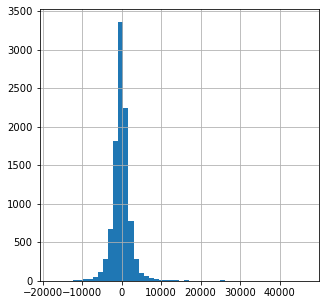

In [143]:
# Plot resiudals
gb_resid_50 = y_test - test_preds
gb_resid_50.hist(bins=50, figsize=(5,5));

## AdaBoostRegressor()

In [144]:
# Modelling with dummies - SKLEARN AdaBoostRegressor()) 

# Dummify necessary columns 
X = dfsample[['price','mileage','year','BHP','drivertrain',
        'make','body','transmission','fuel','doors']]
y = X.pop('price')
to_dummy=['drivertrain','make','body','transmission','fuel','doors']
X= pd.get_dummies(X, columns = to_dummy, drop_first=True)
print('Dummified df shape',X.shape,'\n')

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=y,random_state=42)

#scaler = StandardScaler()
modelab = AdaBoostRegressor()
#pipeab = Pipeline(steps=[('scaler',scaler),('model',modelab)]
pipeab = Pipeline(steps=[('model',modelab)])
pipeab.get_params()

# params = {'model__base_estimator':[gridsearchdt.best_estimator_.named_steps["model"]],
#           'model__n_estimators':[50,100, 200],
#           'model__learning_rate':[0.5,1.0,2.0],
#           'model__loss':['linear', 'square', 'exponential'],
#           'model__random_state':[1]}

params = {'model__base_estimator':[gridsearchdt.best_estimator_.named_steps["model"]],
          'model__n_estimators':[100],
          'model__learning_rate':[0.5],
          'model__loss':['exponential'],
          'model__random_state':[1]}

gridsearchab = GridSearchCV(pipeab, params, cv=5, verbose=1)
gridsearchab.fit(X_train, y_train)

train_preds = gridsearchab.predict(X_train)
test_preds = gridsearchab.predict(X_test)
print('ADA BOOST')
print('MSE train:',mean_squared_error(y_train, train_preds))
print('MSE test:',mean_squared_error(y_test, test_preds))
print('RMSE train:',np.sqrt(mean_squared_error(y_train, train_preds)))
print('RMSE test:',np.sqrt(mean_squared_error(y_test, test_preds)))
print('R2 train:',gridsearchab.score(X_train, y_train))
print('R2 test:',gridsearchab.score(X_test, y_test))
print(gridsearchab.best_estimator_)

abdict = {'Model': 'Ada Boosting Regressor', 
          'MSE Train': mean_squared_error(y_train, train_preds),
          'MSE Test': mean_squared_error(y_test, test_preds),
          'RMSE Train': np.sqrt(mean_squared_error(y_train, train_preds)),
          'RMSE Test': np.sqrt(mean_squared_error(y_test, test_preds)),
          'R2 Train': gridsearchab.score(X_train, y_train),
          'R2 Test': gridsearchab.score(X_test, y_test),
          'Params': gridsearchab.best_estimator_
         }

Dummified df shape (49704, 59) 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
ADA BOOST
MSE train: 4199711.39591105
MSE test: 8666485.02075507
RMSE train: 2049.3197397944155
RMSE test: 2943.8894375901873
R2 train: 0.9705691738538521
R2 test: 0.9410816079332107
Pipeline(steps=[('model',
                 AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='friedman_mse',
                                                                        max_depth=100,
                                                                        max_leaf_nodes=1000,
                                                                        min_samples_leaf=25),
                                   learning_rate=0.5, loss='exponential',
                                   n_estimators=100, random_state=1))])


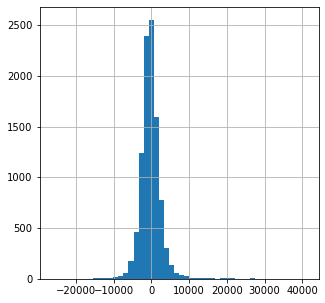

In [145]:
# Plot residuals
ab_resid_50 = y_test - test_preds
ab_resid_50.hist(bins=50, figsize=(5,5));

## XGBRegressor()

In [146]:
# Modelling with dummies - XGBOOST()) 

# Dummify necessary columns 
X = dfsample[['price','mileage','year','BHP','drivertrain',
        'make','body','transmission','fuel','doors']]
y = X.pop('price')
to_dummy=['drivertrain','make','body','transmission','fuel','doors']
X= pd.get_dummies(X, columns = to_dummy, drop_first=True)
print('Dummified df shape',X.shape,'\n')

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=y, random_state=42)

#scaler = StandardScaler()
xgb = XGBRegressor()
#pipexgb = Pipeline(steps=[('scaler',scaler),('model',xgb)])
pipexgb = Pipeline(steps=[('model',xgb)])
pipexgb.get_params()

params = {'model__n_estimators':[50,100,200],
          'model__max_depth':[3,5,8],
          'model__learning_rate':[0.05,0.1,0.2],
          'model__random_state':[1],
          'model__n_jobs':[3]}

# params = {'model__n_estimators':[100,200],
#           'model__max_depth':[3,5,8],
#           'model__learning_rate':[0.1],
#           'model__random_state':[1],
#           'model__n_jobs':[3]}


gridsearchxgb = GridSearchCV(pipexgb, params, cv=5, verbose=1)
gridsearchxgb.fit(X_train, y_train)

# XGBOOST Model
train_preds = gridsearchxgb.predict(X_train)
test_preds = gridsearchxgb.predict(X_test)
print('XGBOOSTING REGRESSOR')
print('MSE train:',mean_squared_error(y_train, train_preds))
print('MSE test:',mean_squared_error(y_test, test_preds))
print('RMSE train:',np.sqrt(mean_squared_error(y_train, train_preds)))
print('RMSE test:',np.sqrt(mean_squared_error(y_test, test_preds)))
print('R2 train:',gridsearchxgb.score(X_train, y_train))
print('R2 test:',gridsearchxgb.score(X_test, y_test))
print('\n')
print(gridsearchxgb.best_estimator_)

xgbdict = {'Model': 'XGBOOST Regressor', 
          'MSE Train': mean_squared_error(y_train, train_preds),
          'MSE Test': mean_squared_error(y_test, test_preds),
          'RMSE Train': np.sqrt(mean_squared_error(y_train, train_preds)),
          'RMSE Test': np.sqrt(mean_squared_error(y_test, test_preds)),
          'R2 Train': gridsearchxgb.score(X_train, y_train),
          'R2 Test': gridsearchxgb.score(X_test, y_test),
          'Params': gridsearchxgb.best_estimator_
         }

Dummified df shape (49704, 59) 

Fitting 5 folds for each of 27 candidates, totalling 135 fits
XGBOOSTING REGRESSOR
MSE train: 2376155.679193917
MSE test: 6099832.443283638
RMSE train: 1541.4784069826983
RMSE test: 2469.7838859470353
R2 train: 0.9833483260876864
R2 test: 0.9585307862905884


Pipeline(steps=[('model',
                 XGBRegressor(learning_rate=0.2, max_depth=8, n_estimators=200,
                              n_jobs=3, random_state=1))])


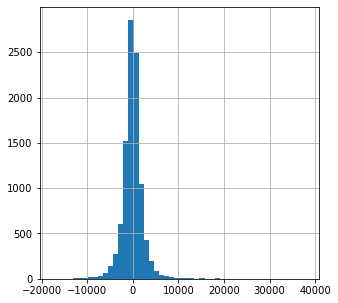

In [147]:
# Plot residuals
xgb_resid_50 = y_test - test_preds
xgb_resid_50.hist(bins=50, figsize=(5,5));

## Summary of models

In [148]:
pd.DataFrame([lrdict,ladict,rrdict,eldict,dtdict,rfdict,gbdict,abdict,xgbdict])

,Model,MSE Train,MSE Test,RMSE Train,RMSE Test,R2 Train,R2 Test,Params
0,Linear Regression,1.822644e+07,1.815303e+07,4269.243983,4260.637400,0.872272,0.876588,"(StandardScaler(), LinearRegression(n_jobs=2))"
1,Lasso (L1) Regression,1.817993e+07,1.812480e+07,4263.792686,4257.323146,0.872598,0.876780,"(StandardScaler(), Lasso(alpha=0.0001, max_ite..."
2,Ridge (L2) Regression,1.822089e+07,1.815154e+07,4268.593148,4260.462953,0.872311,0.876598,"(StandardScaler(), Ridge(alpha=5, max_iter=200))"
3,Elastic Net Regression,1.820767e+07,1.814488e+07,4267.044118,4259.680498,0.872404,0.876644,"(StandardScaler(), ElasticNet(alpha=0.0001, l1..."
4,Decision Tree Regressor,1.138198e+07,1.403607e+07,3373.719108,3746.474927,0.920237,0.904577,(DecisionTreeRegressor(criterion='friedman_mse...
5,Random Forrest Regressor,2.897517e+06,7.051289e+06,1702.209417,2655.426241,0.979695,0.952062,"((DecisionTreeRegressor(max_depth=15, max_feat..."
6,Gradient Boosting Regressor,3.321442e+06,6.442651e+06,1822.482246,2538.237831,0.976724,0.956200,(([DecisionTreeRegressor(criterion='friedman_m...
7,Ada Boosting Regressor,4.199711e+06,8.666485e+06,2049.319740,2943.889438,0.970569,0.941082,((DecisionTreeRegressor(criterion='friedman_ms...
8,XGBOOST Regressor,2.376156e+06,6.099832e+06,1541.478407,2469.783886,0.983348,0.958531,"(XGBRegressor(learning_rate=0.2, max_depth=8, ..."




We have lots of very good R2 scores here - the price of a car must be well described by the predictors that were gathered from AutoTrader.

I think that the R2 scores for models 1-3 is actually flawed - this is explained variance in the log-price rather than price. All other scores have been converted to price... maybe I can do the same here

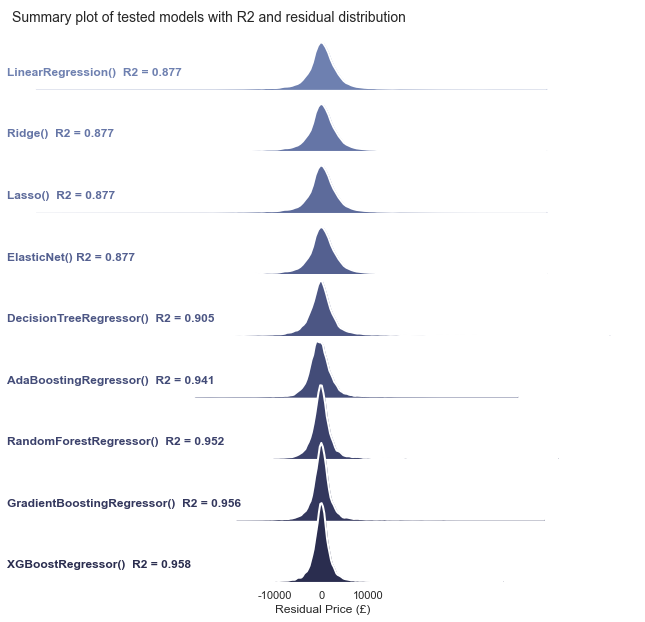

In [149]:
# Ambitious Residuals plot - needs work on X-axis

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Make the input data - really clumsy.
lr_resid50_df = pd.DataFrame(lr_resid_50)
lr_resid50_df['model']='LinearRegression()  R2 = 0.877'
lr_resid50_df.columns = ['price', 'model']
la_resid50_df = pd.DataFrame(la_resid_50)
la_resid50_df['model']='Ridge()  R2 = 0.877'
la_resid50_df.columns = ['price', 'model']
rr_resid50_df = pd.DataFrame(rr_resid_50)
rr_resid50_df['model']='Lasso()  R2 = 0.877'
rr_resid50_df.columns = ['price', 'model']
en_resid50_df = pd.DataFrame(en_resid_50)
en_resid50_df['model']='ElasticNet() R2 = 0.877'
en_resid50_df.columns = ['price', 'model']
dt_resid50_df = pd.DataFrame(dt_resid_50)
dt_resid50_df['model']='DecisionTreeRegressor()  R2 = 0.905'
rf_resid50_df = pd.DataFrame(rf_resid_50)
rf_resid50_df['model']='RandomForestRegressor()  R2 = 0.952'
gb_resid50_df = pd.DataFrame(gb_resid_50)
gb_resid50_df['model']='GradientBoostingRegressor()  R2 = 0.956'
ab_resid50_df = pd.DataFrame(ab_resid_50)
ab_resid50_df['model']='AdaBoostingRegressor()  R2 = 0.941'
xgb_resid50_df = pd.DataFrame(xgb_resid_50)
xgb_resid50_df['model']='XGBoostRegressor()  R2 = 0.958'

tocat=[lr_resid50_df,la_resid50_df,rr_resid50_df,en_resid50_df,dt_resid50_df,
       ab_resid50_df,rf_resid50_df,gb_resid50_df,xgb_resid50_df]
residplotdf = pd.concat(tocat)
residplotdf.columns = ['Residual Price (£)', 'model']

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.1, light=.5)
g = sns.FacetGrid(residplotdf, row="model", hue="model", aspect=10, height=1, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "Residual Price (£)",
      bw_adjust=.5, clip_on=True,
      fill=True, alpha=1, linewidth=1)
g.map(sns.kdeplot, "Residual Price (£)", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
#g.refline(y=0, linewidth=2,linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "Residual Price (£)")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)
#setting xticks

ticks = [-10000, 0, 10000]
labels = [i for i in ticks]
g.set(xticks = ticks, xticklabels = labels)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
plt.title('Summary plot of tested models with R2 and residual distribution',x=0.32, y=6.75, fontsize=14)
plt.savefig('modelsummary.pdf',bbox_inches='tight')
plt.show()

# Modeling on all used cars

In [150]:
# Read clean used cars data, drop columns not useful in modelling and drop under populated makes

abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/00_all_cars.csv'
df = pd.read_csv(abspath)
print('all',df.shape)

# Save copy for reference later
refdf = df.copy()

# Select used cars only
df = df[df['used']==1]
print('used',df.shape)

# Drop outliers in log-price
mask = np.abs((df.log_price - df.log_price.mean()) / df.log_price.std()) > 3
df= df[~mask]
print('used_without_outliers',df.shape)

# Drop outliers in log-mileage
mask = np.abs((df.log_mileage - df.log_mileage.mean()) / df.log_mileage.std()) > 3
df= df[~mask]
print('used_without_mileage_outliers',df.shape)

# Drop outliers in BHP
mask = np.abs((df.BHP - df.BHP.mean()) / df.BHP.std()) > 6
df= df[~mask]
print('used_without_BHP_outliers',df.shape)

# Drop columns not used in modelling
df = df.drop(labels=['name','name_subtitle','link','seller1',
                     'href0','dealer_city','dealer_area','year_reg',
                     'orig_name','e_engine_kWh','dealer_lat',
                     'dealer_lon','ULEZ','id','used'], axis=1)

print('used_without_extra_columns', df.shape)

# Drop under populated car brands
carnums = df.groupby(by='make')['price'].count().sort_values().reset_index()
carmakes = carnums[carnums.price>200].make.to_list()
df = df[df.make.isin(carmakes)].copy()

print('used_without_little_makes', df.shape)

# carnumsyear = df.groupby(by='year')['price'].count().sort_values().reset_index()
# carsyearnum = carnumsyear[carnumsyear.price>100].year.to_list()
# df = df[df.year.isin(carsyearnum)].copy()

# print('used_without_little_years', df.shape)

all (400247, 36)
used (378597, 36)
used_without_outliers (374506, 36)
used_without_mileage_outliers (370688, 36)
used_without_BHP_outliers (370525, 36)
used_without_extra_columns (370525, 21)
used_without_little_makes (369730, 21)


### LinearRegression()

*Why might I look to use a linear regression model?*

Having taken a log of the target variable (price) and the mileage predictor there now appears to be a number of linear relationships between the continuous predictors in the dataset. Although it comes loaded with assumptions, linear regression can be one of the most simple ML models to understand and so is a nice place to start. 

Linear regression within Sklearn implements an ordinary least squares regression, which works to minimise the residual sum of squares (RSS) to best fit the data. i.e. RSS is the loss function for linear regression.

In [151]:
dfsample.describe()

,year,price,mileage,BHP,engine,owners,log_price,log_mileage
count,49704.000000,49704.000000,49704.000000,49704.000000,49092.000000,25776.000000,49704.000000,49704.000000
mean,2016.480947,18779.496741,39154.092689,156.789493,1.742842,1.800435,9.639269,10.170911
std,3.323905,11982.499974,31757.687269,69.131725,0.556251,1.128236,0.675817,1.108464
min,1996.000000,1745.000000,2.000000,50.000000,0.600000,0.000000,7.464510,0.693147
25%,2015.000000,10895.000000,15561.000000,113.000000,1.400000,1.000000,9.296059,9.652523
50%,2017.000000,16975.000000,29899.500000,138.067061,1.600000,1.000000,9.739497,10.305597
75%,2019.000000,23711.000000,55000.000000,187.376726,2.000000,2.000000,10.073694,10.915088
max,2022.000000,130231.000000,343000.000000,762.000000,4.700000,16.000000,11.777065,12.745486


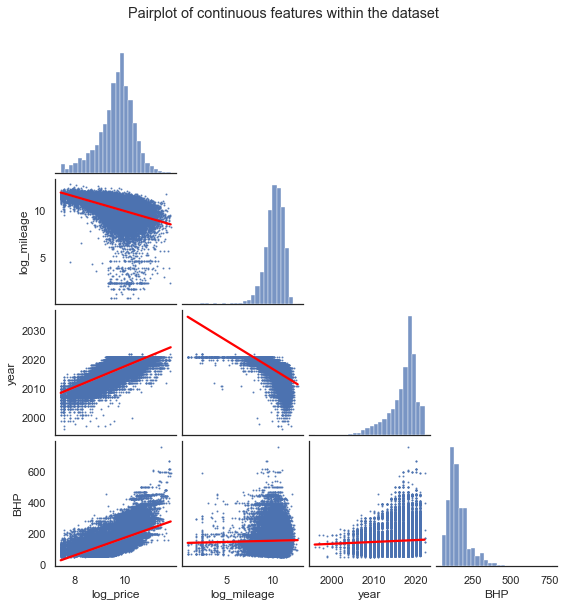

In [152]:
# Pairplot 
g = sns.pairplot(dfsample[['log_price','log_mileage','year','BHP']], kind="reg", corner=True, height=2,
                 plot_kws={'line_kws':{'color':'red'}, 'scatter_kws':{'s':1}},
                 grid_kws={'diag_sharey':False}, 
                 diag_kws={'bins':26});
g.fig.suptitle("Pairplot of continuous features within the dataset", y=1.05)
plt.show()

<b>Linear regression assumptions</b>

We make the following assumptions in linear regression:
* Y must have an approximately linear relationship with each independent Xi.
* Errors (residuals) ϵi and ϵj must be independent of one another for any i≠j.
* Errors (residuals) follow a normal distribution
* Errors (residuals) should have a roughly consistent pattern, regardless of the value of the Xi predictors. No discernible relationship between the X predictors and the residuals.
* Independent variables Xi and Xj must be independent of one another for any i≠j.

<br>
<br>
<b>Cross Validation</b>

Cross validation will be carried out using both train_test_split and the CV component within GridSearchCV. The is to ensure that any produced models generalise well and do not over-fit the data.
* For train_test_split I employ a 80/20 train/test split. I also shuffle the target variable and use a random_state to ensure that each model being tested uses the same input data.
* Using a cv parameter of 5 within the GridSearchCV tool for each model build ensures that the optimal model parameters are validated by a 5-fold cross validation before being recommended. This again works to prevent over-fitting of data.

<br>
<br>
<b>Standardisation</b>

Standard scaling is applied to the predictor variables, manipulating them to be of a comparable magnitude before input to modelling. For every predictor the mean value is subtracted from each value before dividing by the standard deviation. This allows for the influence of all predictors to be interpreted equally without influence from magnitude.

Note that Standard scaling is only applied for the linear regression based models. Scaling is not required for decision tree based models.

<br>
<br>
<b>Model Scoring</b>

In order to meet linear regression assumptions, some continuous variables within the modelling process have been log transformed to obtain a normal distribution. As such, the target variable for linear regression models is log-price rather than price. In order to attain comparability between linear regression models and decision tree models (which have no log-transform required), all model scoring attributes have been computed on the price variable rather than the log-price variable.  

* R2 score will be the primary metric by which models are evaluated. The R2 score represents the fraction of unexplained variance above the baseline which can be explained by the model.
* RMSE (or RMSD) represents the quadratic mean of the difference between predicted values and true values. It is the square root of the average of squared errors. The effect of each error on RMSE is proportional to the size of the squared error - thus larger errors have disproportionately large effect on RMSE! RMSE has the same units as the quantity being estimated. 
* MSE represents the average squared difference between predicted values and true values. It is the average of the squares of errors. MSE is described in square units of the quantity being estimated. 



In [153]:
# Modelling with dummies - SKLEARN LinearRegression() 

# Dummify necessary columns - I had initially intended to use MPG but it caused numerous issues and the
# results are better without it.
X = df[['log_price','log_mileage','year','BHP','drivertrain',
        'make','body','transmission','fuel','doors']]
y = X.pop('log_price')
to_dummy=['drivertrain','make','body','transmission','fuel','doors']
X= pd.get_dummies(X, columns = to_dummy, drop_first=True)
print('Dummified df shape',X.shape,'\n')

# Train test split
X_trainlr, X_testlr, y_trainlr, y_testlr = train_test_split(X,y,test_size=0.2, shuffle=y,random_state=42)

scaler = StandardScaler()
lr = LinearRegression()
pipelr = Pipeline(steps=[('scaler',scaler),('model',lr)])
#pipelr.get_params()

params = {'model__copy_X': [True],
          'model__fit_intercept': [True],
          'model__n_jobs': [2],
          'model__normalize': [False],
          'model__positive': [False]}

gridsearchlr = GridSearchCV(pipelr, params, cv=5, verbose=1)
gridsearchlr.fit(X_trainlr, y_trainlr)

# LinearRegression Model
lrtrain_preds = gridsearchlr.predict(X_trainlr)
lrtest_preds = gridsearchlr.predict(X_testlr)
printmd('**LINEAR REGRESSION**')
print('MSE train:',mean_squared_error(np.exp(y_trainlr), np.exp(lrtrain_preds)))
print('MSE test:',mean_squared_error(np.exp(y_testlr), np.exp(lrtest_preds)))
print('RMSE train:',np.sqrt((mean_squared_error(np.exp(y_trainlr), np.exp(lrtrain_preds)))))
print('RMSE test:',np.sqrt((mean_squared_error(np.exp(y_testlr), np.exp(lrtest_preds)))))
print('R2 train on log_price:',gridsearchlr.score(X_trainlr, y_trainlr))
print('R2 test on log_price:',gridsearchlr.score(X_testlr, y_testlr))
print('R2 train on price:',r2_score(np.exp(y_trainlr), np.exp(lrtrain_preds)))
print('R2 test on price:',r2_score(np.exp(y_testlr), np.exp(lrtest_preds)))
print('\n')
print(gridsearchlr.best_estimator_)

lrdict2 = {'Model': 'Linear Regression', 
          'MSE Train': mean_squared_error(np.exp(y_trainlr), np.exp(lrtrain_preds)),
          'MSE Test': mean_squared_error(np.exp(y_testlr), np.exp(lrtest_preds)),
          'RMSE Train': np.sqrt(mean_squared_error(np.exp(y_trainlr), np.exp(lrtrain_preds))),
          'RMSE Test': np.sqrt(mean_squared_error(np.exp(y_testlr), np.exp(lrtest_preds))),
          'R2 Train': r2_score(np.exp(y_trainlr), np.exp(lrtrain_preds)),
          'R2 Test': r2_score(np.exp(y_testlr), np.exp(lrtest_preds)),
          'Params': gridsearchlr.best_estimator_
         }

Dummified df shape (369730, 63) 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


**LINEAR REGRESSION**

MSE train: 16729072.860255754
MSE test: 16612486.259465331
RMSE train: 4090.118929842475
RMSE test: 4075.8417853819265
R2 train on log_price: 0.9166323722289952
R2 test on log_price: 0.9178004802732642
R2 train on price: 0.8782356907449659
R2 test on price: 0.8814802587297033


Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LinearRegression(n_jobs=2))])


I don't much like the R2 train score on price! will investigate further

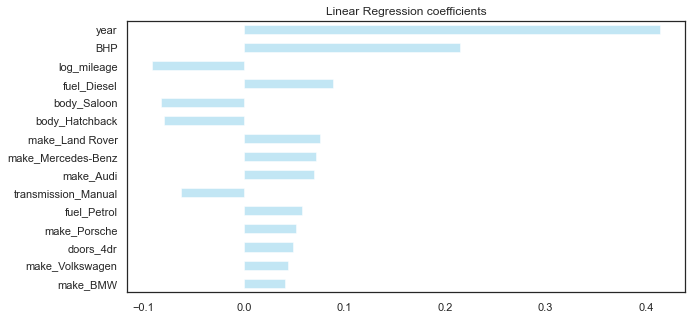

In [154]:
# Evaluate coefficients form linear regression 
lr_coefs = pd.DataFrame({'variable': X_trainlr.columns,
                            'coef': gridsearchlr.best_estimator_.named_steps['model'].coef_,
                            'abs_coef': np.abs(gridsearchlr.best_estimator_.named_steps['model'].coef_),
                            'std_dev': np.std(gridsearchlr.best_estimator_.named_steps['model'].coef_),
                            '1 std dev increase in variable causes X percent change on price':(np.exp(gridsearchlr.best_estimator_.named_steps['model'].coef_)-1)*100})
lr_coefs.sort_values('abs_coef', inplace=True, ascending=False)
#lr_coefs.loc[0,'1 std dev increase in variable causes X percent change on price'] = np.nan
lr_coefs['Percentage increase in price for every 20% increase X'] = np.nan
lr_coefs.loc[0,'Percentage increase in price for every 20% increase X'] = ((1.20**(lr_coefs.loc[0,'coef'])-1)*100)
# https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/#:~:text=Interpret%20the%20coefficient%20as%20the,variable%20increases%20by%20about%200.20%25.

fig, ax = plt.subplots(figsize=(10, 5))
lr_coefs.coef[:15].plot(kind='barh', color = 'skyblue', ax=ax, alpha=0.5, title='Linear Regression coefficients')
ax.set_yticklabels(lr_coefs.variable[:15].values)
plt.gca().invert_yaxis()
plt.show()

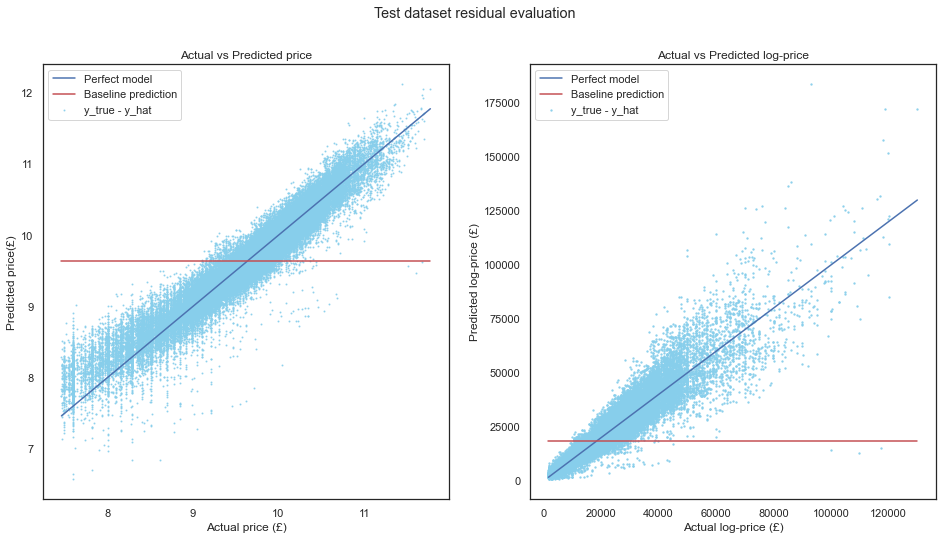

In [161]:
# Plot test predicted vs actual price in both log-space and non. NEEDS LEGEND FIXED
fig, ax = plt.subplots(ncols=2,figsize=(16,8))
ax[0].scatter(y_testlr, lrtest_preds, color='skyblue', alpha=0.8, s=1, label = 'y_true - y_hat')
ax[0].plot([y_testlr.min(), y_testlr.max()], [y_testlr.min(), y_testlr.max()], c='b',label = 'Perfect model')
ax[0].set_title('Actual vs Predicted price')
ax[0].set_xlabel("Actual price (£)")
ax[0].set_ylabel("Predicted price(£)")
ax[0].plot([y_testlr.min(), y_testlr.max()], [y_testlr.mean(), y_testlr.mean()], c='r', label = 'Baseline prediction')
ax[1].scatter(np.exp(y_testlr), np.exp(lrtest_preds), color='skyblue', alpha=0.8, s=2,  label = 'y_true - y_hat')
ax[1].plot([np.exp(y_testlr).min(), np.exp(y_testlr).max()], [np.exp(y_testlr).min(), np.exp(y_testlr).max()], 
           c='b', label = 'Perfect model')
ax[1].set_title('Actual vs Predicted log-price')
ax[1].set_xlabel("Actual log-price (£)")
ax[1].set_ylabel("Predicted log-price (£)")
ax[1].plot([np.exp(y_testlr).min(), np.exp(y_testlr).max()], [np.exp(y_testlr).mean(), np.exp(y_testlr).mean()], 
           c='r', label = 'Baseline prediction')
ax[0].legend()
ax[1].legend()
plt.suptitle('Test dataset residual evaluation')
for i in range(2):
    legend = ax[i].legend()
    frame = legend.get_frame()
    frame.set_facecolor('white')
plt.show()

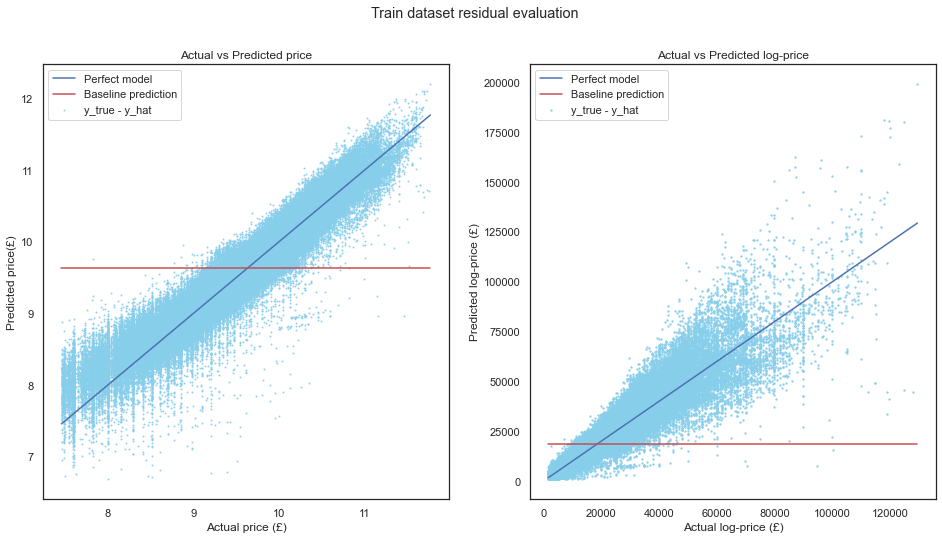

In [162]:
# Plot train predicted vs actual price in both log-space and non. NEEDS LEGEND FIXED

fig, ax = plt.subplots(ncols=2,figsize=(16,8))
ax[0].scatter(y_trainlr, lrtrain_preds, color='skyblue', alpha=0.8, s=1, label = 'y_true - y_hat')
ax[0].plot([y_trainlr.min(), y_trainlr.max()], [y_trainlr.min(), y_trainlr.max()], c='b',label = 'Perfect model')
ax[0].set_title('Actual vs Predicted price')
ax[0].set_xlabel("Actual price (£)")
ax[0].set_ylabel("Predicted price(£)")
ax[0].plot([y_trainlr.min(), y_trainlr.max()], [y_trainlr.mean(), y_trainlr.mean()], c='r', label = 'Baseline prediction')
ax[1].scatter(np.exp(y_trainlr), np.exp(lrtrain_preds), color='skyblue', alpha=0.8, s=2,  label = 'y_true - y_hat')
ax[1].plot([np.exp(y_trainlr).min(), np.exp(y_trainlr).max()], [np.exp(y_trainlr).min(), np.exp(y_trainlr).max()], 
           c='b', label = 'Perfect model')
ax[1].set_title('Actual vs Predicted log-price')
ax[1].set_xlabel("Actual log-price (£)")
ax[1].set_ylabel("Predicted log-price (£)")
ax[1].plot([np.exp(y_trainlr).min(), np.exp(y_trainlr).max()], [np.exp(y_trainlr).mean(), np.exp(y_trainlr).mean()], 
           c='r', label = 'Baseline prediction')
ax[0].legend()
ax[1].legend()
for i in range(2):
    legend = ax[i].legend()
    frame = legend.get_frame()
    frame.set_facecolor('white')
plt.suptitle('Train dataset residual evaluation')
plt.show()

In [157]:
# Plot coefficients and interpret to real life implications
lr_coefs.sort_values(by='abs_coef', ascending=False).head(10)

,variable,coef,abs_coef,std_dev,1 std dev increase in variable causes X percent change on price,Percentage increase in price for every 20% increase X
1,year,0.413523,0.413523,0.066209,51.213514,NaN
2,BHP,0.215040,0.215040,0.066209,23.991109,NaN
0,log_mileage,-0.090919,0.090919,0.066209,-8.690793,-1.643978
52,fuel_Diesel,0.088302,0.088302,0.066209,9.231765,NaN
49,body_Saloon,-0.082759,0.082759,0.066209,-7.942682,NaN
45,body_Hatchback,-0.079176,0.079176,0.066209,-7.612243,NaN
20,make_Land Rover,0.075445,0.075445,0.066209,7.836401,NaN
25,make_Mercedes-Benz,0.071659,0.071659,0.066209,7.428905,NaN
6,make_Audi,0.070172,0.070172,0.066209,7.269262,NaN
51,transmission_Manual,-0.062038,0.062038,0.066209,-6.015321,NaN


In [158]:
# Define top_lr_factors for later
top_lr_factors = lr_coefs.sort_values(by='abs_coef', ascending=False).head(10).variable.to_list()

### GradientBoostingRegressor()

*Why might I look to use a gradient boosting model?*

Where linear regression modelling started with a range of assumptions, gradient boosting methods only assume that the target variable is real-valued. This lack of assumptions can make it an appealing method for machine learning. 

Gradient boosting is a tree based ensemble technique in which the predictors are not made independently, but sequentially. The sequential method works in a way which allows subsequent predictors to learn from mistakes of their previous predictors.

<br>
<br>
<b>Gradient boosting explained</b>

* Gradient boosting starts with a base prediction by adopting the average value for the target variable before generating sequential predictors which aim to minimise the residuals between the base prediction and the actual values. 
* Each sequential predictor is scaled by a 'learning factor' before being added to the ensemble. This is usually some small fraction like 0.1 which forces the gradient boosting ensemble model to iteratively take small steps towards a better model with minimised residuals. 
* Taking many small steps in the right direction results in better predictions with a testing dataset. i.e. lower variance. 
* The model is considered optimised when adding new scaled predictors to the ensemble fails to reduce the residuals.



In [163]:
# Modelling with dummies - SKLEARN GradientBoostingRegressor()) 

# Dummify necessary columns 
X = df[['price','log_mileage','year','BHP','drivertrain',
        'make','body','transmission','fuel','doors']]
y = X.pop('price')
to_dummy=['drivertrain','make','body','transmission','fuel','doors']
X= pd.get_dummies(X, columns = to_dummy, drop_first=True)
print('Dummified df shape',X.shape,'\n')

# Train test split
X_traingb, X_testgb, y_traingb, y_testgb = train_test_split(X,y,test_size=0.2, shuffle=y, random_state =2)

scaler = StandardScaler()
model = GradientBoostingRegressor()
#pipegb = Pipeline(steps=[('scaler',scaler),('model',model)])
pipegb = Pipeline(steps=[('model',model)])
pipegb.get_params()

# params = {'model__n_estimators':[50, 100, 200],
#           'model__max_depth':[3,5],
#           'model__learning_rate':[0.05, 0.1],
#           'model__random_state':[1],
#           'model__validation_fraction':[0.1],
#           'model__n_iter_no_change':[20]}

# criterion{‘friedman_mse’, ‘squared_error’, ‘mse’, ‘mae’}

params = {'model__n_estimators':[200],
          'model__max_depth':[5],
          'model__learning_rate':[0.1],
          'model__random_state':[1],
          'model__validation_fraction':[0.1],
          'model__n_iter_no_change':[20]}

gridsearchgb = GridSearchCV(pipegb, params, cv=5, verbose=1)
gridsearchgb.fit(X_traingb, y_traingb)

# SKLEARN Model
gbtrain_preds = gridsearchgb.predict(X_traingb)
gbtest_preds = gridsearchgb.predict(X_testgb)
printmd('**GRADIENT BOOSTING REGRESSOR**')
print('MSE train:',mean_squared_error(y_traingb, gbtrain_preds))
print('MSE test:',mean_squared_error(y_testgb, gbtest_preds))
print('R2 train:',gridsearchgb.score(X_traingb, y_traingb))
print('R2 test:',gridsearchgb.score(X_testgb, y_testgb))
print('\n')
print(gridsearchgb.best_estimator_)

gbdict2 = {'Model': 'Gradient Boosting Regressor', 
          'MSE Train': mean_squared_error(y_traingb, gbtrain_preds),
          'MSE Test': mean_squared_error(y_testgb, gbtest_preds), 
          'R2 Train': gridsearchgb.score(X_traingb, y_traingb),
          'R2 Test': gridsearchgb.score(X_testgb, y_testgb),
          'Params': gridsearchgb.best_estimator_
         }

Dummified df shape (369730, 63) 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


**GRADIENT BOOSTING REGRESSOR**

MSE train: 6220079.23752757
MSE test: 6343789.371232913
R2 train: 0.9549072682744557
R2 test: 0.9540184637085746


Pipeline(steps=[('model',
                 GradientBoostingRegressor(max_depth=5, n_estimators=200,
                                           n_iter_no_change=20,
                                           random_state=1))])


In [164]:
printmd('**GRADIENT BOOSTING REGRESSOR**')
print('MSE train:',mean_squared_error(y_traingb, gbtrain_preds))
print('MSE test:',mean_squared_error(y_testgb, gbtest_preds))
print('RMSE train:',np.sqrt(mean_squared_error(y_traingb, gbtrain_preds)))
print('RMSE test:',np.sqrt(mean_squared_error(y_testgb, gbtest_preds)))
print('R2 train:',gridsearchgb.score(X_traingb, y_traingb))
print('R2 test:',gridsearchgb.score(X_testgb, y_testgb))

**GRADIENT BOOSTING REGRESSOR**

MSE train: 6220079.23752757
MSE test: 6343789.371232913
RMSE train: 2494.0086682943925
RMSE test: 2518.6880257850344
R2 train: 0.9549072682744557
R2 test: 0.9540184637085746


In [ ]:
pipegb.get_params()

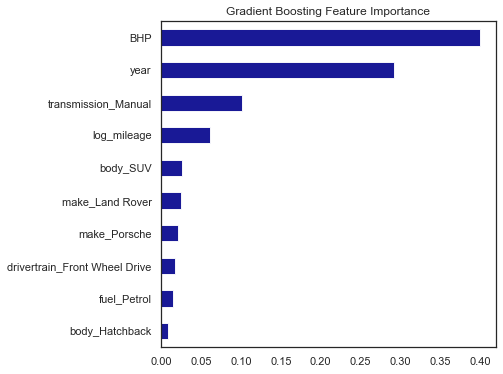

In [165]:
# Feature importance plot for gradient boosting 

# FROM SKLEARN
# feature_importances_
# The impurity-based feature importances.
# The higher, the more important the feature. The importance of a feature is computed as the 
# (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance.
# Warning: impurity-based feature importances can be misleading for high cardinality features (many unique values)



gb_coefs = pd.DataFrame({'variable': X_traingb.columns,
                            'Feature Importance': gridsearchgb.best_estimator_.named_steps["model"].feature_importances_})

plot = gb_coefs.sort_values(by='Feature Importance', ascending=False).head(30)

fig, ax = plt.subplots(figsize=(6, 6))
plot['Feature Importance'][:10].plot(kind='barh', color = 'darkblue', ax=ax, alpha=0.9 )
ax.set_yticklabels(plot.variable[:10].values)
ax.set_title('Gradient Boosting Feature Importance', fontsize=12)
plt.gca().invert_yaxis()
plt.savefig('featimp.pdf',bbox_inches='tight')
plt.show()

The plot above describes feature importance from Sklearn

Decision tree methods can give us feature importances to illuminate what's happening under the hood. The higher the number the more important the predictor was for deciding splits at nodes. Technically, the importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. In this case, the criterion is friedman_mse. 

That means a feature is more important...

- if it is used in many different nodes,
- if the difference in the measures of Gini or entropy are before and after the split is high

Feature importances are normalized in the sense of summing up to one.

In [166]:
# Compare top coefficients from LogisticRegression() against top feature importances from GradientBoostingRegressor()
top_gb_factors = gb_coefs.sort_values(by='Feature Importance', ascending=False).head(10).variable.to_list()

topfeaturedf = pd.DataFrame({'Top Linear Regression coefficients':top_lr_factors,'Top Gradient Boosting Feature Importances':top_gb_factors})
topfeaturedf

,Top Linear Regression coefficients,Top Gradient Boosting Feature Importances
0,year,BHP
1,BHP,year
2,log_mileage,transmission_Manual
3,fuel_Diesel,log_mileage
4,body_Saloon,body_SUV
5,body_Hatchback,make_Land Rover
6,make_Land Rover,make_Porsche
7,make_Mercedes-Benz,drivertrain_Front Wheel Drive
8,make_Audi,fuel_Petrol
9,transmission_Manual,body_Hatchback


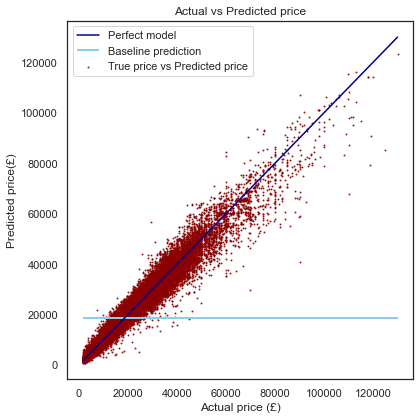

In [167]:
# Plot test actual vs predicted price 
fig, ax = plt.subplots(figsize=(6,6))
ax.plot([y_testgb.min(), y_testgb.max()], [y_testgb.min(), y_testgb.max()], c='darkblue',label = 'Perfect model')
ax.set_title('Actual vs Predicted price',fontsize=12)
ax.set_xlabel("Actual price (£)", fontsize=12)
ax.set_ylabel("Predicted price(£)", fontsize=12)
plt.hlines(y=y_testgb.mean(), xmin=y_testgb.min(), xmax=y_testgb.max(), linewidth=2, color='skyblue', label = 'Baseline prediction')
ax.scatter(y_testgb, gbtest_preds, color='darkred', alpha=0.8, s=1, label = 'True price vs Predicted price')
plt.tight_layout()
plt.legend()
legend = plt.legend()
frame = legend.get_frame()
frame.set_facecolor('white')
plt.savefig('actpred.pdf',bbox_inches='tight')
plt.show()

In [168]:
# Evaluate the biggest residuals!
resid = np.abs(y_testgb - gbtest_preds)
resid.sort_values(ascending=False)

sorted_resid = resid.sort_values(ascending=False).reset_index()
investigate1 = sorted_resid.iloc[0,0]
investigate2 = sorted_resid.iloc[1,0]
investigate3 = sorted_resid.iloc[2,0]

In [169]:
# Print structured report of larges residual cars

count=0
for residual in [investigate1,investigate2,investigate3]:
    count+=1
    printmd(f'**Bad prediction {count}**')
    print('Predicted price (£) \t',round(gridsearchgb.predict(X_testgb.loc[residual,:].array.reshape(1, -1))[0],2))
    print('Actual price (£)\t',refdf.loc[residual,'price'])
    print(refdf.loc[residual,'name':'county'])
    print(refdf.loc[residual,'link'])
    print('-'*65)

**Bad prediction 1**

Predicted price (£) 	 40744.95
Actual price (£)	 89995.0
name                                         mercedes-benz v class
name_subtitle    2.2 V250d AMG Line G-Tronic+ LWB EU6 (s/s) 5dr...
year                                                          2018
price                                                      89995.0
body                                                           MPV
mileage                                                    45000.0
BHP                                                     187.376726
doors                                                          5dr
transmission                                             Automatic
make                                                 Mercedes-Benz
fuel                                                        Diesel
mpg                                                        OVER_40
drivertrain                                       Rear Wheel Drive
engine                                                         2.2
owner

**Bad prediction 2**

Predicted price (£) 	 67776.51
Actual price (£)	 109995.0
name                                        land rover range rover
name_subtitle    2.0 P400e 12.4kWh Autobiography Auto 4WD (s/s)...
year                                                          2018
price                                                     109995.0
body                                                           SUV
mileage                                                    33900.0
BHP                                                     398.422091
doors                                                          5dr
transmission                                             Automatic
make                                                    Land Rover
fuel                                         Petrol Plug-in Hybrid
mpg                                                        OVER_60
drivertrain                                       Four Wheel Drive
engine                                                         2.0
owne

**Bad prediction 3**

Predicted price (£) 	 29747.56
Actual price (£)	 69995.0
name                                          bmw z4
name_subtitle    2.0 Z4 SDRIVE30I M SPORT 2d 255 BHP
year                                            2019
price                                        69995.0
body                                     Convertible
mileage                                      15550.0
BHP                                            254.0
doors                                            2dr
transmission                               Automatic
make                                             BMW
fuel                                          Petrol
mpg                                          OVER_30
drivertrain                         Rear Wheel Drive
engine                                           2.0
owners                                           1.0
ULEZ                                            ULEZ
county                                West Yorkshire
Name: 325280, dtype: object
https://www.au

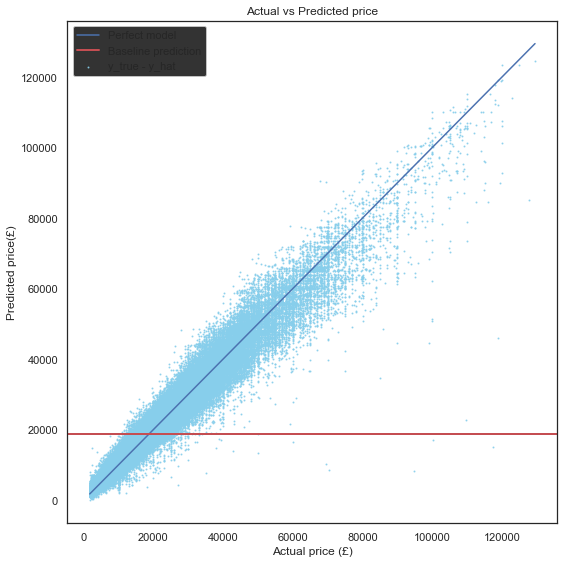

In [170]:
# Plot train actual vs predicted price 
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(y_traingb, gbtrain_preds, color='skyblue', alpha=0.8, s=1, label = 'y_true - y_hat')
ax.plot([y_traingb.min(), y_traingb.max()], [y_traingb.min(), y_traingb.max()], c='b',label = 'Perfect model')
ax.set_title('Actual vs Predicted price')
ax.set_xlabel("Actual price (£)")
ax.set_ylabel("Predicted price(£)")
plt.axhline(y=y_traingb.mean(), linewidth = 2, c='r',label = 'Baseline prediction')
legend = plt.legend()
frame = legend.get_frame()
frame.set_facecolor('white')
plt.tight_layout()
plt.legend()
plt.show()

Nice residual plots all round. Much better than the Linear regression ones 

In [171]:
# Use permutation importance from ELI5 package to obtain a weight to assign to each predictor
perm = PermutationImportance(gridsearchgb).fit(X_testgb, y_testgb)

In [172]:
# Feature importance from PermutationImportance package

# https://stats.stackexchange.com/questions/555949/how-to-interpret-the-feature-importances-for-eli5-show-weights-for-regressio
# For a high level overview of how the produced model works, we look at the weights from PermutationImportance
# I show the top 63 - That's them all. The eli5.show_weights function outputs a HTML table
eli5.show_weights(perm, feature_names = X_testgb.columns.values, top= 63)

Weight,Feature
0.4590 ± 0.0032,BHP
0.3572 ± 0.0031,year
0.0982 ± 0.0029,log_mileage
0.0327 ± 0.0014,make_Land Rover
0.0289 ± 0.0011,make_Porsche
0.0288 ± 0.0005,body_SUV
0.0281 ± 0.0004,transmission_Manual
0.0139 ± 0.0002,make_Mercedes-Benz
0.0132 ± 0.0004,fuel_Petrol
0.0127 ± 0.0004,drivertrain_Front Wheel Drive


In [173]:
# Zip together top coefficients for best LR model and best GB model using FI&PI
top_gb_factors_pi = pd.DataFrame((zip(X_testgb.columns.tolist(), perm.feature_importances_)), columns= ['variable','fi']).sort_values(by='fi', ascending=False).head(10).variable.to_list()
top_gb_factors = gb_coefs.sort_values(by='Feature Importance', ascending=False).head(10).variable.to_list()


featurecomp = pd.DataFrame({'rank':range(1,11),'LinearRegression top coefficients':top_lr_factors,'GradientBoostingRegression top features':top_gb_factors, 'GradientBoostingRegression top features from permutation importance':top_gb_factors_pi})
featurecomp.set_index('rank', drop=True, inplace=True)
featurecomp

,LinearRegression top coefficients,GradientBoostingRegression top features,GradientBoostingRegression top features from permutation importance
rank,,,
1,year,BHP,BHP
2,BHP,year,year
3,log_mileage,transmission_Manual,log_mileage
4,fuel_Diesel,log_mileage,make_Land Rover
5,body_Saloon,body_SUV,make_Porsche
6,body_Hatchback,make_Land Rover,body_SUV
7,make_Land Rover,make_Porsche,transmission_Manual
8,make_Mercedes-Benz,drivertrain_Front Wheel Drive,make_Mercedes-Benz
9,make_Audi,fuel_Petrol,fuel_Petrol


Linear regression coefficients and Gradient boosting feature importance have 6 common predictors in their top 10.

- year, BHP, body_Hatchback, make_Land_Rover, transmission_Manual and log_mileage 

Linear regression coefficients and Gradient boosting feature importance from permutation importance have 6 common predictors in their top 10.

- year, BHP, make_Mercedez-Benz, make_Land_Rover, transmission_Manual and log_mileage 


Gradient boosting feature importance and Gradient boosting feature importance from permutation importance have 8 common predictors in their top 10.

- year, BHP, body_SUV, make_Porsche, make_Land_Rover, transmission_Manual, fuel_petrol and log_mileage 


In [174]:
# Have a quick look at the feature importance and standard deviation from permutation importance 
df_fi = pd.DataFrame(dict(feature_names=X_testgb.columns.tolist(),
                          feat_imp=perm.feature_importances_, 
                          std=perm.feature_importances_std_,
                          ))
df_fi = df_fi.round(4)
df_fi.sort_values('feat_imp', ascending=False)

,feature_names,feat_imp,std
2,BHP,0.4590,0.0016
1,year,0.3572,0.0015
0,log_mileage,0.0982,0.0015
20,make_Land Rover,0.0327,0.0007
29,make_Porsche,0.0289,0.0005
...,...,...,...
14,make_Honda,0.0000,0.0000
16,make_Isuzu,0.0000,0.0000
24,make_Mazda,0.0000,0.0000
33,make_Saab,0.0000,0.0000


In [175]:
# Look at feature importances for a individual car. This is the granular breakdown of why it costs what it costs.

# For a look at how a single car has been processed by the model, I can use the eli5.show_prediction utility.
# It takes the model as input, and a sample row, in this case I use row 5 from X_test and return the top 10 features
show_prediction(gridsearchgb.best_estimator_.named_steps["model"], X_testgb.iloc[32, :], top =13, show_feature_values=True)

In [176]:
# Define functions for ELI5 car analysis 

def make_groupby_col(feature):
    """ADD DESCRIPTION IN HERE
    This function is used to help make an informative table in the car_summary function output
    """
    if 'BHP' in feature:
        return 'BHP'
    if 'BIAS' in feature:
        return 'BIAS'
    if 'year' in feature:
        return 'year'
#     if 'log_mileage' in feature:
#         return 'log_mileage'
    if 'transmission' in feature:
        return 'transmission'
    if 'body' in feature:
        return 'body'
    if 'drivertrain' in feature:
        return 'drivertrain'
    if 'mpg' in feature:
        return 'mpg'
    if 'make' in feature:
        return 'make'
    if 'doors' in feature:
        return 'doors'
    if 'fuel' in feature:
        return 'fuel'
    if 'mileage' in feature:
        return 'mileage'
    
def generate_summary(model, car_details, verbose=False):
    """ADD DESCRIPTION IN HERE
    The key point is that I can use eli5.explain_prediction_df to obtain a dataframe of weights
    and contributions for each row.
    """
    spiel = str(refdf.loc[pd.DataFrame(car_details).columns[0],'orig_name']+' '+refdf.loc[pd.DataFrame(car_details).columns[0],'name_subtitle'])
    printmd(f'**Car Summary:  {spiel}**')
    if verbose==True:
        # Print out details of the original car
        print('Original car')
        print(df.loc[pd.DataFrame(car_details).columns[0],:])
        print('\n')
    # Print out the predicted car price
    print('Predicted price \t\t True price')
    print('£', round(gridsearchgb.best_estimator_.named_steps["model"].predict(pd.DataFrame(car_details).T)[0],2), \
          '\t\t\t £',df.loc[pd.DataFrame(car_details).columns[0],:][1],'\n')
    print(refdf.loc[pd.DataFrame(car_details).columns[0],'link'])

    eli5df = eli5.explain_prediction_df(estimator=model, doc=car_details)    
    eli5df['absweight']=eli5df.weight.apply(lambda x: np.abs(x))
    eli5df['Predictor']=eli5df.feature.apply(lambda x: make_groupby_col(x))
    eli5df = eli5df.groupby(by='Predictor').sum().sort_values(by='absweight', ascending=False)
    eli5df['price']=eli5df.weight.cumsum()
    eli5df['attribute']=0
    for att in ['transmission','body','mileage','BHP','make','year','drivertrain','doors','fuel']:
        eli5df.loc[att,'attribute']=df.loc[pd.DataFrame(car_details).columns[0],att]
    eli5df.columns =['Price Contribution (£)','value','absweight','Cumulative Car Price (£)','Attribute']
    return eli5df[['Attribute','Price Contribution (£)','Cumulative Car Price (£)']]

def make_fake_car(year = 2018,
                  mileage = 40000,
                  BHP = 120,
                  body = 'Hatchback', 
                  transmission = 'Mmanual', 
                  make = 'Ford', 
                  drivetrain = 'Front Wheel Drive',
                  drs = '5dr', 
                  fuel = 'Petrol'):
    sample = pd.DataFrame(X_testgb.iloc[20, :]).T
    makes=[]
    bodys=[]
    drivertrains=[]
    fuels=[]
    doors=[]
    transmissions=[]
    for x in sample.columns:
        if 'make' in x:
            makes.append(x)
        if 'body' in x:
            bodys.append(x)
        if 'drivertrain' in x:
            drivertrains.append(x)
        if 'fuel' in x:
            fuels.append(x)
        if 'door' in x:
            doors.append(x)
        if 'transmission' in x:
            transmissions.append(x)

    dummy_cols = [makes + bodys + drivertrains + fuels + doors + transmissions + ['log_mileage','year','BHP']]
    for x in dummy_cols:
        sample.loc[:,x]=0

    sample['year'] = year
    sample['BHP'] = BHP
    sample['log_mileage'] = np.log(mileage)
    sample[f'body_{body}'] = 1
    sample[f'transmission_{transmission}'] = 1
    sample[f'make_{make}'] = 1
    sample[f'drivertrain_{drivetrain}'] = 1
    sample[f'fuel_{fuel}'] = 1
    sample[f'doors_{drs}'] = 1
    return sample.iloc[0,:]

def make_and_predict_describe_fake_car(year = 2018,
                              mileage = 40000,
                              BHP = 120,
                              body = 'Hatchback', 
                              transmission = 'Manual', 
                              make = 'Ford', 
                              drivetrain = 'Front Wheel Drive',
                              drs = '5dr', 
                              fuel = 'Petrol',
                              model = gridsearchgb.best_estimator_.named_steps["model"]):
    sample = pd.DataFrame(X_testgb.iloc[20, :]).T
    makes=[]
    bodys=[]
    drivertrains=[]
    fuels=[]
    doors=[]
    transmissions=[]
    for x in sample.columns:
        if 'make' in x:
            makes.append(x)
        if 'body' in x:
            bodys.append(x)
        if 'drivertrain' in x:
            drivertrains.append(x)
        if 'fuel' in x:
            fuels.append(x)
        if 'door' in x:
            doors.append(x)
        if 'transmission' in x:
            transmissions.append(x)

    dummy_cols = [makes + bodys + drivertrains + fuels + doors + transmissions + ['log_mileage','year','BHP']]
    for x in dummy_cols:
        sample.loc[:,x]=0

    sample['year'] = year
    sample['BHP'] = BHP
    sample['log_mileage'] = np.log(mileage)
    sample[f'body_{body}'] = 1
    if transmission == 'Manual':
        sample[f'transmission_Manual'] = 1
    else:
        sample[f'transmission_Manual'] = 0
    sample[f'make_{make}'] = 1
    sample[f'drivertrain_{drivetrain}'] = 1
    sample[f'fuel_{fuel}'] = 1
    sample[f'doors_{drs}'] = 1

    printmd(f'**Car Summary for synthetic {make}**')
    print('£', round(gridsearchgb.best_estimator_.named_steps["model"].predict(sample.iloc[0,:].array.reshape(1, -1))[0],2))
    eli5df = eli5.explain_prediction_df(estimator=model, doc=sample.iloc[0,:])    
    eli5df['absweight']=eli5df.weight.apply(lambda x: np.abs(x))
    eli5df['Predictor']=eli5df.feature.apply(lambda x: make_groupby_col(x))
    eli5df = eli5df.groupby(by='Predictor').sum().sort_values(by='absweight', ascending=False)
    eli5df['price']=eli5df.weight.cumsum()
    eli5df['attribute'] = 0
    eli5df.loc['BHP','attribute'] = BHP
    eli5df.loc['year','attribute'] = year
    eli5df.loc['mileage','attribute'] = mileage
    eli5df.loc['transmission','attribute'] = transmission
    eli5df.loc['make','attribute'] = make
    eli5df.loc['drivertrain','attribute'] = drivetrain
    eli5df.loc['doors','attribute'] = drs
    eli5df.loc['fuel','attribute'] = fuel  
    eli5df.loc['body','attribute'] = body 
    eli5df.columns=['Price contribution (£)','Attribute Into Model','Absolute Price Contribution','Cumulative Car Price (£)','Attribute']        
    return eli5df[['Attribute','Price contribution (£)','Cumulative Car Price (£)']        ]

def make_and_predict_fake_car(year = 2018,
                              mileage = 40000,
                              BHP = 120,
                              body = 'Hatchback', 
                              transmission = 'Manual', 
                              make = 'Ford', 
                              drivetrain = 'Front Wheel Drive',
                              drs = '5dr', 
                              fuel = 'Petrol',
                              model = gridsearchgb.best_estimator_.named_steps["model"]):
    sample = pd.DataFrame(X_testgb.iloc[20, :]).T
    makes=[]
    bodys=[]
    drivertrains=[]
    fuels=[]
    doors=[]
    transmissions=[]
    for x in sample.columns:
        if 'make' in x:
            makes.append(x)
        if 'body' in x:
            bodys.append(x)
        if 'drivertrain' in x:
            drivertrains.append(x)
        if 'fuel' in x:
            fuels.append(x)
        if 'door' in x:
            doors.append(x)
        if 'transmission' in x:
            transmissions.append(x)

    dummy_cols = [makes + bodys + drivertrains + fuels + doors + transmissions + ['log_mileage','year','BHP']]
    for x in dummy_cols:
        sample.loc[:,x]=0

    sample['year'] = year
    sample['BHP'] = BHP
    sample['log_mileage'] = np.log(mileage)
    sample[f'body_{body}'] = 1
    sample[f'transmission_{transmission}'] = 1
    sample[f'make_{make}'] = 1
    sample[f'drivertrain_{drivetrain}'] = 1
    sample[f'fuel_{fuel}'] = 1
    sample[f'doors_{drs}'] = 1
   
    return (round(gridsearchgb.best_estimator_.named_steps["model"].predict(sample.iloc[0,:].array.reshape(1, -1))[0],2))
    

In [177]:
X_testgb.columns

Index(['log_mileage', 'year', 'BHP', 'drivertrain_Front Wheel Drive',
       'drivertrain_Rear Wheel Drive', 'make_Alfa Romeo', 'make_Audi',
       'make_BMW', 'make_Chevrolet', 'make_Citroen', 'make_DS Automobiles',
       'make_Dacia', 'make_Fiat', 'make_Ford', 'make_Honda', 'make_Hyundai',
       'make_Isuzu', 'make_Jaguar', 'make_Jeep', 'make_KIA', 'make_Land Rover',
       'make_Lexus', 'make_MG', 'make_MINI', 'make_Mazda',
       'make_Mercedes-Benz', 'make_Mitsubishi', 'make_Nissan', 'make_Peugeot',
       'make_Porsche', 'make_Renault', 'make_SEAT', 'make_SKODA', 'make_Saab',
       'make_Smart', 'make_Ssangyong', 'make_Subaru', 'make_Suzuki',
       'make_Tesla', 'make_Toyota', 'make_Vauxhall', 'make_Volkswagen',
       'make_Volvo', 'body_Coupe', 'body_Estate', 'body_Hatchback', 'body_MPV',
       'body_Pickup', 'body_SUV', 'body_Saloon', 'body_Van',
       'transmission_Manual', 'fuel_Diesel', 'fuel_Diesel Hybrid',
       'fuel_Diesel Plug-in Hybrid', 'fuel_Electric', 'fuel_

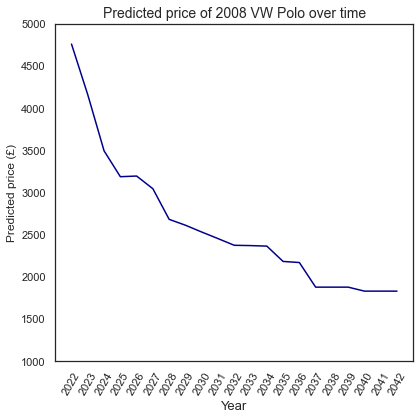

In [178]:
# Plot my polo depreciate over time 

polo_price = []
yr=2008
mil=40000
all_miles = []
for i in range(0,21):
    polo_price.append(make_and_predict_fake_car(year = yr, 
                                                mileage = mil,
                                                BHP = 64,
                                                body = 'Hatchback', 
                                                transmission = 'Manual', 
                                                make = 'Volkswagen', 
                                                drivetrain = 'Front Wheel Drive',
                                                drs = '5dr', 
                                                fuel = 'Petrol'))
    all_miles.append(mil)
    yr-=1
    mil+=7000
    
polodf = pd.DataFrame({'Year': range(2022,2043), 'Price (£)':polo_price , 'Mileage': all_miles})

fig, ax = plt.subplots(figsize=(6,6))
# ax.plot([y_testgb.min(), y_testgb.max()], [y_testgb.min(), y_testgb.max()], c='darkblue',label = 'Perfect model')
ax.set_title('Predicted price of 2008 VW Polo over time',fontsize=14)
ax.set_xlabel("Year", fontsize=13)
ax.set_ylabel("Predicted price (£)", fontsize=12)
ax.plot(polodf.Year, polodf['Price (£)'], c='darkblue',label = '2008 VW Polo Value')
plt.xticks(polodf.Year, rotation=60)
ax.set_ylim(1000,5000)
plt.tight_layout()
# plt.legend()
# legend = plt.legend()
# frame = legend.get_frame()
# frame.set_facecolor('white')
plt.show()

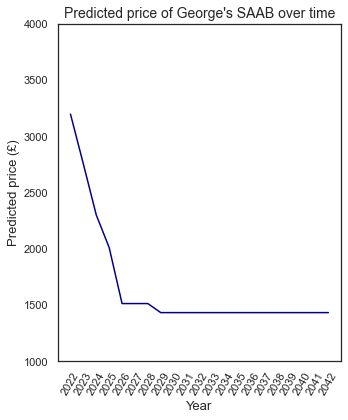

In [179]:
# Plot George's SAAB depreciate over time 

polo_price = []
yr=2010
mil=117000
all_miles = []
for i in range(0,21):
    polo_price.append(make_and_predict_fake_car(year = yr, 
                                                mileage = mil,
                                                BHP = 156,
                                                body = 'Saloon', 
                                                transmission = 'Manual', 
                                                make = 'Saab', 
                                                drivetrain = 'Front Wheel Drive',
                                                drs = '5dr', 
                                                fuel = 'Diesel'))
    all_miles.append(mil)
    yr-=1
    mil+=7000
    
polodf = pd.DataFrame({'Year': range(2022,2043), 'Price (£)':polo_price , 'Mileage': all_miles})

fig, ax = plt.subplots(figsize=(5,6))
# ax.plot([y_testgb.min(), y_testgb.max()], [y_testgb.min(), y_testgb.max()], c='darkblue',label = 'Perfect model')
ax.set_title("Predicted price of George's SAAB over time",fontsize=14)
ax.set_xlabel("Year", fontsize=13)
ax.set_ylabel("Predicted price (£)", fontsize=13)
ax.plot(polodf.Year, polodf['Price (£)'], c='darkblue',label = '2010 SAAB Value')
plt.xticks(polodf.Year, rotation=60)
ax.set_ylim(1000,4000)
plt.tight_layout()
# plt.legend()
# legend = plt.legend()
# frame = legend.get_frame()
# frame.set_facecolor('white')
plt.show()

In [180]:
# Look at some car analysis for a random car
generate_summary(gridsearchgb.best_estimator_.named_steps["model"],X_testgb.iloc[10, :], verbose=False)

**Car Summary:  Mazda MX-5 SPORT NAV 2.0 2dr**

Predicted price 		 True price
£ 18209.18 			 £ 18495.0 

https://www.autotrader.co.uk/car-details/202108276715617


,Attribute,Price Contribution (£),Cumulative Car Price (£)
Predictor,,,
BIAS,0,18626.905344,18626.905344
transmission,Manual,-2167.030173,16459.875171
mileage,16491.0,1798.090866,18257.966036
drivertrain,Rear Wheel Drive,1185.419831,19443.385867
body,Convertible,271.036063,19714.421930
make,Mazda,-366.367150,19348.054780
year,2016,-790.667101,18557.387679
fuel,Petrol,-553.809037,18003.578643
BHP,157.790927,208.559611,18212.138254


In [181]:
# Synthetic Dacia 2018, 30000miles, 120BHP

make_and_predict_describe_fake_car(year = 2018,
                      mileage = 30000,
                      BHP = 120,
                      body = 'Hatchback', 
                      transmission = 'Manual', 
                      make = 'Dacia', 
                      drivetrain = 'Front Wheel Drive',
                      drs = '5dr', 
                      fuel = 'Petrol')



**Car Summary for synthetic Dacia**

£ 11439.84
(63,)
Index(['log_mileage', 'year', 'BHP', 'drivertrain_Front Wheel Drive',
       'drivertrain_Rear Wheel Drive', 'make_Alfa Romeo', 'make_Audi',
       'make_BMW', 'make_Chevrolet', 'make_Citroen', 'make_DS Automobiles',
       'make_Dacia', 'make_Fiat', 'make_Ford', 'make_Honda', 'make_Hyundai',
       'make_Isuzu', 'make_Jaguar', 'make_Jeep', 'make_KIA', 'make_Land Rover',
       'make_Lexus', 'make_MG', 'make_MINI', 'make_Mazda',
       'make_Mercedes-Benz', 'make_Mitsubishi', 'make_Nissan', 'make_Peugeot',
       'make_Porsche', 'make_Renault', 'make_SEAT', 'make_SKODA', 'make_Saab',
       'make_Smart', 'make_Ssangyong', 'make_Subaru', 'make_Suzuki',
       'make_Tesla', 'make_Toyota', 'make_Vauxhall', 'make_Volkswagen',
       'make_Volvo', 'body_Coupe', 'body_Estate', 'body_Hatchback', 'body_MPV',
       'body_Pickup', 'body_SUV', 'body_Saloon', 'body_Van',
       'transmission_Manual', 'fuel_Diesel', 'fuel_Diesel Hybrid',
       'fuel_Diesel Plug-in Hybrid', 'fuel_

,Attribute,Price contribution (£),Cumulative Car Price (£)
Predictor,,,
BIAS,0,18626.905344,18626.905344
BHP,120,-2897.928756,15728.976587
make,Dacia,-2255.076875,13473.899712
transmission,Manual,-2210.424939,11263.474774
year,2018,1797.435411,13060.910185
body,Hatchback,-988.920346,12071.989839
fuel,Petrol,-530.532354,11541.457485
drivertrain,Front Wheel Drive,-268.080828,11273.376657
mileage,30000,158.471587,11431.848244


In [182]:
# Synthetic Volvo 2018, 30000miles, 120BHP

make_and_predict_describe_fake_car(year = 2018,
                      mileage = 40000,
                      BHP = 120,
                      body = 'Hatchback', 
                      transmission = 'Manual', 
                      make = 'Volvo', 
                      drivetrain = 'Front Wheel Drive',
                      drs = '5dr', 
                      fuel = 'Petrol')

**Car Summary for synthetic Volvo**

£ 14290.71
(63,)
Index(['log_mileage', 'year', 'BHP', 'drivertrain_Front Wheel Drive',
       'drivertrain_Rear Wheel Drive', 'make_Alfa Romeo', 'make_Audi',
       'make_BMW', 'make_Chevrolet', 'make_Citroen', 'make_DS Automobiles',
       'make_Dacia', 'make_Fiat', 'make_Ford', 'make_Honda', 'make_Hyundai',
       'make_Isuzu', 'make_Jaguar', 'make_Jeep', 'make_KIA', 'make_Land Rover',
       'make_Lexus', 'make_MG', 'make_MINI', 'make_Mazda',
       'make_Mercedes-Benz', 'make_Mitsubishi', 'make_Nissan', 'make_Peugeot',
       'make_Porsche', 'make_Renault', 'make_SEAT', 'make_SKODA', 'make_Saab',
       'make_Smart', 'make_Ssangyong', 'make_Subaru', 'make_Suzuki',
       'make_Tesla', 'make_Toyota', 'make_Vauxhall', 'make_Volkswagen',
       'make_Volvo', 'body_Coupe', 'body_Estate', 'body_Hatchback', 'body_MPV',
       'body_Pickup', 'body_SUV', 'body_Saloon', 'body_Van',
       'transmission_Manual', 'fuel_Diesel', 'fuel_Diesel Hybrid',
       'fuel_Diesel Plug-in Hybrid', 'fuel_

,Attribute,Price contribution (£),Cumulative Car Price (£)
Predictor,,,
BIAS,0,18626.905344,18626.905344
transmission,Manual,-2206.118262,16420.787081
year,2018,1996.212972,18417.000053
make,Volvo,260.956801,18677.956855
body,Hatchback,-1597.995313,17079.961542
BHP,120,-1465.832988,15614.128553
fuel,Petrol,-558.380476,15055.748077
mileage,40000,-521.026163,14534.721915
drivertrain,Front Wheel Drive,-266.895083,14267.826831


In [183]:
refdf.groupby(by='make')['price'].mean().reset_index().sort_values('price').head(60)

,make,price
15,Daewoo,1055.900000
43,Perodua,1896.300000
47,Proton,2427.000000
16,Daihatsu,3025.586207
10,Chevrolet,3634.941935
52,Saab,3951.914384
9,Cadillac,4635.000000
17,Dodge,4736.214286
1,Aixam,4995.000000
49,Rover,5408.500000


In [184]:
X_traingb.columns

Index(['log_mileage', 'year', 'BHP', 'drivertrain_Front Wheel Drive',
       'drivertrain_Rear Wheel Drive', 'make_Alfa Romeo', 'make_Audi',
       'make_BMW', 'make_Chevrolet', 'make_Citroen', 'make_DS Automobiles',
       'make_Dacia', 'make_Fiat', 'make_Ford', 'make_Honda', 'make_Hyundai',
       'make_Isuzu', 'make_Jaguar', 'make_Jeep', 'make_KIA', 'make_Land Rover',
       'make_Lexus', 'make_MG', 'make_MINI', 'make_Mazda',
       'make_Mercedes-Benz', 'make_Mitsubishi', 'make_Nissan', 'make_Peugeot',
       'make_Porsche', 'make_Renault', 'make_SEAT', 'make_SKODA', 'make_Saab',
       'make_Smart', 'make_Ssangyong', 'make_Subaru', 'make_Suzuki',
       'make_Tesla', 'make_Toyota', 'make_Vauxhall', 'make_Volkswagen',
       'make_Volvo', 'body_Coupe', 'body_Estate', 'body_Hatchback', 'body_MPV',
       'body_Pickup', 'body_SUV', 'body_Saloon', 'body_Van',
       'transmission_Manual', 'fuel_Diesel', 'fuel_Diesel Hybrid',
       'fuel_Diesel Plug-in Hybrid', 'fuel_Electric', 'fuel_

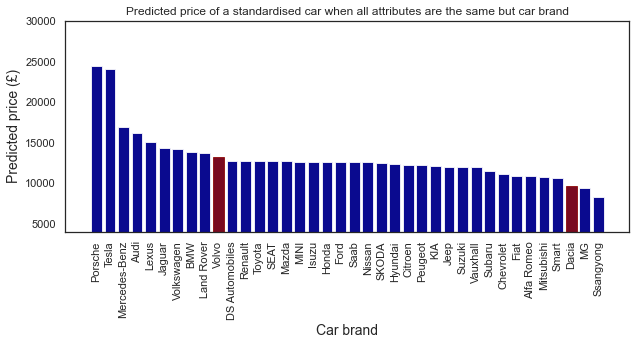

In [185]:
# Make dummy cars to test hypothesis and dummy car df 
options = ['Mercedes-Benz','Volvo','Volkswagen','SKODA','SEAT','Dacia','Audi','Ford','Citroen','Renault','Fiat','Nissan','Saab','Vauxhall','Hyundai', 'Land Rover']
options = ['Alfa Romeo','Audi','BMW','Chevrolet','Citroen','DS Automobiles','Dacia','Fiat',
           'Ford','Honda','Hyundai','Isuzu','Jaguar','Jeep','KIA','Land Rover','Lexus','MG',
           'MINI','Mazda','Mercedes-Benz','Mitsubishi','Nissan','Peugeot','Porsche','Renault',
           'SEAT','SKODA','Saab','Smart','Ssangyong','Subaru','Suzuki','Tesla','Toyota',
           'Vauxhall','Volkswagen','Volvo']  
equiv_cars = []
for make in options:
    equiv_cars.append(make_and_predict_fake_car(year = 2018, mileage = 30000, BHP = 100, make = make))

equiv_cars_df = pd.DataFrame({'Make':options,'Price (£)':equiv_cars})
equiv_cars_df = equiv_cars_df.sort_values(by='Price (£)', ascending=False)

fig, ax = plt.subplots(figsize=(9,4))
ax.bar(equiv_cars_df.Make, equiv_cars_df['Price (£)'], label = 'Predicted price for equivalent car', 
        width = 0.8, color = 'darkblue', alpha=0.8)
barlist = ax.bar(equiv_cars_df.Make, equiv_cars_df['Price (£)'], label = 'Predicted price for equivalent car', 
        width = 0.8, color = 'darkblue', alpha=0.8)
barlist[9].set_color('darkred')
barlist[-3].set_color('darkred')
ax.set_title('Predicted price of a standardised car when all attributes are the same but car brand',fontsize=12)
ax.set_xlabel("Car brand", fontsize=14)
ax.set_ylabel("Predicted price (£)", fontsize=14)
ax.set_ylim(4000,30000)
plt.tight_layout()
plt.xticks(equiv_cars_df.Make, rotation=90)
# plt.legend()
# legend = plt.legend()
# frame = legend.get_frame()
# frame.set_facecolor('white')
plt.savefig('fakecarbrand.pdf',bbox_inches='tight')
plt.show()

In [186]:
options

['Alfa Romeo',
 'Audi',
 'BMW',
 'Chevrolet',
 'Citroen',
 'DS Automobiles',
 'Dacia',
 'Fiat',
 'Ford',
 'Honda',
 'Hyundai',
 'Isuzu',
 'Jaguar',
 'Jeep',
 'KIA',
 'Land Rover',
 'Lexus',
 'MG',
 'MINI',
 'Mazda',
 'Mercedes-Benz',
 'Mitsubishi',
 'Nissan',
 'Peugeot',
 'Porsche',
 'Renault',
 'SEAT',
 'SKODA',
 'Saab',
 'Smart',
 'Ssangyong',
 'Subaru',
 'Suzuki',
 'Tesla',
 'Toyota',
 'Vauxhall',
 'Volkswagen',
 'Volvo']

In [187]:
# Look at some car analysis for a random car
generate_summary(gridsearchgb.best_estimator_.named_steps["model"],X_traingb.loc[123824, :], verbose=False)

**Car Summary:  Volkswagen Tiguan 2.0 TDi BMT 150 4Motion SE Nav 5dr TOWBAR - LANE ASSIST - DRIVING MODES**

Predicted price 		 True price
£ 20566.01 			 £ 19495.0 

https://www.autotrader.co.uk/car-details/202201141338255


,Attribute,Price Contribution (£),Cumulative Car Price (£)
Predictor,,,
BIAS,0,18626.905344,18626.905344
make,Volkswagen,917.066936,19543.972280
transmission,Manual,-2186.835844,17357.136436
body,SUV,1499.246432,18856.382868
drivertrain,Four Wheel Drive,1268.330185,20124.713053
year,2016,-722.492211,19402.220842
mileage,35718.0,398.435124,19800.655966
fuel,Diesel,379.182952,20179.838918
BHP,147.928994,374.773477,20554.612395


In [188]:
X_testgb.head(60)

,log_mileage,year,BHP,drivertrain_Front Wheel Drive,drivertrain_Rear Wheel Drive,make_Alfa Romeo,make_Audi,make_BMW,make_Chevrolet,make_Citroen,...,fuel_Diesel Hybrid,fuel_Diesel Plug-in Hybrid,fuel_Electric,fuel_Petrol,fuel_Petrol Hybrid,fuel_Petrol Plug-in Hybrid,doors_3dr,doors_4dr,doors_5dr,doors_6dr
211207,9.539212,2018,113.412229,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
271637,10.491274,2018,120.315582,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
161597,11.178850,2017,136.000000,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
35924,11.669929,2011,147.928994,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
369042,9.442721,2021,129.191321,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
280641,9.467151,2019,129.191321,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
310324,9.623972,2019,100.591716,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
228007,10.745960,2018,187.376726,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
51727,11.018629,2012,111.000000,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
75252,11.097410,2014,113.000000,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


**Car Summary:  MINI Countryman 1.5 Cooper 5dr**

Predicted price 		 True price
£ 19317.08 			 £ 17999.0 

https://www.autotrader.co.uk/car-details/202201271841369


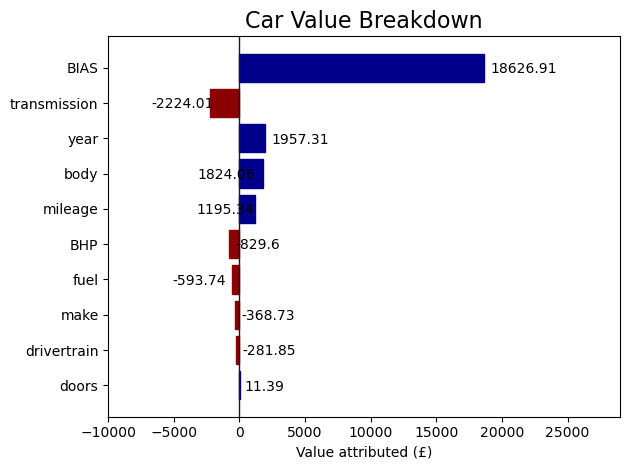

,Attribute,Price Contribution (£),Cumulative Car Price (£)
Predictor,,,
BIAS,0,18626.905344,18626.905344
transmission,Manual,-2224.012905,16402.892439
year,2018,1957.307218,18360.199658
body,SUV,1824.056246,20184.255904
mileage,17654.0,1195.343945,21010.871819
BHP,136.0,-829.601714,20181.270105
fuel,Petrol,-593.740488,19587.529618
make,MINI,-368.728029,19815.527874
drivertrain,Front Wheel Drive,-281.845240,19305.684377


In [190]:

def red_or_blue(x):
    if x>0:
        return 'darkblue'
    else:
        return 'darkred'

breakdowndf = generate_summary(gridsearchgb.best_estimator_.named_steps["model"],X_testgb.iloc[40, :], verbose=False)
breakdowndf #= breakdowndf.sort_values(by=)
breakdowndf['sort']=breakdowndf['Price Contribution (£)'].apply(lambda x: np.abs(x))
breakdowndf = breakdowndf.sort_values(by='sort', ascending=False)
breakdowndf['colour'] = breakdowndf['Price Contribution (£)'].apply(lambda x: red_or_blue(x))

# edgecolor : color or list of color, optional
#     The colors of the bar edges.

# linewidth : float or array-like, optional
#     Width of the bar edge(s). If 0, don't draw edges.


plt.rcdefaults()
fig, ax = plt.subplots()
ax.barh(breakdowndf.index, breakdowndf['Price Contribution (£)'], color='darkblue', edgecolor= 'white', linewidth=2000)
barlist = ax.barh(breakdowndf.index, breakdowndf['Price Contribution (£)'], color='darkblue')
for i in range(0,10):
    barlist[i].set_color(breakdowndf.colour[i])
ax.set_xlim(-10000,29000)
#ax.set_yticklabels(breakdowndf.index)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Value attributed (£)')
ax.set_title('Car Value Breakdown', fontsize=16)
ax.axvline(x=0,linewidth=1, color='k')
shift=[500,-4500,500,-5000,-4500,500,-4500,500,500,400]
for i, v in enumerate(round(breakdowndf['Price Contribution (£)'],2)):
    ax.text(v + shift[i], i + 00.15, str(v), color='black')
plt.tight_layout()
plt.show()

breakdowndf[['Attribute','Price Contribution (£)','Cumulative Car Price (£)']]

In [192]:
# George's SAAB

make_and_predict_describe_fake_car(year = 2010,
                      mileage = 117000,
                      BHP = 137,
                      body = 'Saloon', 
                      transmission = 'Automatic', 
                      make = 'Saab', 
                      drivetrain = 'Front Wheel Drive',
                      drs = '5dr', 
                      fuel = 'Diesel')

**Car Summary for synthetic Saab**

£ 4029.83
(63,)
Index(['log_mileage', 'year', 'BHP', 'drivertrain_Front Wheel Drive',
       'drivertrain_Rear Wheel Drive', 'make_Alfa Romeo', 'make_Audi',
       'make_BMW', 'make_Chevrolet', 'make_Citroen', 'make_DS Automobiles',
       'make_Dacia', 'make_Fiat', 'make_Ford', 'make_Honda', 'make_Hyundai',
       'make_Isuzu', 'make_Jaguar', 'make_Jeep', 'make_KIA', 'make_Land Rover',
       'make_Lexus', 'make_MG', 'make_MINI', 'make_Mazda',
       'make_Mercedes-Benz', 'make_Mitsubishi', 'make_Nissan', 'make_Peugeot',
       'make_Porsche', 'make_Renault', 'make_SEAT', 'make_SKODA', 'make_Saab',
       'make_Smart', 'make_Ssangyong', 'make_Subaru', 'make_Suzuki',
       'make_Tesla', 'make_Toyota', 'make_Vauxhall', 'make_Volkswagen',
       'make_Volvo', 'body_Coupe', 'body_Estate', 'body_Hatchback', 'body_MPV',
       'body_Pickup', 'body_SUV', 'body_Saloon', 'body_Van',
       'transmission_Manual', 'fuel_Diesel', 'fuel_Diesel Hybrid',
       'fuel_Diesel Plug-in Hybrid', 'fuel_E

,Attribute,Price contribution (£),Cumulative Car Price (£)
Predictor,,,
BIAS,0,18626.905344,18626.905344
year,2010,-9134.564272,9492.341071
mileage,117000,-3375.831002,6116.510069
BHP,137,-2710.354561,3406.155508
transmission,Automatic,2234.466771,5640.622280
body,Saloon,-898.616745,4742.005534
make,Saab,-444.575759,4297.429775
drivertrain,Front Wheel Drive,-279.708830,4017.720945
doors,5dr,15.897431,4033.618376



## Used cars - All data - varying predictors

### LinearRegression()

In [193]:
# Modelling on data without dummies - SKLEARN LinearRegression() 

# Prep test/train for modelling without dummies - SKLEARN LinearRegression() 

# Read clean used cars data, drop columns not useful in modelling and drop under populated makes
abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/00_all_cars.csv'
df = pd.read_csv(abspath)
print('all',df.shape)

# Save copy for later if needed
refdf = df.copy()

# Select used cars only
df = df[df['used']==1]
print('used',df.shape)

# Drop outliers in log-price
mask = np.abs((df.log_price - df.log_price.mean()) / df.log_price.std()) > 3
df= df[~mask]
print('used_without_price_outliers',df.shape)

# Drop outliers in log-mileage
mask = np.abs((df.log_mileage - df.log_mileage.mean()) / df.log_mileage.std()) > 3
df= df[~mask]
print('used_without_mileage_outliers',df.shape)

# Drop outliers in BHP
mask = np.abs((df.BHP - df.BHP.mean()) / df.BHP.std()) > 6
df= df[~mask]
print('used_without_BHP_outliers',df.shape)

# Drop columns not needed
df = df.drop(labels=['name','name_subtitle','link','seller1',
                     'href0','dealer_city','dealer_area','year_reg',
                     'orig_name','e_engine_kWh','dealer_lat',
                     'dealer_lon','ULEZ','id','used'], axis=1)
print('used_without_extra_columns', df.shape)

# Drop under represented car makes
carnums = df.groupby(by='make')['price'].count().sort_values().reset_index()
carmakes = carnums[carnums.price>200].make.to_list()
df = df[df.make.isin(carmakes)].copy()
print('used_without_little_makes', df.shape)

# Dummify necessary columns 
X = df[['log_price','log_mileage','year','BHP']]
y = X.pop('log_price')
print('Df shape',X.shape,'\n')

# Train test split
X_trainlr_cont, X_testlr_cont, y_trainlr_cont, y_testlr_cont = train_test_split(X,y,test_size=0.2, shuffle=y, random_state = 2)

scaler = StandardScaler()
lr = LinearRegression()
pipelr = Pipeline(steps=[('scaler',scaler),('model',lr)])
#pipelr.get_params()

params = {'model__copy_X': [True],
          'model__fit_intercept': [True],
          'model__n_jobs': [2],
          'model__normalize': [False],
          'model__positive': [False]}

gridsearchlr_cont = GridSearchCV(pipelr, params, cv=5, verbose=1)
gridsearchlr_cont.fit(X_trainlr_cont, y_trainlr_cont)

# LinearRegression Model
lrtrain_preds_cont = gridsearchlr_cont.predict(X_trainlr_cont)
lrtest_preds_cont = gridsearchlr_cont.predict(X_testlr_cont)
printmd('**LINEAR REGRESSION WITH CONTINUOUS VARIABLES ONLY**')
print('MSE train:',mean_squared_error(np.exp(y_trainlr_cont), np.exp(lrtrain_preds_cont)))
print('MSE test:',mean_squared_error(np.exp(y_testlr_cont), np.exp(lrtest_preds_cont)))
print('RMSE train:',np.sqrt((mean_squared_error(np.exp(y_trainlr_cont), np.exp(lrtrain_preds_cont)))))
print('RMSE test:',np.sqrt((mean_squared_error(np.exp(y_testlr_cont), np.exp(lrtest_preds_cont)))))
print('R2 train on log_price:',gridsearchlr_cont.score(X_trainlr_cont, y_trainlr_cont))
print('R2 test on log_price:',gridsearchlr_cont.score(X_testlr_cont, y_testlr_cont))
print('R2 train on price:',r2_score(np.exp(y_trainlr_cont), np.exp(lrtrain_preds_cont)))
print('R2 test on price:',r2_score(np.exp(y_testlr_cont), np.exp(lrtest_preds_cont)))
print('\n')
print(gridsearchlr_cont.best_estimator_)

lrdict_cont = {'Model': 'Linear Regression', 
          'MSE Train': mean_squared_error(np.exp(y_trainlr_cont), np.exp(lrtrain_preds_cont)),
          'MSE Test': mean_squared_error(np.exp(y_testlr_cont), np.exp(lrtest_preds_cont)),
          'RMSE Train': np.sqrt(mean_squared_error(np.exp(y_trainlr_cont), np.exp(lrtrain_preds_cont))),
          'RMSE Test': np.sqrt(mean_squared_error(np.exp(y_testlr_cont), np.exp(lrtest_preds_cont))),
          'R2 Train': r2_score(np.exp(y_trainlr_cont), np.exp(lrtrain_preds_cont)),
          'R2 Test': r2_score(np.exp(y_testlr_cont), np.exp(lrtest_preds_cont)),
          'Params': gridsearchlr_cont.best_estimator_
            }

all (400247, 36)
used (378597, 36)
used_without_price_outliers (374506, 36)
used_without_mileage_outliers (370688, 36)
used_without_BHP_outliers (370525, 36)
used_without_extra_columns (370525, 21)
used_without_little_makes (369730, 21)
Df shape (369730, 3) 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


**LINEAR REGRESSION WITH CONTINUOUS VARIABLES ONLY**

MSE train: 49737380.289431706
MSE test: 47928930.07195538
RMSE train: 7052.47334553146
RMSE test: 6923.072300067029
R2 train on log_price: 0.827089552222265
R2 test on log_price: 0.828138371764029
R2 train on price: 0.6394267242463281
R2 test on price: 0.652597886129928


Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LinearRegression(n_jobs=2))])


In [194]:
# Modelling with dummies - SKLEARN LinearRegression() 

# Read clean used cars data, drop columns not useful in modelling and drop under populated makes

abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/00_all_cars.csv'
df = pd.read_csv(abspath)
print('all',df.shape)

refdf = df.copy()

df = df[df['used']==1]
print('used',df.shape)

# Drop outliers in log-price
mask = np.abs((df.log_price - df.log_price.mean()) / df.log_price.std()) > 3
df= df[~mask]
print('used_without_price_outliers',df.shape)

# Drop outliers in log-mileage
mask = np.abs((df.log_mileage - df.log_mileage.mean()) / df.log_mileage.std()) > 3
df= df[~mask]
print('used_without_mileage_outliers',df.shape)

# Drop outliers in BHP
mask = np.abs((df.BHP - df.BHP.mean()) / df.BHP.std()) > 6
df= df[~mask]
print('used_without_BHP_outliers',df.shape)

# Drop not needed columns
df = df.drop(labels=['name','name_subtitle','link','seller1',
                     'href0','dealer_city','dealer_area','year_reg',
                     'orig_name','e_engine_kWh','dealer_lat',
                     'dealer_lon','ULEZ','id','used'], axis=1)
print('used_without_extra_columns', df.shape)

# Drop under represented car makes
carnums = df.groupby(by='make')['price'].count().sort_values().reset_index()
carmakes = carnums[carnums.price>200].make.to_list()
df = df[df.make.isin(carmakes)].copy()

print('used_without_little_makes', df.shape)

# Dummify necessary columns 
X = df[['log_price','log_mileage','year','BHP','drivertrain',
        'make','body','transmission','fuel','doors']]
y = X.pop('log_price')
to_dummy=['drivertrain','make','body','transmission','fuel','doors']
X= pd.get_dummies(X, columns = to_dummy, drop_first=True)
print('Dummified df shape',X.shape,'\n')

# Train test split
X_trainlr, X_testlr, y_trainlr, y_testlr = train_test_split(X,y,test_size=0.2, shuffle=y,random_state = 42)

scaler = StandardScaler()
lr = LinearRegression()
pipelr = Pipeline(steps=[('scaler',scaler),('model',lr)])
#pipelr.get_params()

params = {'model__copy_X': [True],
          'model__fit_intercept': [True],
          'model__n_jobs': [2],
          'model__normalize': [False],
          'model__positive': [False]}

gridsearchlr = GridSearchCV(pipelr, params, cv=5, verbose=1)
gridsearchlr.fit(X_trainlr, y_trainlr)

# LinearRegression Model
lrtrain_preds = gridsearchlr.predict(X_trainlr)
lrtest_preds = gridsearchlr.predict(X_testlr)
printmd('**LINEAR REGRESSION WITH CONTINUOUS VARIABLES AND DUMMIES**')
print('MSE train:',mean_squared_error(np.exp(y_trainlr), np.exp(lrtrain_preds)))
print('MSE test:',mean_squared_error(np.exp(y_testlr), np.exp(lrtest_preds)))
print('RMSE train:',np.sqrt((mean_squared_error(np.exp(y_trainlr), np.exp(lrtrain_preds)))))
print('RMSE test:',np.sqrt((mean_squared_error(np.exp(y_testlr), np.exp(lrtest_preds)))))
print('R2 train on log_price:',gridsearchlr.score(X_trainlr, y_trainlr))
print('R2 test on log_price:',gridsearchlr.score(X_testlr, y_testlr))
print('R2 train on price:',r2_score(np.exp(y_trainlr), np.exp(lrtrain_preds)))
print('R2 test on price:',r2_score(np.exp(y_testlr), np.exp(lrtest_preds)))
print('\n')
print(gridsearchlr.best_estimator_)

lrdict2 = {'Model': 'Linear Regression', 
          'MSE Train': mean_squared_error(np.exp(y_trainlr), np.exp(lrtrain_preds)),
          'MSE Test': mean_squared_error(np.exp(y_testlr), np.exp(lrtest_preds)),
          'RMSE Train': np.sqrt(mean_squared_error(np.exp(y_trainlr), np.exp(lrtrain_preds))),
          'RMSE Test': np.sqrt(mean_squared_error(np.exp(y_testlr), np.exp(lrtest_preds))),
          'R2 Train': r2_score(np.exp(y_trainlr), np.exp(lrtrain_preds)),
          'R2 Test': r2_score(np.exp(y_testlr), np.exp(lrtest_preds)),
          'Params': gridsearchlr.best_estimator_
         }

all (400247, 36)
used (378597, 36)
used_without_price_outliers (374506, 36)
used_without_mileage_outliers (370688, 36)
used_without_BHP_outliers (370525, 36)
used_without_extra_columns (370525, 21)
used_without_little_makes (369730, 21)
Dummified df shape (369730, 63) 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


**LINEAR REGRESSION WITH CONTINUOUS VARIABLES AND DUMMIES**

MSE train: 16729072.860255754
MSE test: 16612486.259465331
RMSE train: 4090.118929842475
RMSE test: 4075.8417853819265
R2 train on log_price: 0.9166323722289952
R2 test on log_price: 0.9178004802732642
R2 train on price: 0.8782356907449659
R2 test on price: 0.8814802587297033


Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LinearRegression(n_jobs=2))])


In [195]:
# Modelling on data with dummies and latlon - SKLEARN LinearRegression() 

# Prep test/train for modelling with latlon and dummies - SKLEARN LinearRegression() 

# Read clean used cars data, drop columns not useful in modelling and drop under populated makes
abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/00_all_cars.csv'
df = pd.read_csv(abspath)
print('all',df.shape)

# Save a copy of the data for later
refdf = df.copy()

# Select used cars only
df = df[df['used']==1]
print('used',df.shape)

# Drop outliers in log-price
mask = np.abs((df.log_price - df.log_price.mean()) / df.log_price.std()) > 3
df= df[~mask]
print('used_without_price_outliers',df.shape)

# Drop outliers in log-mileage
mask = np.abs((df.log_mileage - df.log_mileage.mean()) / df.log_mileage.std()) > 3
df= df[~mask]
print('used_without_mileage_outliers',df.shape)

# Drop outliers in BHP
mask = np.abs((df.BHP - df.BHP.mean()) / df.BHP.std()) > 6
df= df[~mask]
print('used_without_BHP_outliers',df.shape)

# Drop not needed columns
df = df.drop(labels=['name','name_subtitle','link','seller1',
                     'href0','dealer_city','dealer_area','year_reg',
                     'orig_name','e_engine_kWh',
                     'ULEZ','id','used'], axis=1)
print('used_without_extra_columns', df.shape)

# Drop under represented car makes
carnums = df.groupby(by='make')['price'].count().sort_values().reset_index()
carmakes = carnums[carnums.price>200].make.to_list()
df = df[df.make.isin(carmakes)].copy()
print('used_without_little_makes', df.shape)

# Drop cars without lat/lon
df.dropna(subset = ['dealer_lat'], inplace=True)
print('used_without_nan_latlon', df.shape)

# Dummify necessary columns 
X = df[['log_price','log_mileage','year','BHP','drivertrain',
        'make','body','transmission','fuel','doors','dealer_lat','dealer_lon']]
y = X.pop('log_price')
to_dummy=['drivertrain','make','body','transmission','fuel','doors']
X= pd.get_dummies(X, columns = to_dummy, drop_first=True)
print('Dummified df shape',X.shape,'\n')

# Train test split
X_trainlr_ll, X_testlr_ll, y_trainlr_ll, y_testlr_ll = train_test_split(X,y,test_size=0.2, shuffle=y,random_state = 42)

scaler = StandardScaler()
lr = LinearRegression()
pipelr = Pipeline(steps=[('scaler',scaler),('model',lr)])
#pipelr.get_params()

params = {'model__copy_X': [True],
          'model__fit_intercept': [True],
          'model__n_jobs': [2],
          'model__normalize': [False],
          'model__positive': [False]}

gridsearchlr_ll = GridSearchCV(pipelr, params, cv=5, verbose=1)
gridsearchlr_ll.fit(X_trainlr_ll, y_trainlr_ll)

# LinearRegression Model
lrtrain_preds_ll = gridsearchlr_ll.predict(X_trainlr_ll)
lrtest_preds_ll = gridsearchlr_ll.predict(X_testlr_ll)
printmd('**LINEAR REGRESSION WITH CONTINUOUS VARIABLES, DUMMIES AND LAT-LON**')
print('MSE train:',mean_squared_error(np.exp(y_trainlr_ll), np.exp(lrtrain_preds_ll)))
print('MSE test:',mean_squared_error(np.exp(y_testlr_ll), np.exp(lrtest_preds_ll)))
print('RMSE train:',np.sqrt((mean_squared_error(np.exp(y_trainlr_ll), np.exp(lrtrain_preds_ll)))))
print('RMSE test:',np.sqrt((mean_squared_error(np.exp(y_testlr_ll), np.exp(lrtest_preds_ll)))))
print('R2 train on log_price:',gridsearchlr_ll.score(X_trainlr_ll, y_trainlr_ll))
print('R2 test on log_price:',gridsearchlr_ll.score(X_testlr_ll, y_testlr_ll))
print('R2 train on price:',r2_score(np.exp(y_trainlr_ll), np.exp(lrtrain_preds_ll)))
print('R2 test on price:',r2_score(np.exp(y_testlr_ll), np.exp(lrtest_preds_ll)))
print('\n')
print(gridsearchlr_ll.best_estimator_)

lrdict_ll = {'Model': 'Linear Regression', 
          'MSE Train': mean_squared_error(np.exp(y_trainlr_ll), np.exp(lrtrain_preds_ll)),
          'MSE Test': mean_squared_error(np.exp(y_testlr_ll), np.exp(lrtest_preds_ll)),
          'RMSE Train': np.sqrt(mean_squared_error(np.exp(y_trainlr_ll), np.exp(lrtrain_preds_ll))),
          'RMSE Test': np.sqrt(mean_squared_error(np.exp(y_testlr_ll), np.exp(lrtest_preds_ll))),
          'R2 Train': r2_score(np.exp(y_trainlr_ll), np.exp(lrtrain_preds_ll)),
          'R2 Test': r2_score(np.exp(y_testlr_ll), np.exp(lrtest_preds_ll)),
          'Params': gridsearchlr_ll.best_estimator_
            }

all (400247, 36)
used (378597, 36)
used_without_price_outliers (374506, 36)
used_without_mileage_outliers (370688, 36)
used_without_BHP_outliers (370525, 36)
used_without_extra_columns (370525, 23)
used_without_little_makes (369730, 23)
used_without_nan_latlon (368426, 23)
Dummified df shape (368426, 65) 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


**LINEAR REGRESSION WITH CONTINUOUS VARIABLES, DUMMIES AND LAT-LON**

MSE train: 16760726.05220149
MSE test: 16304978.964758322
RMSE train: 4093.986572059255
RMSE test: 4037.9424172167587
R2 train on log_price: 0.9167852428985771
R2 test on log_price: 0.9181232143939729
R2 train on price: 0.8781844586044435
R2 test on price: 0.8831482276063114


Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LinearRegression(n_jobs=2))])


In [196]:
# # Prep test/train for modelling with area and dummies - SKLEARN LinearRegression() - Needs work if I get time 

# # Read clean used cars data, drop columns not useful in modelling and drop under populated areas

# abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/00_all_cars.csv'
# df = pd.read_csv(abspath)
# print('all',df.shape)

# refdf = df.copy()

# df = df[df['used']==1]
# print('used',df.shape)

# mask = np.abs((df.log_price - df.log_price.mean()) / df.log_price.std()) > 3
# df= df[~mask]
# print('used_without_outliers',df.shape)

# df = df.drop(labels=['name','name_subtitle','link','seller1',
#                      'href0','dealer_city','year_reg',
#                      'orig_name','e_engine_kWh','dealer_lat',
#                      'dealer_lon','ULEZ','id','used'], axis=1)

# print('used_without_extra_columns', df.shape)

# df.dropna(subset = ['dealer_area'], inplace=True)
# print('used_without_nan_dealer_area', df.shape)

# tempdf = df.groupby(by='dealer_area')[['price']].count().sort_values(by='price')
# tempdf = tempdf[tempdf.price>100].reset_index()
# templist = tempdf.dealer_area.to_list()

# areas = []
# for a in templist:
#     if '/' in a:
#         pass
# #        print(a)
#     if '#' in a:
#         pass
# #        print(a)
# #     elif a=='essex-':
# #         a='essex'
# #         areas.append(a)
#     else:
#         areas.append(a)

# df = df[df.dealer_area.isin(areas)].copy()
# print('used_without_dealer_area<100', df.shape)

# # Dummify necessary columns 
# X = df[['log_price','log_mileage','year','BHP','drivertrain',
#         'make','body','transmission','fuel','doors','dealer_area']]
# y = X.pop('log_price')
# to_dummy=['drivertrain','make','body','transmission','fuel','doors','dealer_area']
# X= pd.get_dummies(X, columns = to_dummy, drop_first=True)
# print('Dummified df shape',X.shape,'\n')

# # Train test split
# X_trainlr_a, X_testlr_a, y_trainlr_a, y_testlr_a = train_test_split(X,y,test_size=0.2, shuffle=y,random_state = 42)

# # Modelling on data with dummies and latlon - SKLEARN LinearRegression() 

# scaler = StandardScaler()
# lr = LinearRegression()
# pipelr = Pipeline(steps=[('scaler',scaler),('model',lr)])
# #pipelr.get_params()

# params = {'model__copy_X': [True],
#           'model__fit_intercept': [True],
#           'model__n_jobs': [2],
#           'model__normalize': [False],
#           'model__positive': [False]}

# gridsearchlr_a = GridSearchCV(pipelr, params, cv=5, verbose=1)
# gridsearchlr_a.fit(X_trainlr_a, y_trainlr_a)

# # LinearRegression Model
# lrtrain_preds_a = gridsearchlr_a.predict(X_trainlr_a)
# lrtest_preds_a = gridsearchlr_a.predict(X_testlr_a)
# printmd('**LINEAR REGRESSION WITH CONTINUOUS VARIABLES, DUMMIES AND AREA**')
# print('MSE train:',mean_squared_error(np.exp(y_trainlr_a), np.exp(lrtrain_preds_a)))
# print('MSE test:',mean_squared_error(np.exp(y_testlr_a), np.exp(lrtest_preds_a)))
# print('RMSE train:',np.sqrt((mean_squared_error(np.exp(y_trainlr_a), np.exp(lrtrain_preds_a)))))
# print('RMSE test:',np.sqrt((mean_squared_error(np.exp(y_testlr_a), np.exp(lrtest_preds_a)))))
# print('R2 train:',gridsearchlr_a.score(X_trainlr_a, y_trainlr_a))
# print('R2 test:',gridsearchlr_a.score(X_testlr_a, y_testlr_a))
# print('\n')
# print(gridsearchlr_a.best_estimator_)

# lrdict_a = {'Model': 'Linear Regression', 
#           'MSE Train': mean_squared_error(np.exp(y_trainlr_a), np.exp(lrtrain_preds_a)),
#           'MSE Test': mean_squared_error(np.exp(y_testlr_a), np.exp(lrtest_preds_a)),
#           'RMSE Train': np.sqrt(mean_squared_error(np.exp(y_trainlr_a), np.exp(lrtrain_preds_a))),
#           'RMSE Test': np.sqrt(mean_squared_error(np.exp(y_testlr_a), np.exp(lrtest_preds_a))),
#           'R2 Train': gridsearchlr_a.score(X_trainlr_a, y_trainlr_a),
#           'R2 Test': gridsearchlr_a.score(X_testlr_a, y_testlr_a),
#           'Params': gridsearchlr_a.best_estimator_
#             }

In [197]:
# # Modelling with bootsize and dummies - SKLEARN LinearRegression() - Not got round to this yet

# # Read clean used cars data, drop columns not useful in modelling and drop under populated makes

# abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/00_all_cars.csv'
# df = pd.read_csv(abspath)
# print('all',df.shape)

# refdf = df.copy()

# df = df[df['used']==1]
# print('used',df.shape)

# mask = np.abs((df.log_price - df.log_price.mean()) / df.log_price.std()) > 3
# df= df[~mask]
# print('used_without_outliers',df.shape)

# df = df.drop(labels=['name','name_subtitle','link','seller1',
#                      'href0','dealer_city','dealer_area','year_reg',
#                      'orig_name','e_engine_kWh','dealer_lat',
#                      'dealer_lon','ULEZ','id','used'], axis=1)

# print('used_without_extra_columns', df.shape)

# carnums = df.groupby(by='make')['price'].count().sort_values().reset_index()
# carmakes = carnums[carnums.price>200].make.to_list()
# df = df[df.make.isin(carmakes)].copy()

# print('used_without_little_makes', df.shape)

# # Dummify necessary columns 
# X = df[['log_price','log_mileage','year','BHP','drivertrain',
#         'make','body','transmission','fuel','doors']]
# y = X.pop('log_price')
# to_dummy=['drivertrain','make','body','transmission','fuel','doors']
# X= pd.get_dummies(X, columns = to_dummy, drop_first=True)
# print('Dummified df shape',X.shape,'\n')

# # Train test split
# X_trainlr, X_testlr, y_trainlr, y_testlr = train_test_split(X,y,test_size=0.2, shuffle=y,)

# # scaler = StandardScaler()
# # lr = LinearRegression()
# # pipelr = Pipeline(steps=[('scaler',scaler),('model',lr)])
# # #pipelr.get_params()

# # params = {'model__copy_X': [True],
# #           'model__fit_intercept': [True],
# #           'model__n_jobs': [2],
# #           'model__normalize': [False],
# #           'model__positive': [False]}

# # gridsearchlr = GridSearchCV(pipelr, params, cv=5, verbose=1)
# # gridsearchlr.fit(X_trainlr, y_trainlr)

# # # LinearRegression Model
# # lrtrain_preds = gridsearchlr.predict(X_trainlr)
# # lrtest_preds = gridsearchlr.predict(X_testlr)
# # printmd('**LINEAR REGRESSION WITH CONTINUOUS VARIABLES AND DUMMIES**')
# # print('MSE train:',mean_squared_error(y_trainlr, lrtrain_preds))
# # print('MSE test:',mean_squared_error(y_testlr, lrtest_preds))
# # print('R2 train:',gridsearchlr.score(X_trainlr, y_trainlr))
# # print('R2 test:',gridsearchlr.score(X_testlr, y_testlr))
# # print('\n')
# # print(gridsearchlr.best_estimator_)

# # lrdict2 = {'Model': 'Linear Regression', 
# #           'MSE Train': mean_squared_error(y_trainlr, lrtrain_preds),
# #           'MSE Test': mean_squared_error(y_testlr, lrtest_preds), 
# #           'R2 Train': gridsearchlr.score(X_trainlr, y_trainlr),
# #           'R2 Test': gridsearchlr.score(X_testlr, y_testlr),
# #           'Params': gridsearchlr.best_estimator_
# #          }

In [198]:
# Summary dataframe of results 
lrdict2['Input data'] = 'Continuous plus dummies'
lrdict_cont['Input data'] = 'Continuous only'
lrdict_ll['Input data'] = 'Continuous plus dummies plus lat/lon'
#lrdict_a['Input data'] = 'Continuous plus dummies plus county'
pd.DataFrame([lrdict_cont,lrdict2,lrdict_ll])

,Model,MSE Train,MSE Test,RMSE Train,RMSE Test,R2 Train,R2 Test,Params,Input data
0,Linear Regression,4.973738e+07,4.792893e+07,7052.473346,6923.072300,0.639427,0.652598,"(StandardScaler(), LinearRegression(n_jobs=2))",Continuous only
1,Linear Regression,1.672907e+07,1.661249e+07,4090.118930,4075.841785,0.878236,0.881480,"(StandardScaler(), LinearRegression(n_jobs=2))",Continuous plus dummies
2,Linear Regression,1.676073e+07,1.630498e+07,4093.986572,4037.942417,0.878184,0.883148,"(StandardScaler(), LinearRegression(n_jobs=2))",Continuous plus dummies plus lat/lon


*This is a bit disappointing! Adding latitude and longitude hasn't really helped much. Adding county info seems a little better, but still not earth shattering. If I had more time I'd try to better engineer these into counties but no time.*

### GradientBoostingRegression()

In [199]:
# Prep data, called df

# Read clean used cars data, drop columns not useful in modelling and drop under populated makes
cars_abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/02_cars_with_location_and_size.csv'

df = pd.read_csv(cars_abspath)
print('all',df.shape)

# Save copy for later if needed
refdf = df.copy()

# Select used cars only
df = df[df['used']==1]
print('used',df.shape)

# Drop outliers in log-price
mask = np.abs((df.log_price - df.log_price.mean()) / df.log_price.std()) > 3
df= df[~mask]
print('used_without_price_outliers',df.shape)

# Drop outliers in log-mileage
mask = np.abs((df.log_mileage - df.log_mileage.mean()) / df.log_mileage.std()) > 3
df= df[~mask]
print('used_without_mileage_outliers',df.shape)

# Drop outliers in BHP
mask = np.abs((df.BHP - df.BHP.mean()) / df.BHP.std()) > 6
df= df[~mask]
print('used_without_BHP_outliers',df.shape)

# Drop under represented car makes
carnums = df.groupby(by='make')['price'].count().sort_values().reset_index()
carmakes = carnums[carnums.price>200].make.to_list()
df = df[df.make.isin(carmakes)].copy()
print('used_without_little_makes', df.shape)


all (335826, 42)
used (319633, 42)
used_without_price_outliers (315126, 42)
used_without_mileage_outliers (311866, 42)
used_without_BHP_outliers (311741, 42)
used_without_little_makes (311348, 42)


In [200]:
# Modelling on data without dummies - SKLEARN GradientBoostingRegression() 

# Prep test/train for modelling without dummies - SKLEARN GradientBoostingRegression() 

# Dummify necessary columns 
X = df[['price','mileage','year','BHP']]
y = X.pop('price')
print('Df shape',X.shape,'\n')

X_traingb_cont, X_testgb_cont, y_traingb_cont, y_testgb_cont = train_test_split(X,y,test_size=0.2, shuffle=y, random_state=2)

scaler = StandardScaler()
model = GradientBoostingRegressor()
#pipegb = Pipeline(steps=[('scaler',scaler),('model',model)])
pipegb = Pipeline(steps=[('model',model)])
pipegb.get_params()

# params = {'model__n_estimators':[50, 100, 200],
#           'model__max_depth':[3,5],
#           'model__learning_rate':[0.05, 0.1],
#           'model__random_state':[1],
#           'model__validation_fraction':[0.1],
#           'model__n_iter_no_change':[20]}

# criterion{‘friedman_mse’, ‘squared_error’, ‘mse’, ‘mae’}

params = {'model__n_estimators':[200],
          'model__max_depth':[5],
          'model__learning_rate':[0.1],
          'model__random_state':[1],
          'model__validation_fraction':[0.1],
          'model__n_iter_no_change':[20]}

gridsearchgb_cont = GridSearchCV(pipegb, params, cv=5, verbose=1)
gridsearchgb_cont.fit(X_traingb_cont, y_traingb_cont)

# GradientBoostingRegressor() Model
gbtrain_preds_cont = gridsearchgb_cont.predict(X_traingb_cont)
gbtest_preds_cont = gridsearchgb_cont.predict(X_testgb_cont)
printmd('**GRADIENT BOOSTING REGRESSION WITH CONTINUOUS VARIABLES ONLY**')
print('MSE train:',mean_squared_error(y_traingb_cont, gbtrain_preds_cont))
print('MSE test:',mean_squared_error(y_testgb_cont, gbtest_preds_cont))
print('RMSE train:',np.sqrt((mean_squared_error(y_traingb_cont, gbtrain_preds_cont))))
print('RMSE test:',np.sqrt((mean_squared_error(y_testgb_cont, gbtest_preds_cont))))
print('R2 train on price:',gridsearchgb_cont.score(X_traingb_cont, y_traingb_cont))
print('R2 test on price:',gridsearchgb_cont.score(X_testgb_cont, y_testgb_cont))

print('\n')
print(gridsearchgb_cont.best_estimator_)

gbdict_cont = {'Model': 'GradientBoostingRegressor', 
          'MSE Train': mean_squared_error(y_traingb_cont, gbtrain_preds_cont),
          'MSE Test': mean_squared_error(y_testgb_cont, gbtest_preds_cont), 
          'RMSE Train': np.sqrt(mean_squared_error(y_traingb_cont, gbtrain_preds_cont)),
          'RMSE Test': np.sqrt(mean_squared_error(y_testgb_cont, gbtest_preds_cont)),
          'R2 Train': gridsearchgb_cont.score(X_traingb_cont, y_traingb_cont),
          'R2 Test': gridsearchgb_cont.score(X_testgb_cont, y_testgb_cont),
          'Params': gridsearchgb_cont.best_estimator_
         }

Df shape (311348, 3) 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


**GRADIENT BOOSTING REGRESSION WITH CONTINUOUS VARIABLES ONLY**

MSE train: 16096114.650473176
MSE test: 16937523.176356923
RMSE train: 4011.9963422806327
RMSE test: 4115.522224014459
R2 train on price: 0.8791541264417895
R2 test on price: 0.8738768108041699


Pipeline(steps=[('model',
                 GradientBoostingRegressor(max_depth=5, n_estimators=200,
                                           n_iter_no_change=20,
                                           random_state=1))])


In [201]:
# Modelling with dummies - SKLEARN LinearRegression() 

# # Read clean used cars data, drop columns not useful in modelling and drop under populated makes
# cars_abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/02_cars_with_location_and_size.csv'

# df = pd.read_csv(cars_abspath)
# print('all',df.shape)

# # Save copy for later if needed
# refdf = df.copy()

# # Select used cars only
# df = df[df['used']==1]
# print('used',df.shape)

# # Drop outliers in log-price
# mask = np.abs((df.log_price - df.log_price.mean()) / df.log_price.std()) > 3
# df= df[~mask]
# print('used_without_price_outliers',df.shape)

# # Drop outliers in log-mileage
# mask = np.abs((df.log_mileage - df.log_mileage.mean()) / df.log_mileage.std()) > 3
# df= df[~mask]
# print('used_without_mileage_outliers',df.shape)

# # Drop outliers in BHP
# mask = np.abs((df.BHP - df.BHP.mean()) / df.BHP.std()) > 6
# df= df[~mask]
# print('used_without_BHP_outliers',df.shape)

# # Drop under represented car makes
# carnums = df.groupby(by='make')['price'].count().sort_values().reset_index()
# carmakes = carnums[carnums.price>200].make.to_list()
# df = df[df.make.isin(carmakes)].copy()
# print('used_without_little_makes', df.shape)

# Dummify necessary columns 
X = df[['price','mileage','year','BHP','drivertrain',
        'make','body','transmission','fuel','doors']]
y = X.pop('price')
to_dummy=['drivertrain','make','body','transmission','fuel','doors']
X= pd.get_dummies(X, columns = to_dummy, drop_first=True)
print('Dummified df shape',X.shape,'\n')

# Train test split
X_traingb2, X_testgb2, y_traingb2, y_testgb2 = train_test_split(X,y,test_size=0.2, shuffle=y,random_state = 2)

scaler = StandardScaler()
model = GradientBoostingRegressor()
#pipegb = Pipeline(steps=[('scaler',scaler),('model',model)])
pipegb2 = Pipeline(steps=[('model',model)])
pipegb2.get_params()

# params = {'model__n_estimators':[50, 100, 200],
#           'model__max_depth':[3,5],
#           'model__learning_rate':[0.05, 0.1],
#           'model__random_state':[1],
#           'model__validation_fraction':[0.1],
#           'model__n_iter_no_change':[20]}

# criterion{‘friedman_mse’, ‘squared_error’, ‘mse’, ‘mae’}

params = {'model__n_estimators':[200],
          'model__max_depth':[5],
          'model__learning_rate':[0.1],
          'model__random_state':[1],
          'model__validation_fraction':[0.1],
          'model__n_iter_no_change':[20]}

gridsearchgb2 = GridSearchCV(pipegb2, params, cv=5, verbose=1)
gridsearchgb2.fit(X_traingb2, y_traingb2)

# GradientBoostingRegressor() Model
gbtrain_preds2 = gridsearchgb2.predict(X_traingb2)
gbtest_preds2 = gridsearchgb2.predict(X_testgb2)
printmd('**GRADIENT BOOSTING REGRESSION WITH CONTINUOUS VARIABLES AND DUMMIES**')
print('MSE train:',mean_squared_error(y_traingb2, gbtrain_preds2))
print('MSE test:',mean_squared_error(y_testgb2, gbtest_preds2))
print('RMSE train:',np.sqrt((mean_squared_error(y_traingb2, gbtrain_preds2))))
print('RMSE test:',np.sqrt((mean_squared_error(y_testgb2, gbtest_preds2))))
print('R2 train on price:',gridsearchgb2.score(X_traingb2, y_traingb2))
print('R2 test on price:',gridsearchgb2.score(X_testgb2, y_testgb2))
print('\n')
print(gridsearchgb.best_estimator_)

gbdict2 = {'Model': 'GradientBoostingRegressor', 
          'MSE Train': mean_squared_error(y_traingb2, gbtrain_preds2),
          'MSE Test': mean_squared_error(y_testgb2, gbtest_preds2), 
          'RMSE Train': np.sqrt(mean_squared_error(y_traingb2, gbtrain_preds2)),
          'RMSE Test': np.sqrt(mean_squared_error(y_testgb2, gbtest_preds2)),
          'R2 Train': gridsearchgb2.score(X_traingb2, y_traingb2),
          'R2 Test': gridsearchgb2.score(X_testgb2, y_testgb2),
          'Params': gridsearchgb2.best_estimator_
         }

Dummified df shape (311348, 55) 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


**GRADIENT BOOSTING REGRESSION WITH CONTINUOUS VARIABLES AND DUMMIES**

MSE train: 5539525.602949724
MSE test: 6074025.654177332
RMSE train: 2353.6196810338165
RMSE test: 2464.5538448525185
R2 train on price: 0.9584105341491927
R2 test on price: 0.954770512855652


Pipeline(steps=[('model',
                 GradientBoostingRegressor(max_depth=5, n_estimators=200,
                                           n_iter_no_change=20,
                                           random_state=1))])


In [206]:
# Modelling on data with dummies and latlon - SKLEARN LinearRegression() 

# Prep test/train for modelling with latlon and dummies - SKLEARN LinearRegression() 

# # Read clean used cars data, drop columns not useful in modelling and drop under populated makes
# cars_abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/02_cars_with_location_and_size.csv'

# df = pd.read_csv(cars_abspath)
# print('all',df.shape)

# # Save copy for later if needed
# refdf = df.copy()

# # Select used cars only
# df = df[df['used']==1]
# print('used',df.shape)

# # Drop outliers in log-price
# mask = np.abs((df.log_price - df.log_price.mean()) / df.log_price.std()) > 3
# df= df[~mask]
# print('used_without_price_outliers',df.shape)

# # Drop outliers in log-mileage
# mask = np.abs((df.log_mileage - df.log_mileage.mean()) / df.log_mileage.std()) > 3
# df= df[~mask]
# print('used_without_mileage_outliers',df.shape)

# # Drop outliers in BHP
# mask = np.abs((df.BHP - df.BHP.mean()) / df.BHP.std()) > 6
# df= df[~mask]
# print('used_without_BHP_outliers',df.shape)

# # Drop under represented car makes
# carnums = df.groupby(by='make')['price'].count().sort_values().reset_index()
# carmakes = carnums[carnums.price>200].make.to_list()
# df = df[df.make.isin(carmakes)].copy()
# print('used_without_little_makes', df.shape)

# # Drop cars without lat/lon
# df.dropna(subset = ['dealer_lat'], inplace=True)
# print('used_without_nan_latlon', df.shape)

# Dummify necessary columns 
X = df[['price','mileage','year','BHP','drivertrain',
        'make','body','transmission','fuel','doors','dealer_lat','dealer_lon']]
y = X.pop('price')
to_dummy=['drivertrain','make','body','transmission','fuel','doors']
X= pd.get_dummies(X, columns = to_dummy, drop_first=True)
print('Dummified df shape',X.shape,'\n')

# Train test split
X_traingb_ll, X_testgb_ll, y_traingb_ll, y_testgb_ll = train_test_split(X,y,test_size=0.2, shuffle=y,random_state=2)

scaler = StandardScaler()
model = GradientBoostingRegressor()
#pipegb = Pipeline(steps=[('scaler',scaler),('model',model)])
pipegb = Pipeline(steps=[('model',model)])
pipegb.get_params()

# params = {'model__n_estimators':[50, 100, 200],
#           'model__max_depth':[3,5],
#           'model__learning_rate':[0.05, 0.1],
#           'model__random_state':[1],
#           'model__validation_fraction':[0.1],
#           'model__n_iter_no_change':[20]}

# criterion{‘friedman_mse’, ‘squared_error’, ‘mse’, ‘mae’}

params = {'model__n_estimators':[200],
          'model__max_depth':[5],
          'model__learning_rate':[0.1],
          'model__random_state':[1],
          'model__validation_fraction':[0.1],
          'model__n_iter_no_change':[20]}

gridsearchgb_ll = GridSearchCV(pipegb, params, cv=5, verbose=1)
gridsearchgb_ll.fit(X_traingb_ll, y_traingb_ll)

# GradientBoostingRegressor() Model
gbtrain_preds_ll = gridsearchgb_ll.predict(X_traingb_ll)
gbtest_preds_ll = gridsearchgb_ll.predict(X_testgb_ll)
printmd('**GRADIENT BOOSTING REGRESSION WITH CONTINUOUS VARIABLES, LAT/LON AND DUMMIES**')
print('MSE train:',mean_squared_error(y_traingb_ll, gbtrain_preds_ll))
print('MSE test:',mean_squared_error(y_testgb_ll, gbtest_preds_ll))
print('RMSE train:',np.sqrt((mean_squared_error(y_traingb_ll, gbtrain_preds_ll))))
print('RMSE test:',np.sqrt((mean_squared_error(y_testgb_ll, gbtest_preds_ll))))
print('R2 train on price:',gridsearchgb_ll.score(X_traingb_ll, y_traingb_ll))
print('R2 test on price:',gridsearchgb_ll.score(X_testgb_ll, y_testgb_ll))
print('\n')
print(gridsearchgb_ll.best_estimator_)

gbdict_ll = {'Model': 'GradientBoostingRegressor', 
          'MSE Train': mean_squared_error(y_traingb_ll, gbtrain_preds_ll),
          'MSE Test': mean_squared_error(y_testgb_ll, gbtest_preds_ll), 
          'RMSE Train': np.sqrt(mean_squared_error(y_traingb_ll, gbtrain_preds_ll)),
          'RMSE Test': np.sqrt(mean_squared_error(y_testgb_ll, gbtest_preds_ll)),
          'R2 Train': gridsearchgb_ll.score(X_traingb_ll, y_traingb_ll),
          'R2 Test': gridsearchgb_ll.score(X_testgb_ll, y_testgb_ll),
          'Params': gridsearchgb_ll.best_estimator_
         }

Dummified df shape (311348, 57) 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


**GRADIENT BOOSTING REGRESSION WITH CONTINUOUS VARIABLES, LAT/LON AND DUMMIES**

MSE train: 5519705.623571638
MSE test: 6068128.1775744185
RMSE train: 2349.405376594605
RMSE test: 2463.3570950177764
R2 train on price: 0.958559337930345
R2 test on price: 0.9548144276919371


Pipeline(steps=[('model',
                 GradientBoostingRegressor(max_depth=5, n_estimators=200,
                                           n_iter_no_change=20,
                                           random_state=1))])


In [203]:
# Modelling on data with dummies and county - SKLEARN GradientBoostingRegression() 

# Prep test/train for modelling without dummies - SKLEARN GradientBoostingRegression() 

# # Read clean used cars data, drop columns not useful in modelling and drop under populated makes
# cars_abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/02_cars_with_location_and_size.csv'

# df = pd.read_csv(cars_abspath)
# print('all',df.shape)

# # Save copy for later if needed
# refdf = df.copy()

# # Select used cars only
# df = df[df['used']==1]
# print('used',df.shape)

# # Drop outliers in log-price
# mask = np.abs((df.log_price - df.log_price.mean()) / df.log_price.std()) > 3
# df= df[~mask]
# print('used_without_price_outliers',df.shape)

# # Drop outliers in log-mileage
# mask = np.abs((df.log_mileage - df.log_mileage.mean()) / df.log_mileage.std()) > 3
# df= df[~mask]
# print('used_without_mileage_outliers',df.shape)

# # Drop outliers in BHP
# mask = np.abs((df.BHP - df.BHP.mean()) / df.BHP.std()) > 6
# df= df[~mask]
# print('used_without_BHP_outliers',df.shape)

# # Drop under represented car makes
# carnums = df.groupby(by='make')['price'].count().sort_values().reset_index()
# carmakes = carnums[carnums.price>200].make.to_list()
# df = df[df.make.isin(carmakes)].copy()
# print('used_without_little_makes', df.shape)

# # Drop cars without lat/lon
# df.dropna(subset = ['dealer_lat'], inplace=True)
# print('used_without_nan_latlon', df.shape)

# Dummify necessary columns 
X = df[['price','mileage','year','BHP','drivertrain',
        'make','body','transmission','fuel','doors','county']]
y = X.pop('price')
to_dummy=['drivertrain','make','body','transmission','fuel','doors','county']
X= pd.get_dummies(X, columns = to_dummy, drop_first=True)
print('Dummified df shape',X.shape,'\n')

X_traingb_county, X_testgb_county, y_traingb_county, y_testgb_county = train_test_split(X,y,test_size=0.2, shuffle=y,random_state=2)

scaler = StandardScaler()
model = GradientBoostingRegressor()
#pipegb = Pipeline(steps=[('scaler',scaler),('model',model)])
pipegb = Pipeline(steps=[('model',model)])
pipegb.get_params()

# params = {'model__n_estimators':[50, 100, 200],
#           'model__max_depth':[3,5],
#           'model__learning_rate':[0.05, 0.1],
#           'model__random_state':[1],
#           'model__validation_fraction':[0.1],
#           'model__n_iter_no_change':[20]}

# criterion{‘friedman_mse’, ‘squared_error’, ‘mse’, ‘mae’}

params = {'model__n_estimators':[200],
          'model__max_depth':[5],
          'model__learning_rate':[0.1],
          'model__random_state':[1],
          'model__validation_fraction':[0.1],
          'model__n_iter_no_change':[20]}

gridsearchgb_county = GridSearchCV(pipegb, params, cv=5, verbose=1)
gridsearchgb_county.fit(X_traingb_county, y_traingb_county)

# GradientBoostingRegressor() Model
gbtrain_preds_county = gridsearchgb_county.predict(X_traingb_county)
gbtest_preds_county = gridsearchgb_county.predict(X_testgb_county)
printmd('**GRADIENT BOOSTING REGRESSION WITH COUNTY**')
print('MSE train:',mean_squared_error(y_traingb_county, gbtrain_preds_county))
print('MSE test:',mean_squared_error(y_testgb_county, gbtest_preds_county))
print('RMSE train:',np.sqrt((mean_squared_error(y_traingb_county, gbtrain_preds_county))))
print('RMSE test:',np.sqrt((mean_squared_error(y_testgb_county, gbtest_preds_county))))
print('R2 train on price:',gridsearchgb_county.score(X_traingb_county, y_traingb_county))
print('R2 test on price:',gridsearchgb_county.score(X_testgb_county, y_testgb_county))
print('\n')
print(gridsearchgb_county.best_estimator_)

gbdict_county = {'Model': 'GradientBoostingRegressor', 
          'MSE Train': mean_squared_error(y_traingb_county, gbtrain_preds_county),
          'MSE Test': mean_squared_error(y_testgb_county, gbtest_preds_county), 
          'RMSE Train': np.sqrt(mean_squared_error(y_traingb_county, gbtrain_preds_county)),
          'RMSE Test': np.sqrt(mean_squared_error(y_testgb_county, gbtest_preds_county)),
          'R2 Train': gridsearchgb_county.score(X_traingb_county, y_traingb_county),
          'R2 Test': gridsearchgb_county.score(X_testgb_county, y_testgb_county),
          'Params': gridsearchgb_county.best_estimator_
         }

Dummified df shape (311348, 189) 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


**GRADIENT BOOSTING REGRESSION WITH COUNTY**

MSE train: 5598962.703795691
MSE test: 6168092.245057557
RMSE train: 2366.2127342645445
RMSE test: 2483.5644233757166
R2 train on price: 0.9579642942627685
R2 test on price: 0.9540700575225396


Pipeline(steps=[('model',
                 GradientBoostingRegressor(max_depth=5, n_estimators=200,
                                           n_iter_no_change=20,
                                           random_state=1))])


In [204]:
# Modelling on data with dummies and cargo_vol_L - SKLEARN GradientBoostingRegression() 

# Prep test/train for modelling without dummies - SKLEARN GradientBoostingRegression() 

# # Read clean used cars data, drop columns not useful in modelling and drop under populated makes
# cars_abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/02_cars_with_location_and_size.csv'

# df = pd.read_csv(cars_abspath)
# print('all',df.shape)

# # Save copy for later if needed
# refdf = df.copy()

# # Select used cars only
# df = df[df['used']==1]
# print('used',df.shape)

# # Drop outliers in log-price
# mask = np.abs((df.log_price - df.log_price.mean()) / df.log_price.std()) > 3
# df= df[~mask]
# print('used_without_price_outliers',df.shape)

# # Drop outliers in log-mileage
# mask = np.abs((df.log_mileage - df.log_mileage.mean()) / df.log_mileage.std()) > 3
# df= df[~mask]
# print('used_without_mileage_outliers',df.shape)

# # Drop outliers in BHP
# mask = np.abs((df.BHP - df.BHP.mean()) / df.BHP.std()) > 6
# df= df[~mask]
# print('used_without_BHP_outliers',df.shape)

# # Drop under represented car makes
# carnums = df.groupby(by='make')['price'].count().sort_values().reset_index()
# carmakes = carnums[carnums.price>200].make.to_list()
# df = df[df.make.isin(carmakes)].copy()
# print('used_without_little_makes', df.shape)

# # Drop cars without lat/lon
# df.dropna(subset = ['dealer_lat'], inplace=True)
# print('used_without_nan_latlon', df.shape)

# Dummify necessary columns 
X = df[['price','mileage','year','BHP','drivertrain',
        'make','body','transmission','fuel','doors','cargo_volume_L']]
y = X.pop('price')
to_dummy=['drivertrain','make','body','transmission','fuel','doors']
X= pd.get_dummies(X, columns = to_dummy, drop_first=True)
print('Dummified df shape',X.shape,'\n')

X_traingb_boot, X_testgb_boot, y_traingb_boot, y_testgb_boot = train_test_split(X,y,test_size=0.2, shuffle=y,random_state=2)

scaler = StandardScaler()
model = GradientBoostingRegressor()
#pipegb = Pipeline(steps=[('scaler',scaler),('model',model)])
pipegb = Pipeline(steps=[('model',model)])
pipegb.get_params()

# params = {'model__n_estimators':[50, 100, 200],
#           'model__max_depth':[3,5],
#           'model__learning_rate':[0.05, 0.1],
#           'model__random_state':[1],
#           'model__validation_fraction':[0.1],
#           'model__n_iter_no_change':[20]}

# criterion{‘friedman_mse’, ‘squared_error’, ‘mse’, ‘mae’}

params = {'model__n_estimators':[200],
          'model__max_depth':[5],
          'model__learning_rate':[0.1],
          'model__random_state':[1],
          'model__validation_fraction':[0.1],
          'model__n_iter_no_change':[20]}

gridsearchgb_boot = GridSearchCV(pipegb, params, cv=5, verbose=1)
gridsearchgb_boot.fit(X_traingb_boot, y_traingb_boot)

# GradientBoostingRegressor() Model
gbtrain_preds_boot = gridsearchgb_boot.predict(X_traingb_boot)
gbtest_preds_boot = gridsearchgb_boot.predict(X_testgb_boot)
printmd('**GRADIENT BOOSTING REGRESSION WITH CARGO VOLUME**')
print('MSE train:',mean_squared_error(y_traingb_boot, gbtrain_preds_boot))
print('MSE test:',mean_squared_error(y_testgb_boot, gbtest_preds_boot))
print('RMSE train:',np.sqrt((mean_squared_error(y_traingb_boot, gbtrain_preds_boot))))
print('RMSE test:',np.sqrt((mean_squared_error(y_testgb_boot, gbtest_preds_boot))))
print('R2 train on price:',gridsearchgb_boot.score(X_traingb_boot, y_traingb_boot))
print('R2 test on price:',gridsearchgb_boot.score(X_testgb_boot, y_testgb_boot))
print('\n')
print(gridsearchgb_boot.best_estimator_)

gbdict_boot = {'Model': 'GradientBoostingRegressor', 
          'MSE Train': mean_squared_error(y_traingb_boot, gbtrain_preds_boot),
          'MSE Test': mean_squared_error(y_testgb_boot, gbtest_preds_boot), 
          'RMSE Train': np.sqrt(mean_squared_error(y_traingb_boot, gbtrain_preds_boot)),
          'RMSE Test': np.sqrt(mean_squared_error(y_testgb_boot, gbtest_preds_boot)),
          'R2 Train': gridsearchgb_boot.score(X_traingb_boot, y_traingb_boot),
          'R2 Test': gridsearchgb_boot.score(X_testgb_boot, y_testgb_boot),
          'Params': gridsearchgb_boot.best_estimator_
         }


Dummified df shape (311348, 56) 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


**GRADIENT BOOSTING REGRESSION WITH CARGO VOLUME**

MSE train: 4114500.6245636414
MSE test: 4527368.4370343005
RMSE train: 2028.4231867545889
RMSE test: 2127.7613675020752
R2 train on price: 0.9691092892273491
R2 test on price: 0.9662875061484566


Pipeline(steps=[('model',
                 GradientBoostingRegressor(max_depth=5, n_estimators=200,
                                           n_iter_no_change=20,
                                           random_state=1))])


In [207]:
# Summary dataframe of results 
gbdict2['Input data'] = 'Continuous plus dummies'
gbdict_cont['Input data'] = 'Continuous only'
gbdict_ll['Input data'] = 'Continuous plus dummies plus lat/lon'
gbdict_county['Input data'] = 'Continuous plus dummies plus county'
gbdict_boot['Input data'] = 'Continuous plus dummies plus boot volume'

pd.DataFrame([gbdict_cont,gbdict2,gbdict_ll,gbdict_county,gbdict_boot])

,Model,MSE Train,MSE Test,RMSE Train,RMSE Test,R2 Train,R2 Test,Params,Input data
0,GradientBoostingRegressor,1.609611e+07,1.693752e+07,4011.996342,4115.522224,0.879154,0.873877,(([DecisionTreeRegressor(criterion='friedman_m...,Continuous only
1,GradientBoostingRegressor,5.539526e+06,6.074026e+06,2353.619681,2464.553845,0.958411,0.954771,(([DecisionTreeRegressor(criterion='friedman_m...,Continuous plus dummies
2,GradientBoostingRegressor,5.519706e+06,6.068128e+06,2349.405377,2463.357095,0.958559,0.954814,(([DecisionTreeRegressor(criterion='friedman_m...,Continuous plus dummies plus lat/lon
3,GradientBoostingRegressor,5.598963e+06,6.168092e+06,2366.212734,2483.564423,0.957964,0.954070,(([DecisionTreeRegressor(criterion='friedman_m...,Continuous plus dummies plus county
4,GradientBoostingRegressor,4.114501e+06,4.527368e+06,2028.423187,2127.761368,0.969109,0.966288,(([DecisionTreeRegressor(criterion='friedman_m...,Continuous plus dummies plus boot volume


In [208]:
gb_resid_cont = y_testgb_cont - gbtest_preds_cont
gb_resid2 = y_testgb2 - gbtest_preds2
gb_resid_ll = y_testgb_ll - gbtest_preds_ll
gb_resid_county = y_testgb_county - gbtest_preds_county
gb_resid_boot = y_testgb_boot - gbtest_preds_boot

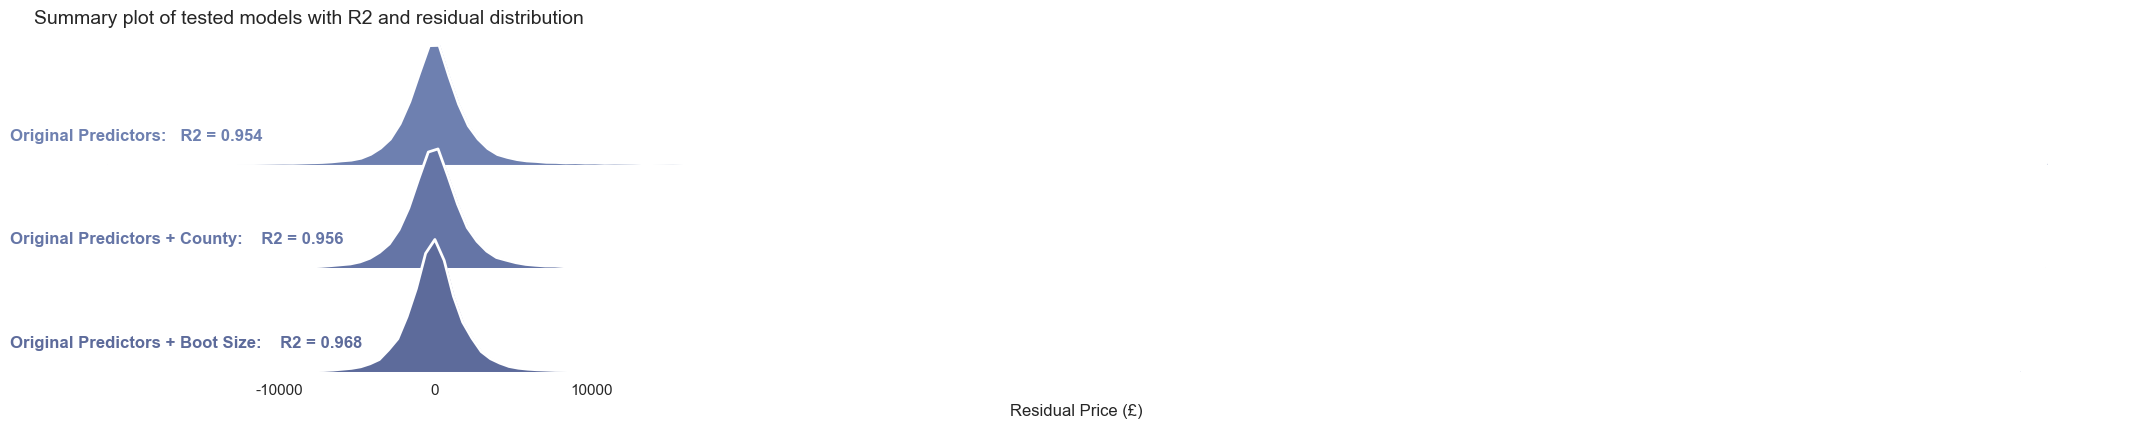

In [209]:
# Ambitious Residuals plot - needs work on X-axis

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Make the input data - really clumsy.
gb_resid_cont_df = pd.DataFrame(gb_resid_cont)
gb_resid_cont_df['model']='Continuous Predictors Only  R2 = 0.877'
gb_resid_df2 = pd.DataFrame(gb_resid2)
gb_resid_df2['model']='Original Predictors:   R2 = 0.954'
gb_resid_county_df = pd.DataFrame(gb_resid_county)
gb_resid_county_df['model']='Original Predictors + County:    R2 = 0.956'
gb_resid_boot_df = pd.DataFrame(gb_resid_boot)
gb_resid_boot_df['model']='Original Predictors + Boot Size:    R2 = 0.968'


tocat=[gb_resid_df2,gb_resid_county_df,gb_resid_boot_df,]
residplotdf = pd.concat(tocat)
residplotdf.columns = ['Residual Price (£)', 'model']

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.1, light=.5)
g = sns.FacetGrid(residplotdf, row="model", hue="model", aspect=15, height=1.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "Residual Price (£)",
      bw_adjust=.5, clip_on=True,
      fill=True, alpha=1, linewidth=1)
g.map(sns.kdeplot, "Residual Price (£)", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
#g.refline(y=0, linewidth=2,linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "Residual Price (£)")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)
#setting xticks

ticks = [-10000, 0, 10000]
labels = [i for i in ticks]
g.set(xticks = ticks, xticklabels = labels)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
plt.title('Summary plot of tested models with R2 and residual distribution',x=0.14, y=2.45, fontsize=14)
g.despine(bottom=True, left=True)
plt.savefig('furthermodelsummary.pdf',bbox_inches='tight')
plt.show()

# Neural Network test

In [ ]:
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.base import TransformerMixin
from sklearn.preprocessing import LabelBinarizer, StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline, make_union
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer as Imputer

In [ ]:
# Prep data, called df

# Read clean used cars data, drop columns not useful in modelling and drop under populated makes
cars_abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/02_cars_with_location_and_size.csv'

df = pd.read_csv(cars_abspath)
print('all',df.shape)

# Save copy for later if needed
refdf = df.copy()

# Select used cars only
df = df[df['used']==1]
print('used',df.shape)

# Drop outliers in log-price
mask = np.abs((df.log_price - df.log_price.mean()) / df.log_price.std()) > 3
df= df[~mask]
print('used_without_price_outliers',df.shape)

# Drop outliers in log-mileage
mask = np.abs((df.log_mileage - df.log_mileage.mean()) / df.log_mileage.std()) > 3
df= df[~mask]
print('used_without_mileage_outliers',df.shape)

# Drop outliers in BHP
mask = np.abs((df.BHP - df.BHP.mean()) / df.BHP.std()) > 6
df= df[~mask]
print('used_without_BHP_outliers',df.shape)

# Drop under represented car makes
carnums = df.groupby(by='make')['price'].count().sort_values().reset_index()
carmakes = carnums[carnums.price>200].make.to_list()
df = df[df.make.isin(carmakes)].copy()
print('used_without_little_makes', df.shape)

dfsample = df.sample(50000, random_state=1)
carnums = dfsample.groupby(by='make')['price'].count().sort_values().reset_index()
carmakes = carnums[carnums.price>50].make.to_list()
dfsample = dfsample[dfsample.make.isin(carmakes)]

In [ ]:
dfsample.columns

### Copying lesson exactly

In [ ]:
# Create a helper class to extract features one by one in a pipeline 
class FeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column].values.reshape(-1, 1)


In [ ]:
# Train test split 

X = dfsample[['log_price','log_mileage','year','BHP','drivertrain',
        'make','body','transmission','fuel','doors','cargo_volume_L']]
y = X.pop('log_price')

X.columns

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=y, random_state=42)


In [ ]:
# Create a pipeline to binarize labels and impute missing values with an appropriate method 

logmileage_pipe = make_pipeline(
    FeatureExtractor('log_mileage'),
    Imputer(strategy='mean'),
    StandardScaler()
)
year_pipe = make_pipeline(
    FeatureExtractor('year'),
    Imputer(strategy='mean'),
    StandardScaler()
)
BHP_pipe = make_pipeline(
    FeatureExtractor('BHP'),
    Imputer(strategy='mean'),
    StandardScaler()
)
drivetrain_pipe = make_pipeline(
    FeatureExtractor('drivertrain'),
    Imputer(strategy='most_frequent'),
    OneHotEncoder(drop='first', sparse=False),
    StandardScaler()
)
make_pipe = make_pipeline(
    FeatureExtractor('make'),
    Imputer(strategy='most_frequent'),
    OneHotEncoder(drop='first', sparse=False),
    StandardScaler()
)
body_pipe = make_pipeline(
    FeatureExtractor('body'),
    Imputer(strategy='most_frequent'),
    OneHotEncoder(drop='first', sparse=False),
    StandardScaler()
)
transmission_pipe = make_pipeline(
    FeatureExtractor('transmission'),
    Imputer(strategy='most_frequent'),
    OneHotEncoder(drop='first', sparse=False),
    StandardScaler()
)
fuel_pipe = make_pipeline(
    FeatureExtractor('fuel'),
    Imputer(strategy='most_frequent'),
    OneHotEncoder(drop='first', sparse=False),
    StandardScaler()
)
doors_pipe = make_pipeline(
    FeatureExtractor('doors'),
    Imputer(strategy='most_frequent'),
    OneHotEncoder(drop='first', sparse=False),
    StandardScaler()
)

fu = make_union(logmileage_pipe, year_pipe,
                BHP_pipe, drivetrain_pipe, make_pipe, body_pipe,
                transmission_pipe, fuel_pipe, doors_pipe)

In [ ]:
# Apply transforms to the train and test data 

train_X = fu.fit_transform(X_train)
test_X = fu.transform(X_test)

In [ ]:
# Not required - I was trying to troubleshoot an error 

# y_train = y_train.to_numpy()
# y_test = y_test.to_numpy()

# y_train=y_train.astype('float')
# y_test=y_test.astype('float')

In [ ]:
# Sanity check input data shapes 

train_X.shape, test_X.shape, y_train.shape, y_test.shape

In [ ]:
#MLPRegressor modelling 

clf = MLPRegressor(solver='adam',
                    alpha=10**(0),
                    hidden_layer_sizes=(4, 4, 4, 4),
                    activation='relu',
                    random_state=42,
                    batch_size=50,
                    max_iter=5000)
clf.fit(train_X, y_train)
print('Train R2',metrics.r2_score(y_train, clf.predict(train_X)))
print('Test R2',metrics.r2_score(y_test, clf.predict(test_X)))

### Blending lesson and capstone preprocessing

In [ ]:
# Dummify necessary columns 
X = dfsample[['log_price','log_mileage','year','BHP','drivertrain',
        'make','body','transmission','fuel','doors']]
y = X.pop('log_price')
to_dummy=['drivertrain','make','body','transmission','fuel','doors']
X= pd.get_dummies(X, columns = to_dummy, drop_first=True)
print('Dummified df shape',X.shape,'\n')

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=y, random_state=42)

sc = StandardScaler()

train_X = pd.DataFrame(sc.fit_transform(X_train), columns = X_train.columns)
test_X = pd.DataFrame(sc.fit_transform(X_test), columns = X_train.columns)

In [ ]:
# Sanity check input data shapes

train_X.shape, test_X.shape, y_train.shape, y_test.shape

In [ ]:
#MLPRegressor modelling

clf = MLPRegressor(solver='adam',
                    alpha=10**(0),
                    hidden_layer_sizes=(4, 4, 4, 4),
                    activation='relu',
                    random_state=42,
                    batch_size=50,
                    max_iter=5000)
clf.fit(train_X, y_train)
print('Train R2',metrics.r2_score(y_train, clf.predict(train_X)))
print('Test R2',metrics.r2_score(y_test, clf.predict(test_X)))